# Local Max-k-cut with FLIP


## Prepare environment

### Import libraries

In [115]:
import numpy as np
import os
import networkx as nx
import networkx.drawing
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import time
from scipy import stats
from tabulate import tabulate
import multiprocessing as mp
import matplotlib.cm as cmx
import matplotlib.colors as matcolors
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import pickle

#%matplotlib notebook
%matplotlib inline

### Main functions

In [85]:
# Max-cut functions
def InitializeGraph(n, min_weight, max_weight, dropout, seed = -1, graph_type="complete", intercalation=None, modulo=None):
    # Randomness
    if graph_type == "complete":
        if seed == -1:
            W = np.random.uniform(low=min_weight, high=max_weight, size=(n,n))
        else:
            local_state = np.random.RandomState(seed)
            W = local_state.uniform(low=min_weight, high=max_weight, size=(n,n))
        # Dropout with connected
        if dropout>0:
            connected = False
            while not connected:
                if seed == -1:
                    D = np.random.choice([0,1], size=(n,n), replace=True, p=[dropout, 1-dropout])
                else:
                    D = local_state.choice([0,1], size=(n,n), replace=True, p=[dropout, 1-dropout])
                W_dropped = np.multiply(W,D)
                
                # Check for connectivity
                i_lower = np.tril_indices(n, -1)
                W_dropped[i_lower] = W_dropped.T[i_lower]
                # Make sure diagonal is empty
                np.fill_diagonal(W_dropped, 0)
                W_sym = nx.from_numpy_matrix(W_dropped)
                if nx.is_connected(W_sym):
                    connected = True
                    W = np.copy(W_dropped)     
    elif graph_type == "cycle":
        if seed == -1:
            weights = np.random.uniform(low=min_weight, high=max_weight, size=n)
        else:
            local_state = np.random.RandomState(seed)
            weights = local_state.uniform(low=min_weight, high=max_weight, size=(n,n))
        W = np.zeros((n,n))
        i = 0
        j = 1
        for k in range(n-1):
            W[i,j] = weights[k]
            i+=1
            j+=1
        # Add last weight
        W[0, n-1] = weights[n-1]                
    elif graph_type == "regular_log(n)":
        degseq = np.repeat(np.floor(np.log(n)), n)
        adjMatr = AdjacencyMatrixDegree(degseq)
        if seed == -1:
            W = np.random.uniform(low=min_weight, high=max_weight, size=n)
        else:
            local_state = np.random.RandomState(seed)
            W = local_state.uniform(low=min_weight, high=max_weight, size=n)
        W = np.multiply(W,adjMatr)
    elif graph_type == "intercalate":
        if seed == -1:
            weights = np.random.uniform(low=min_weight, high=max_weight, size=n)
        else:
            local_state = np.random.RandomState(seed)
            weights = local_state.uniform(low=min_weight, high=max_weight, size=(n,n))
        adjMatr = np.zeros((n,n))
        # Fill diagonals above the main diagonal
        for k in range(intercalation):
            for i in range(n-k-1):
                adjMatr[i, i+k+1] = 1
        # Fill upper right corner
        for j in range(intercalation):
            for i in range(j+1):
                adjMatr[j-i, n-i-1]=1
        W = np.multiply(weights, adjMatr)
    elif graph_type == "modulo":
        if seed == -1:
            weights = np.random.uniform(low=min_weight, high=max_weight, size=n)
        else:
            local_state = np.random.RandomState(seed)
            weights = local_state.uniform(low=min_weight, high=max_weight, size=(n,n))
        adjMatr = np.zeros((n,n))
        # Create circle
        for i in range(n-1):
            adjMatr[i, i+1] = 1
        # Fill upper right corner
        adjMatr[0, n-1]=1
        # Add other connections
        # Fill diagonals above the main diagonal
        for i in range(n-modulo):
            adjMatr[i, i+modulo] = 1
        # Fill upper right corner
        for i in range(modulo):
            adjMatr[modulo-1-i, n-i-1]=1
        W = np.multiply(weights, adjMatr)
    # Stochastic Block Model
    elif graph_type == "assortative":
        communities = np.floor(n/3)
        sizes = 3*[int(communities)]
        # Check if we have all nodes:
        if 3*communities < n:
            sizes[0] +=1
        if 3*communities < n-1:
            sizes[1] +=1
        probs = [[0.4, 0.02, 0.02], [0.02, 0.4, 0.02], [0.02, 0.02, 0.4]]
        g = nx.stochastic_block_model(sizes, probs, seed=0)
        W = nx.to_numpy_matrix(g)
    elif graph_type == "disassortative":
        communities = np.floor(n/3)
        sizes = 3*[int(communities)]
        # Check if we have all nodes:
        if 3*communities < n:
            sizes[0] +=1
        if 3*communities < n-1:
            sizes[1] +=1
        probs = [[0.02, 0.08, 0.08], [0.08, 0.02, 0.08], [0.08, 0.08, 0.2]]
        g = nx.stochastic_block_model(sizes, probs, seed=0)
        W = nx.to_numpy_matrix(g)
    elif graph_type == "ordered":
        communities = np.floor(n/3)
        sizes = 3*[int(communities)]
        # Check if we have all nodes:
        if 3*communities < n:
            sizes[0] +=1
        if 3*communities < n-1:
            sizes[1] +=1
        probs = [[0, 0.15, 0.15], [0.15, 0, 0.15], [0.15, 0.15, 0]]
        g = nx.stochastic_block_model(sizes, probs, seed=0)
        W = nx.to_numpy_matrix(g)
    elif graph_type == "core-periphery":
        communities = np.floor(n/3)
        sizes = 3*[int(communities)]
        # Check if we have all nodes:
        if 3*communities < n:
            sizes[0] +=1
        if 3*communities < n-1:
            sizes[1] +=1
        probs = [[0.4, 0.15, 0.03], [0.15, 0.15, 0.03], [0.03, 0.03, 0.03]]
        g = nx.stochastic_block_model(sizes, probs, seed=0)
        W = nx.to_numpy_matrix(g)
    
    # Copy upper diagonal to lower diagonal (only the upper perturbation counts)
    i_lower = np.tril_indices(n, -1)
    W[i_lower] = W.T[i_lower]
    # Make sure diagonal is empty
    np.fill_diagonal(W, 0)
    
    return W

def InitializeFlatGraph(n, min_weight, max_weight, dropout = 0, seed = -1, graph_type = "complete", intercalation = None, modulo = None):
    if graph_type == "complete":
        if seed == -1:
            W = np.random.uniform(low=min_weight, high=max_weight, size=n)
        else:
            local_state = np.random.RandomState(seed)
            W = local_state.uniform(low=min_weight, high=max_weight, size=n)
        if dropout>0:            
            connected = False
            while connected == False:
                if seed == -1:
                    D = np.random.choice([0,1], size=n, replace=True, p=[dropout, 1-dropout])
                else:
                    D = local_state.choice([0,1], size=n, replace=True, p=[dropout, 1-dropout])
                # Check if the dropped out matrix is connected
                # Make it a symmetric matrix
                D_sym = SymmetricMatrix(D)
                # Check if it resembles a connected graph
                D_sym = nx.from_numpy_matrix(D_sym)
                if nx.is_connected(D_sym):
                    connected = True
            # Once we have a conencted graph, add weights
            W = np.multiply(W,D)       
    elif graph_type == "cycle":
        if seed == -1:
            weights = np.random.uniform(low=min_weight, high=max_weight, size=n)
        else:
            local_state = np.random.RandomState(seed)
            weights = local_state.uniform(low=min_weight, high=max_weight, size=n)
        W = np.zeros((n,n))
        i = 0
        j = 1
        for k in range(n-1):
            W[i,j] = weights[k]
            i+=1
            j+=1
        # Add last weight
        W[0, n-1] = weights[n-1]
        i_lower = np.tril_indices(n, -1)
        W[i_lower] = W.T[i_lower]
        # Make sure diagonal is empty
        np.fill_diagonal(W, 0)
        W = np.copy(W[np.triu_indices_from(W, k = 1)])
    elif graph_type == "regular_log(n)":
        degseq = np.repeat(np.floor(np.log(n)), n)
        adjMatr = AdjacencyMatrixDegree(degseq)
        if seed == -1:
            W = np.random.uniform(low=min_weight, high=max_weight, size=n)
        else:
            local_state = np.random.RandomState(seed)
            W = local_state.uniform(low=min_weight, high=max_weight, size=n)
        W = np.multiply(W,adjMatr)
        W = np.copy(W[np.triu_indices_from(W, k = 1)])
    elif graph_type == "intercalate":
        W = InitializeGraph(n, min_weight, max_weight, dropout, seed, graph_type, intercalation)
        W = np.copy(W[np.triu_indices_from(W, k = 1)])
    elif graph_type == "modulo":
        W = InitializeGraph(n, min_weight, max_weight, dropout, seed, graph_type, None, modulo)
        W = np.copy(W[np.triu_indices_from(W, k = 1)])
    return W

def AdjacencyMatrixDegree(degseq):
    # n is number of vertices  
    n = len(degseq)
    mat = [[0] * n for i in range(n)] 
    for i in range(n): 
        for j in range(i + 1, n): 
            # For each pair of vertex decrement  
            # the degree of both vertex.  
            if (degseq[i] > 0 and degseq[j] > 0): 
                degseq[i] -= 1
                degseq[j] -= 1
                mat[i][j] = 1
                mat[j][i] = 1
    return mat

def GetAllPossibleAdjacencyFlatMatrixes(n):
    import itertools
    flatMatrixes = list(itertools.product([0, 1], repeat=n))
    return flatMatrixes

def GetKRandomPartition(n, k, seed = -1):
    partition = {}
    if seed == -1:
        for i in range(n):
            partition[i]=np.random.randint(low=0, high=k, size=1)[0]
    else:
        local_state = np.random.RandomState(seed)
        for i in range(n):
            partition[i]=local_state.randint(low=0, high=k, size=1)[0]
    return partition

# G stands for special ill-posed matrixes
def GetGWeightMatrix(g):
    if g == 1:
        G = np.array([[0, 7, 0, 0, 0, 0, 0, 0],
             [0, 0, 6, 0, 0, 0, 0, 0],
             [0, 0, 0, 5, 0, 0, 0, 0],
             [0, 0, 0, 0, 1, 3, 0, 0],
             [0, 0, 0, 0, 0, 0, 1, 1],
             [0, 0, 0, 0, 0, 0, 2, 0],
             [0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0]]).astype(float)
    elif g == 2:
        G = np.array([
               [0, 51, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 49, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 8, 0, 10, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 8, 0, 8, 5, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]).astype(float)
    else:
        raise("No")
    n = np.size(G, 1)
    i_lower = np.tril_indices(n, -1)
    G[i_lower] = G.T[i_lower]
    return G

def WeightsStats(W):
    print("Weight statistics\n")
    mean = []
    median = []
    std = []
    min_w = []
    max_w = []
    n = []
    W_without_0_edges = np.copy(W[W!=0])
    mean.append(W_without_0_edges.mean())
    median.append(np.median(W_without_0_edges))
    std.append(W_without_0_edges.std())
    min_w.append(W_without_0_edges.min())
    max_w.append(W_without_0_edges.max())
    s = W_without_0_edges.shape[0]
    s = int((1+np.sqrt(1+4*2*s))/2)+1
    n.append(s)
    print(tabulate(list(zip(*[n, mean, median, std, min_w, max_w])), 
                   headers=["n", 'mean', 'median', 'std', "min_weight", "max_weight"], floatfmt=".3f"))
    return

def Get0Partition(n):
    partition = {}
    for i in range(n):
        partition[i]=0
    return partition

def Get1Partition(n):
    partition = {}
    for i in range(n):
        partition[i]=1
    return partition

def GetStupidPartition(n):
    partition = {}
    for i in range(n):
        partition[i]=-1
    return partition

def GetInitialPartition(n, k, initial_partition_type, seed = -1):
    if initial_partition_type == "random":
        initial_partition = GetKRandomPartition(n, k, seed)
    if initial_partition_type == "0":
        initial_partition = Get0Partition(n)
    if initial_partition_type == "1":
        initial_partition = Get1Partition(n)
    return initial_partition

def CutCost(W, partition, n, k):
    z = 0
    identity = np.identity(k)
    for i in range(n):
        for j in range(i, n):
            new_edge = (1-identity[partition[i], partition[j]])*W[i,j]
            z += new_edge
    return z
        
def CutGainAfterFlip(W, initial_partition, final_partition, n):
    # Vi: initial partition of the vertex v
    # Vj: final partition of the vertex v
    # z: current cut
    weights_to_add = 0
    weights_to_substract = 0
    
    diff_partition = {key: initial_partition[key] - final_partition.get(key, 0) for key in initial_partition}
    
    # v: vertex that flipped
    v = [key for key, val in diff_partition.items() if val!=0][0]
    v_old_partition = initial_partition[v]
    v_new_partition = final_partition[v]
    
    # Vertices belonging to the old group and the new group
    vertices_in_old_partition = [key  for (key, value) in initial_partition.items() if value == v_old_partition]
    vertices_in_new_partition = [key  for (key, value) in initial_partition.items() if value == v_new_partition]

    for vi in vertices_in_old_partition:
        if vi == v:
            continue
        else:
            weights_to_add += W[v, vi]
    for vj in vertices_in_new_partition:
        weights_to_substract += W[v, vj]
    z = weights_to_add - weights_to_substract
    return z
            
def SolveMaxCut(W, n, k, z, initial_partition, heuristic, seed = -1):
    tol = 1e-8
    maxIter = 100000
    it = 0
    
    zt1 = -10000
    zt2 = CutCost(W, initial_partition, n, k)
    
    # In case the cut is already optimal
    new_z = zt2
    
    # Store old and new partition
    old_partition = GetStupidPartition(n)
    new_partition = initial_partition
    
    start = time.time()
    if heuristic == "GBF":
        # Greedy Best Flip
        while(old_partition!=new_partition and it<maxIter):
            old_partition = new_partition
            new_partition, new_z = GreedyBestFlip(W, new_partition, n, k, zt2)
            zt1 = zt2
            zt2 = new_z
            if old_partition!=new_partition:
                it = it + 1
    elif heuristic == "RPF":
        # Random Positive Flip
         while(old_partition!=new_partition and it<maxIter):
            old_partition = new_partition
            new_partition, new_z = RandomPositiveFlip(W, new_partition, n, k, zt2, seed)
            zt1 = zt2
            zt2 = new_z
            if old_partition!=new_partition:
                it = it + 1
    elif heuristic == "WF":
        # Worst Flip
         while(old_partition!=new_partition and it<maxIter):
            old_partition = new_partition
            new_partition, new_z = WorstFlip(W, new_partition, n, k, zt2)
            zt1 = zt2
            zt2 = new_z
            if old_partition!=new_partition:
                it = it + 1

    elif heuristic == "FNF":
        # First Next Flip
        # Only for testing purposes
        iters_fnf = 3
        for i in range(iters_fnf):
            partition, new_z = FirstNextFlip(W, partition, n, k, zt2)
            zt1 = zt2
            zt2 = new_z
            if old_partition!=new_partition:
                it = it + 1
            
    end = time.time()
    elapsed_time = np.round(end - start, 4)
    # The last step would return the same partition, so it-1
    return new_partition, new_z, elapsed_time, it

def SolveGlobalMaxCut(W, n, k):
    # Get all possible partitions
    import itertools
    k_vector = range(k)
    allPartitions = list(itertools.product(k_vector, repeat=n))
    n_partitions = len(allPartitions)
    max_cut = -100000
    best_partition = allPartitions[0]
    start = time.time()
    for partition in allPartitions:
        c = CutCost(W, partition, n, k)
        if c > max_cut:
            max_cut = c
            best_partition = partition
    end = time.time()
    elapsed_time = np.round(end - start, 4)
    # Create the partition dictionary
    best_partition = list(best_partition)
    keys = range(0, n)
    best_partition_d = {k:v for k,v in zip(keys, best_partition)}
    # The last step would return the same partition, so it-1
    return best_partition_d, max_cut, elapsed_time

def GurobiSolveMaxCut(W, n):
    # Initialize model
    m = gp.Model("max-cut")
    m.setParam('OutputFlag', 0)
    # Define variables
    # x: partition of each node?
    # z: edge is present in the cut?
    x = m.addVars(n, vtype=GRB.BINARY, name='partitions')
    z = m.addVars(n, n, vtype=GRB.BINARY, name="edges")
    
    # Add constrains
    m.addConstrs((z[i,j]<=x[i]+x[j] for i in range(n) for j in range(n)), "C1")
    m.addConstrs((z[i,j]+x[i]+x[j]<=2 for i in range(n) for j in range(n)), "C2")
    
    # Set objective function
    obj_f = gp.quicksum(1/2*W[(i,j)]*z[(i,j)] for i in range(n) for j in range(n))
    m.setObjective(obj_f, GRB.MAXIMIZE)
    
    # Go
    m.optimize()
    
    # Get solution
    best_cut = m.getObjective().getValue()
    
    # Get final partition
    nodes = m.getVars()
    best_partition = {}
    for i in range(n):
        best_partition[i] = nodes[i].x
    
    return best_partition, best_cut
    
def SymmetricMatrix(W):
    m = len(W)
    n = int((1+np.sqrt(1+4*2*m))/2)
    A = np.zeros(shape=(n, n))
    # k runs along W
    k = 0
    # Fill upper diagonal
    for i in range(n-1):
        for j in range(i+1, n):
            A[i,j]=W[k]
            k+=1
    # Fill lower diagonal
    i_lower = np.tril_indices(n, -1)
    A[i_lower] = A.T[i_lower]
    return A

def ScaleMatrix(W, a, b):
    non_zeros = np.nonzero(W)
    min_W = W[non_zeros].min()
    max_W = W.max()
    # Keep structure
    W_scaled = np.copy(W.astype(float))
    W_scaled[non_zeros] = (b-a)*((W[non_zeros]-min_W)/(max_W-min_W))+a
    return W_scaled

def NumpyToCsv(array, filename):
    np.savetxt(str(filename) + ".csv", array, delimiter=";")

def DeleteTempResults(filename):
    if os.path.exists(filename):
        os.remove(filename)
    return

def CsvToNumpy(filename):
    return np.genfromtxt(str(filename) + ".csv", delimiter=";")

def KolmogorovSmirnovTest(x1, x2, alpha):
    st, p = stats.ks_2samp(x1, x2)
    n1 = len(x1)
    n2 = len(x2)
    size_term = np.sqrt((n1+n2)/(n1*n2))
    if alpha == 0.05:
        d = size_term*1.36
    elif alpha == 0.025:
        d = size_term*1.48
    else:
        return
    if st < d:
        print("Both distributions are the same with probability", 100*(1-alpha), "%")
        print(st, "<", d)
    if st > d:
        print("Reject null hypothesis: different distributions with probability", 100*(1-alpha), "%")
        print(st, ">", d)
    return

def PrintPartitionCounts(partition):
    partition_df = pd.DataFrame.from_dict(partition, orient='index')
    partition_df.columns = ["partition"]
    print(partition_df["partition"].value_counts())
    return

# Meshgrid - No need to parallelize
def MeshGrid3dMaxCut(k, min_weight, max_weight, initial_partition_type, n_points_ax, n_iters, complexity, heuristic, sigma):
    weights_size = 3
    x = np.zeros(shape=(np.power(n_points_ax+1, 3), weights_size))
    f = np.zeros(np.power(n_points_ax+1, 3))
    # p runs over all points
    p = 0
    for i in range(n_points_ax+1):
        x_val = min_weight + (max_weight-min_weight)*i/n_points_ax
        for j in range(n_points_ax+1):
            y_val = min_weight + (max_weight-min_weight)*j/n_points_ax
            for l in range(n_points_ax+1):
                z_val = min_weight + (max_weight-min_weight)*l/n_points_ax
                w_flat = [x_val, y_val, z_val]
                w = SymmetricMatrix(w_flat)
                steps = np.zeros(n_iters)
                for it in range(n_iters):
                    initial_partition = GetInitialPartition(3, k, initial_partition_type)
                    initial_z = CutCost(w, initial_partition, 3, k)
                    if complexity == "average":
                        _p, _z, _t, steps[it] = SolveMaxCut(w, 3, k, initial_z, initial_partition, heuristic)
                    elif complexity == "smoothed":
                        # n_iters is also used for n_perturbations
                        steps[it] = SmoothedComplexity(w_flat, 3, k, initial_partition_type, 0, n_iters, heuristic, sigma)
                f[p] = np.mean(steps)
                x[p] = [x_val, y_val, z_val]
                p+=1
    return x, f

def PlotMeshGrid3d(x, f, title, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matcolors.Normalize(vmin=min(f), vmax=max(f))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x[:,0], x[:,1], x[:,2], c=scalarMap.to_rgba(f))
    plt.xticks(np.arange(min(x[:,0]), max(x[:,0])+1, 0.5))
    plt.yticks(np.arange(min(x[:,1]), max(x[:,1])+1, 0.5))
    scalarMap.set_array(f)
    fig.colorbar(scalarMap)
    if title:
        plt.title(title)
    plt.show()

# Plot results
def GetColorsVector(n):
    all_colors = ["blue", "red", "green", "black", "purple"]
    #"orange", "green", "red", "black", "purple", "grey"]
    return all_colors[:n]

def PlotGraph(W, partition=None, plotWeights=False, ax=None, seed=None):
    G = nx.from_numpy_matrix(np.round(W, 3))
    # Relabel nodes
    #mapping = {0: '1', 1: '2', 2: '3'}
    #G = nx.relabel_nodes(G, mapping)
    pos = nx.circular_layout(G)
    #if seed:
    #    pos = nx.spring_layout(G, seed=seed)
    #else:
    #    pos = nx.spring_layout(G)
    # Create edge labels
    labels = nx.get_edge_attributes(G, 'weight')
    edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
    
    # Draw the graph according to node positions
    if partition is not None:
        colors = np.fromiter(partition.values(), dtype=int)
        if ax is None:
            nx.draw(G, pos, with_labels=True, node_color=colors, edgelist=edges, edge_color=weights, width=5.0, edge_cmap=plt.cm.Blues)
        else:
            nx.draw(G, pos, with_labels=True, node_color=colors, edgelist=edges, edge_color=weights, width=5.0, edge_cmap=plt.cm.Blues, ax=ax)
    else:
        if ax is None:
            nx.draw(G, pos, with_labels=True, edgelist=edges, edge_color=len(edges)*['black'], width=5.0, edge_cmap=plt.cm.Blues)
        else:
            nx.draw(G, pos, with_labels=True, edgelist=edges, edge_color=weights, width=5.0, edge_cmap=plt.cm.Blues, ax=ax)
    # Draw edge labels according to node positions
    if plotWeights:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, ax=ax)
    if ax is None:
        plt.show()    
    return

def PlotChainGraph(W, initial_partition, chain, plotWeights=False, seed=None):
    # Plot initial graph
    PlotGraph(W, partition=initial_partition, plotWeights=plotWeights, seed=seed)
    current_partition = initial_partition
    current_cut = CutCost(W, current_partition, W.shape[1], 2)
    print("Initial cut:", current_cut)
    for i in range(len(chain)):
        if current_partition[chain[i]]==0:
            current_partition[chain[i]] = 1
        else:
            current_partition[chain[i]] = 0
        current_cut = CutCost(W, current_partition, W.shape[1], 2)
        # Plot new graph
        PlotGraph(W, partition=current_partition, plotWeights=plotWeights, seed=seed)
        print("Current cut:", current_cut)

    return
        
def PlotWeightsHistogram(W):
    # Start plot
    plt.figure(1)
    plt.subplot(211)
    # Plot histogram of weights
    W_without_0_edges = np.copy(W[W!=0])
    plt.hist(W_without_0_edges, bins=20, color='blue')
    plt.title('Weight distribution', fontsize=8)
    # Do KSTest with uniform
    n = len(W)
    uniform_sample = np.random.uniform(low=-1, high=1, size=n)
    KolmogorovSmirnovTest(W, uniform_sample, alpha=0.025)
    # Histogram of the sum of the edges from each vertex
    sum_of_edges = np.sum(SymmetricMatrix(W), axis = 0)
    plt.subplot(212)
    plt.hist(sum_of_edges, bins=10)
    plt.title('Sum of edges', fontsize=8)
    plt.tight_layout()
    plt.show()
    # Do KSTest with artificial sample (assume independency)
    #artificial_sample = np.zeros(n)
    #for i in range(n):
    #    artificial_sample[i] = np.sum(np.random.uniform(low=-1, high=1, size=n-1))
    #KolmogorovSmirnovTest(sum_of_edges, artificial_sample, 0.05)
    return

def PlotRegressionResults(nodes, steps_mean, steps_sd, with_errorbars, r_var, r_var_label, method):
    
    # Convert X axis according to method
    x = nodes.reshape(-1,1)
    x = nodes
    cmap = GetColorsVector(len(r_var))
    
    # t runs over all columns of steps_mean
    t=0
    slopes=[]
    intercepts=[]
    r_values=[]
    p_values=[]
    std_errs=[]

    # Create a new plot
    plt.figure(np.random.randint(501, 1000))
    ax = plt.subplot(1, 1, 1)

    if method=="polynomial":
        plt.yscale("log")
        plt.xscale("log")
    
    for r_v in r_var:
        # Convert Y axis according to method
        y = steps_mean[:,t]
        plt.scatter(x, y, c=cmap[t])
        if with_errorbars:
            y_sd = steps_sd[:, t]/y
            plt.errorbar(x,y,yerr=y_sd, linestyle="None", c=cmap[t])

        x_log = np.log(x)
        y_log = np.log(y)
        # Linear regression
        slope, intercept, r_value, p_value, std_err = stats.mstats.linregress(x_log,y_log)

        # Store results
        slopes.append(slope)
        intercepts.append(intercept)
        r_values.append(r_value)
        p_values.append(p_value)
        std_errs.append(std_err)

        # Linear regression prediction
        y_reg = intercept + slope*x_log
        plt.plot(x, np.exp(y_reg), label=str(r_var_label) + '=' + str(r_v), c=cmap[t])
        t+=1

    if method=="polynomial":
        plt.title('Polynomial behavior')     
        plt.xlabel('Nodes') 
        plt.ylabel('Steps')
    
    if method=="exponential":
        plt.title('Exponential behavior')     
        plt.xlabel('Nodes') 
        plt.ylabel('ln(Steps)')
        
    if method=="quasipolynomial":
        plt.title('Quasiplynomial behavior')     
        plt.xlabel('ln(Nodes)*Nodes') 
        plt.ylabel('ln(Steps)')
    
    plt.legend()  
    
    ax.set_xticks([10])
    ax.set_yticks([10, 15])

    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.set_minor_formatter(ScalarFormatter())
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_minor_formatter(ScalarFormatter())
    
    plt.show()

    # Print table
    print("Regression results:\n")
    print(tabulate(list(zip(*[r_var, slopes, intercepts, r_values])), headers=[r_var_label, 'slope', 'intercept', 'r_value'], floatfmt=".3f"))
    
    return slopes, intercepts
    
def PlotResults(nodes, steps_mean, steps_sd, with_errorbars, r_var, r_var_label, xlabel = "Nodes", ylabel = "Steps"):
    #r_var is running variable
    
    # Show results for each r_var
    x = nodes.reshape(-1, 1)

    # Legend
    r_var_labels=[]

    # t runs over all columns of steps_mean
    t=0

    cmap = GetColorsVector(len(r_var))
    
    # Create a new plot
    plt.figure(np.random.randint(0, 500))
    
    for r_v in r_var:
        run_steps = steps_mean[:,t]
        plt.scatter(x, run_steps, c=cmap[t])
        if with_errorbars:
            run_steps_sd = steps_sd[:, t]
            plt.errorbar(x,run_steps,yerr=run_steps_sd, linestyle="None", c=cmap[t])
        r_var_labels.append(str(r_var_label) + "=" + str(r_v))
        t+=1

    plt.title(str(xlabel) + " vs. " + str(ylabel)) 
    plt.xlabel(xlabel) 
    plt.ylabel(ylabel)
    plt.legend(r_var_labels)
    plt.show()
    
def PlotResultsSmoothed(nodes, steps_mean, steps_sd, with_errorbars, r_var, r_var_label, sigma, withUpperBound):
    #r_var is running variable
    
    # Show results for each r_var
    x = nodes.reshape(-1, 1)

    # Legend
    r_var_labels=[]

    # t runs over all columns of steps_mean
    t=0
    
    # Create a new plot
    plt.figure(np.random.randint(1001, 1500))

    for r_v in r_var:
        run_steps = steps_mean[:,t]
        plt.scatter(x, run_steps)
        if with_errorbars:
            run_steps_sd = steps_sd[:, t]
            plt.errorbar(x,run_steps,yerr=run_steps_sd, linestyle="None")
        r_var_labels.append(str(r_var_label) + "=" + str(r_v))
        t+=1
    # Assume gaussian
    if withUpperBound:
        phi = 1/np.sqrt(2*np.pi*sigma*sigma)
        upper_bound = phi*np.power(nodes, 7.83)
        plt.plot(nodes, upper_bound, color='red', linewidth=1.0, linestyle='--')
    plt.title('Steps vs. Nodes') 
    plt.xlabel('Nodes') 
    plt.ylabel('Steps')
    plt.legend(r_var_labels)
    plt.show()
    return

def PlotTwoRegressionResults(nodes1, steps_mean1, steps_sd1, nodes2, steps_mean2, steps_sd2, with_errorbars, r_var, r_var_label, method, labels):
    
    # Create a new plot
    plt.figure(np.random.randint(501, 1000))

    ax = plt.subplot(1,1,1)
    
    if method=="polynomial":
        plt.yscale("log")
        plt.xscale("log")
    # t runs over all columns of steps_mean
    t=0
    slopes1=[]
    intercepts1=[]
    r_values1=[]
    p_values1=[]
    std_errs1=[]  
    
    # Convert X axis according to method
    x1 = nodes1
    
    # For the averae case, we have to reduce the number of vertices so that the have similar lengths
    last_index = np.argmax(nodes1>np.max(nodes2))
    if last_index == 0:
        last_index = len(x1-1)
    x1 = x1[:last_index]
    steps_mean1 = steps_mean1[:last_index]
    steps_sd1 = steps_sd1[:last_index]
    
    for r_v in r_var:
        # Convert Y axis according to method
        y1 = steps_mean1[:,t]
        plt.scatter(x1, y1, c = "darkred", alpha=0.5)
        if with_errorbars:
            if len(steps_sd1)>0:
                y_sd1 = steps_sd1[:, t]
                plt.errorbar(x1,y1,yerr=y_sd1, linestyle="None", c = "darkred", alpha=0.5)

        # Linear regression
        x1_log = np.log(x1)
        y1_log = np.log(y1)
        slope1, intercept1, r_value1, p_value1, std_err1 = stats.mstats.linregress(x1_log,y1_log)

        # Store results
        slopes1.append(slope1)
        intercepts1.append(intercept1)
        r_values1.append(r_value1)
        p_values1.append(p_value1)
        std_errs1.append(std_err1)

        # Linear regression prediction
        y_reg1 = intercept1 + slope1*x1_log
        plt.plot(x1, np.exp(y_reg1), label=labels[0], c = "red")
        t+=1
        
    # t runs over all columns of steps_mean
    t=0
    slopes2=[]
    intercepts2=[]
    r_values2=[]
    p_values2=[]
    std_errs2=[]   
    
    # X2 is smoothed, therefore no error bars
    # Convert X axis according to method
    x2 = nodes2
    
    for r_v in r_var:
        # Convert Y axis according to method
        y2 = steps_mean2[:,t]
        plt.scatter(x2, y2, c = "darkblue", alpha=0.5)
        if with_errorbars:
            if len(steps_sd2)>0:
                y_sd2 = steps_sd2[:, t]
                plt.errorbar(x2,y2,yerr=y_sd2, linestyle="None", c = "darkblue", alpha=0.5)

        # Linear regression
        x2_log = np.log(x2)
        y2_log = np.log(y2)
        slope2, intercept2, r_value2, p_value2, std_err2 = stats.mstats.linregress(x2_log,y2_log)

        # Store results
        slopes2.append(slope2)
        intercepts2.append(intercept2)
        r_values2.append(r_value2)
        p_values2.append(p_value2)
        std_errs2.append(std_err2)

        # Linear regression prediction
        y_reg2 = intercept2 + slope2*x2_log
        plt.plot(x2, np.exp(y_reg2), label=labels[1], c = "blue")
        t+=1

    if method=="polynomial":
        plt.title('Polynomial behavior')     
        plt.xlabel('Nodes') 
        plt.ylabel('Steps')
    
    if method=="exponential":
        plt.title('Exponential behavior')     
        plt.xlabel('Nodes') 
        plt.ylabel('ln(Steps)')
        
    if method=="quasipolynomial":
        plt.title('Quasiplynomial behavior')     
        plt.xlabel('ln(Nodes)*Nodes') 
        plt.ylabel('ln(Steps)')
    
    plt.legend(loc="upper left") 
    ax.set_xticks([5, 10, 50])   
    ax.set_yticks([1, 10, 50])

    ax.xaxis.set_major_formatter(ScalarFormatter())
    #ax.xaxis.set_minor_formatter(ScalarFormatter())
    ax.yaxis.set_major_formatter(ScalarFormatter())
    #ax.yaxis.set_minor_formatter(ScalarFormatter())
    plt.show()

    # Print table
    print("Regression results:\n")
    print(labels[0])
    print(tabulate(list(zip(*[r_var, slopes1, intercepts1, r_values1])), headers=[r_var_label, 'slope', 'intercept', 'r_value'], floatfmt=".3f"))
    print(labels[1])
    print(tabulate(list(zip(*[r_var, slopes2, intercepts2, r_values2])), headers=[r_var_label, 'slope', 'intercept', 'r_value'], floatfmt=".3f"))
    
    return

def PlotThreeRegressionResults(nodes1, steps_mean1, steps_sd1, nodes2, steps_mean2, steps_sd2, nodes3, steps_mean3, steps_sd3,
                               with_errorbars, r_var, r_var_label, method, labels):
    
    # Create a new plot
    plt.figure(np.random.randint(501, 1000))
    ax = plt.subplot(1, 1, 1)

    # t runs over all columns of steps_mean
    t=0
    slopes1=[]
    intercepts1=[]
    r_values1=[]
    p_values1=[]
    std_errs1=[]
    
#    if method =="polynomial":
#        plt.yscale("log")
#        plt.xscale("log")
        
    if method == "exponential":
        plt.yscale("log")

    # Convert nodes
    x1 = nodes1.reshape(-1, 1)
    
    # For the averae case, we have to reduce the number of vertices so that the have similar lengths
    last_index = np.argmax(nodes1>np.max(nodes2))
    if last_index == 0:
        last_index = len(x1-1)
    x1 = x1[:last_index]
    steps_mean1 = steps_mean1[:last_index]
    steps_sd1 = steps_sd1[:last_index]
    
    # Convert Y axis according to method
    y1 = steps_mean1
    plt.scatter(x1, y1, c = "darkred", alpha=0.5)
    if with_errorbars:
        if len(steps_sd1)>0:
            y_sd1 = steps_sd1
            plt.errorbar(x1,y1,yerr=y_sd1, linestyle="None", c = "darkred", alpha=0.5)

    # Linear regression
    # Convert to log to apply linear regression
    x1_log = np.log(x1)
    y1_log = np.log(y1)
    slope1, intercept1, r_value1, p_value1, std_err1 = stats.mstats.linregress(x1_log,y1_log)

    # Store results
    slopes1.append(slope1)
    intercepts1.append(intercept1)
    r_values1.append(r_value1)
    p_values1.append(p_value1)
    std_errs1.append(std_err1)

    # Linear regression prediction
    y_reg1 = intercept1 + slope1*x1_log
    plt.plot(x1, np.exp(y_reg1), label=labels[0], c = "red")
        
    # t runs over all columns of steps_mean
    slopes2=[]
    intercepts2=[]
    r_values2=[]
    p_values2=[]
    std_errs2=[]   
    
    # X2 is smoothed, therefore no error bars
    # Convert X axis according to method
    x2 = nodes2.reshape(-1,1)
    
    # Convert Y axis according to method
    y2 = steps_mean2
    plt.scatter(x2, y2, c = "darkblue", alpha=0.5)
    if with_errorbars:
        if len(steps_sd2)>0:
            y_sd2 = steps_sd2
            plt.errorbar(x2,y2,yerr=y_sd2, linestyle="None", c = "darkblue", alpha=0.5)

    # Linear regression
    # Convert to log to apply linear regression
    x2_log = np.log(x2)
    y2_log = np.log(y2)
    slope2, intercept2, r_value2, p_value2, std_err2 = stats.mstats.linregress(x2_log,y2_log)

    # Store results
    slopes2.append(slope2)
    intercepts2.append(intercept2)
    r_values2.append(r_value2)
    p_values2.append(p_value2)
    std_errs2.append(std_err2)

    # Linear regression prediction
    y_reg2 = intercept2 + slope2*x2_log
    plt.plot(x2, np.exp(y_reg2), label=labels[1], c = "blue")
        
    # t runs over all columns of steps_mean
    slopes3=[]
    intercepts3=[]
    r_values3=[]
    p_values3=[]
    std_errs3=[]   
    
    # Convert X axis according to method
    x3 = nodes3.reshape(-1,1)
    
    # Convert Y axis according to method
    y3 = steps_mean3
    plt.scatter(x3, y3, c = "darkgreen", alpha=0.5)
    if with_errorbars:
        if len(steps_sd3)>0:
            y_sd3 = steps_sd3
            plt.errorbar(x3,y3,yerr=y_sd3, linestyle="None", c = "darkgreen", alpha=0.5)

    # Linear regression
    x3_log = np.log(x3)
    y3_log = np.log(y3)
    slope3, intercept3, r_value3, p_value3, std_err3 = stats.mstats.linregress(x3_log,y3_log)

    # Store results
    slopes3.append(slope3)
    intercepts3.append(intercept3)
    r_values3.append(r_value3)
    p_values3.append(p_value3)
    std_errs3.append(std_err3)

    # Linear regression prediction
    y_reg3 = intercept3 + slope3*x3_log
    plt.plot(x3, np.exp(y_reg3), label=labels[2], c = "green")

    if method=="polynomial":
        plt.title('Polynomial behavior')     
        plt.xlabel('Nodes') 
        plt.ylabel('Steps')
    
    if method=="exponential":
        plt.title('Exponential behavior')     
        plt.xlabel('Nodes') 
        plt.ylabel('Steps')
        
    if method=="quasipolynomial":
        plt.title('Quasiplynomial behavior')     
        plt.xlabel('Nodes*Nodes') 
        plt.ylabel('Steps')
        
    if method == "lineal":
        plt.title('Ratios')     
        plt.ylabel('local/global') 
        plt.xlabel('Nodes')
    
    #plt.legend(loc="lower left")        
    plt.legend()
    #ax.set_xticks([4, 10, 20, 30])   
    ax.set_yticks([0.94, 0.96, 0.98, 1])

    #ax.xaxis.set_major_formatter(ScalarFormatter())
    #ax.xaxis.set_minor_formatter(ScalarFormatter())
    #ax.yaxis.set_major_formatter(ScalarFormatter())
    #ax.yaxis.set_minor_formatter(ScalarFormatter())

    #ax.xaxis.set_minor_locator(mpl.ticker.AutoLocator())

    plt.show()

    # Print table
    print("Regression results:\n")
    print(tabulate(list(zip(*[labels[0], slopes1, intercepts1, r_values1])), headers=[r_var_label, 'slope', 'intercept', 'r_value'], floatfmt=".3f"))
    print(tabulate(list(zip(*[labels[1], slopes2, intercepts2, r_values2])), headers=[r_var_label, 'slope', 'intercept', 'r_value'], floatfmt=".3f"))
    print(tabulate(list(zip(*[labels[2], slopes3, intercepts3, r_values3])), headers=[r_var_label, 'slope', 'intercept', 'r_value'], floatfmt=".3f"))
    
    return

def MultilinearRegression(X, Y, method):
    import statsmodels.api as sm
    from sklearn import linear_model
    if method == "log-log":
        X = np.log(X)
        Y = np.log(Y)
    X = sm.add_constant(X) # adding a constant
    model = sm.OLS(Y, X).fit()
    #predictions = model.predict(X) 
    print_model = model.summary()
    print(print_model)
    return model.params, model.rsquared

#### FLIP strategies

In [13]:
def GreedyBestFlip(W, partition, n, k, z):
    cut_costs = []
    partitions_flip = []
    # Permutate vertices so that we do not always start by the same one
    order = np.random.permutation(range(n))
    for i in order:
        for j in range(1, k):            
            new_partition = partition.copy()
            new_partition[i] = (new_partition[i]+j)%k
            partitions_flip.append(new_partition)
            cut_costs.append(CutGainAfterFlip(W, partition, new_partition, n))
      
    # Convert the list to a numpy array
    cut_costs = np.asarray(cut_costs)
    if np.any(cut_costs[cut_costs>0]):
        # New best partition was found
        best_index = np.argmax(cut_costs)
        best_partition = partitions_flip[best_index]
        new_cut_cost = z + cut_costs[best_index]
        return best_partition, new_cut_cost
    else:
        # We are in a local optimum
        return partition, z
    
def RandomPositiveFlip(W, partition, n, k, z, seed = -1):
    # Permutate vertices so that we do not always start by the same one
    # Randomness
    if seed == -1:
        order = np.random.permutation(range(n))
    else:
        local_state = np.random.RandomState(seed)
        order = local_state.permutation(range(n))
    for i in order:
        for j in range(1, k):            
            new_partition = partition.copy()
            new_partition[i] = (new_partition[i]+j)%k
            new_z = CutGainAfterFlip(W, partition, new_partition, n)
            if new_z > 0:
                return new_partition, z + new_z
      
    return partition, z

def WorstFlip(W, partition, n, k, z):
    cut_costs = []
    partitions_flip = []
    # Permutate vertices so that we do not always start by the same one
    order = np.random.permutation(range(n))
    for i in order:
        for j in range(1, k):            
            new_partition = partition.copy()
            new_partition[i] = (new_partition[i]+j)%k
            partitions_flip.append(new_partition)
            cut_costs.append(CutGainAfterFlip(W, partition, new_partition, n))
      
    # Convert the list to a numpy array
    cut_costs = np.asarray(cut_costs)
    
    if np.any(cut_costs[cut_costs>0]):
        # A better partition was found
        min_val = min(c for c in cut_costs if c > 0)
        worst_index = np.argwhere(cut_costs==min_val)[0][0]
        worst_partition = partitions_flip[worst_index]
        new_cut_cost = z + cut_costs[worst_index]
        return worst_partition, new_cut_cost
    else:
        # We are in a local optimum
        return partition, z

## Example instance

### Main parameters

In [32]:
# Number of nodes
n = 30
# Number of partitions (k-cut)
k = 2

# Define min weight and max weight of the graph
min_weight=-1
max_weight=1

# Dropout
dropout = 0

# Initial values
W = InitializeGraph(n, min_weight, max_weight, dropout, graph_type="ordered")
W_w = InitializeGraph(n, min_weight, max_weight, dropout)
W = np.multiply(W, W_w)

#### Plot intercalation

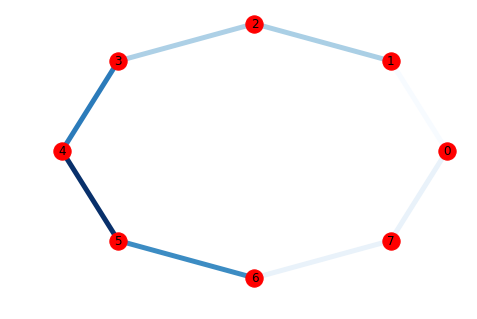

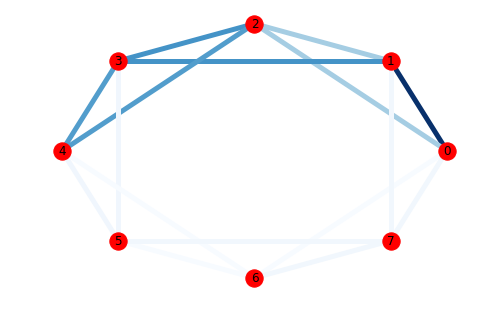

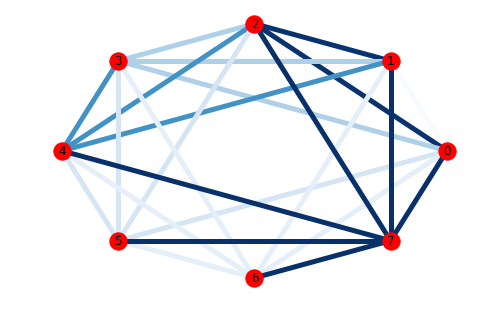

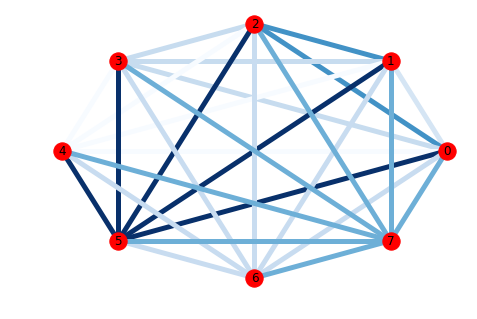

In [365]:
for i in range(1, 5):
    W = InitializeGraph(n, min_weight, max_weight, dropout, graph_type="intercalate", intercalation=i)
    PlotGraph(W)

#### Solve global max-cut

Using license file C:\Users\kerik\gurobi.lic
Academic license - for non-commercial use only


C:\Users\kerik\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


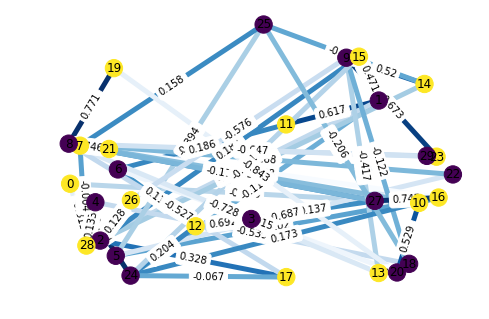

Global max-cut: 9.1185623101342


In [33]:
best_partition, max_cut = GurobiSolveMaxCut(W, n)
PlotGraph(W, best_partition, plotWeights=True)
print("Global max-cut:", max_cut)

In [42]:
PrintPartitionCounts(best_partition)

0.0    15
1.0    15
Name: partition, dtype: int64


### Instance with exponential number of steps G1

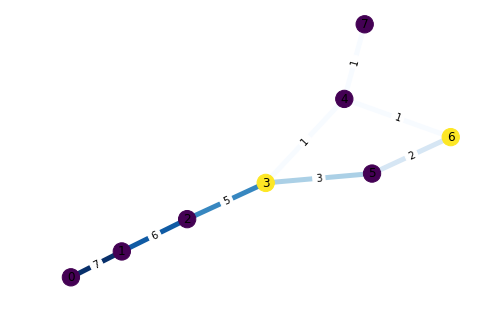

Initial cut: 12.0


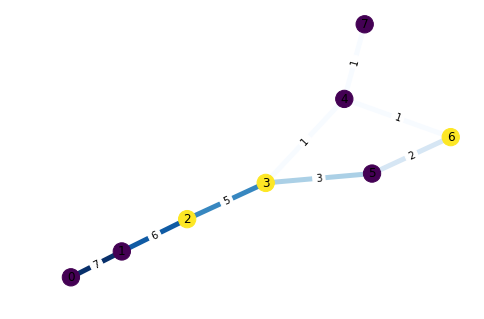

Current cut: 13.0


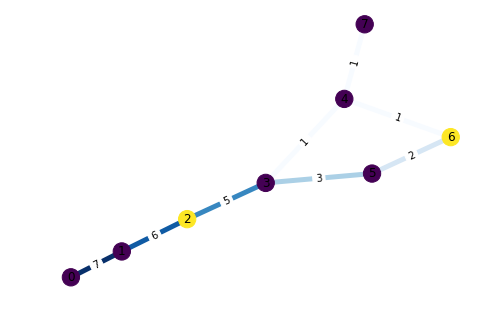

Current cut: 14.0


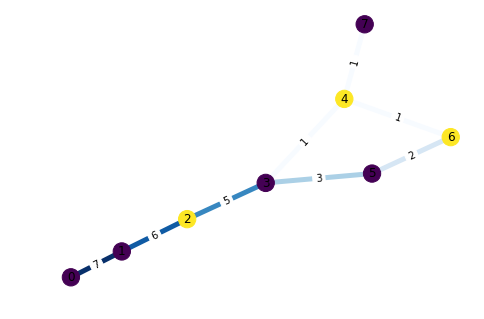

Current cut: 15.0


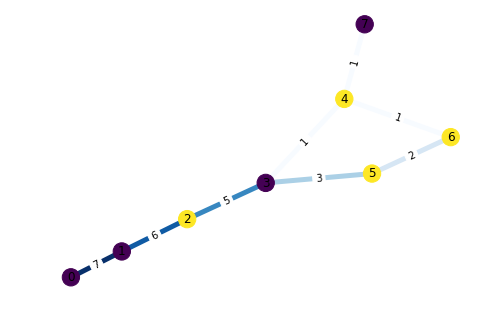

Current cut: 16.0


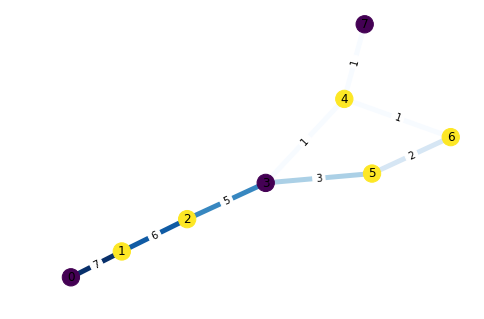

Current cut: 17.0


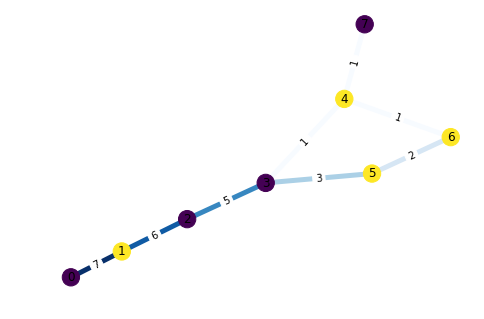

Current cut: 18.0


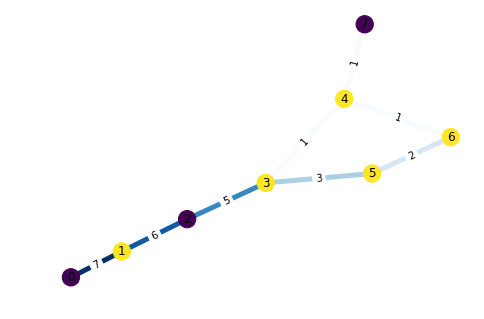

Current cut: 19.0


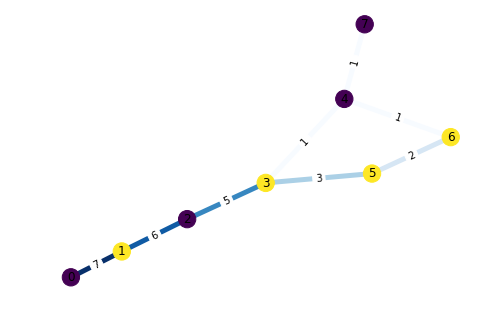

Current cut: 20.0


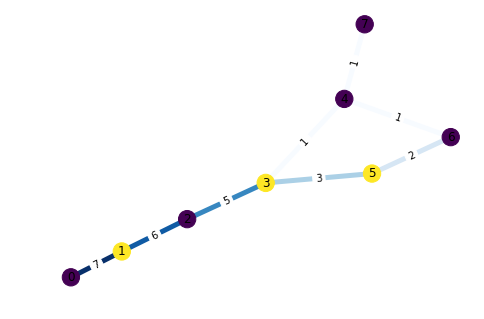

Current cut: 21.0


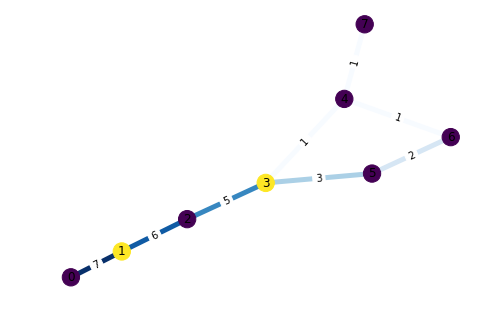

Current cut: 22.0


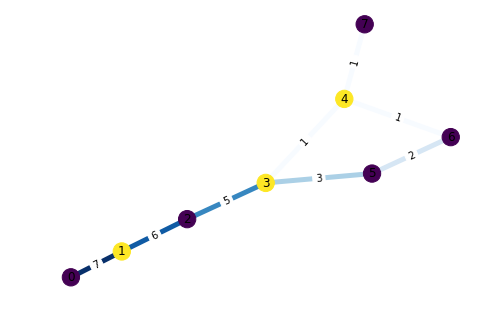

Current cut: 23.0


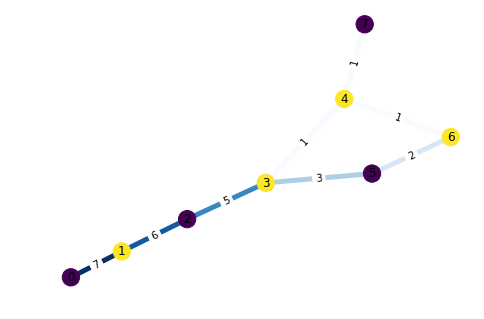

Current cut: 24.0


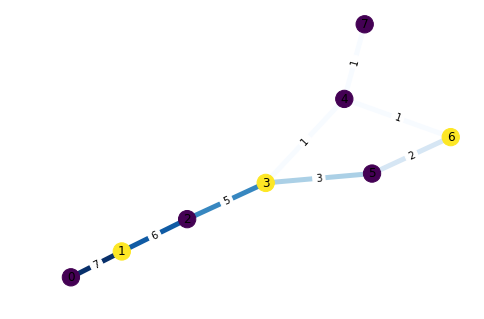

Current cut: 25.0


In [153]:
n = 8
k = 2
G1 = np.array([[0, 7, 0, 0, 0, 0, 0, 0],
             [0, 0, 6, 0, 0, 0, 0, 0],
             [0, 0, 0, 5, 0, 0, 0, 0],
             [0, 0, 0, 0, 1, 3, 0, 0],
             [0, 0, 0, 0, 0, 0, 1, 1],
             [0, 0, 0, 0, 0, 0, 2, 0],
             [0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0]])

i_lower = np.tril_indices(n, -1)
G1[i_lower] = G1.T[i_lower]
initial_partition = Get0Partition(n)
initial_partition[3]=1
initial_partition[6]=1
#G1 = ScaleMatrix(G1, -1, 1)

# Chain of movements
chain = [2,3,4,5,1,2,3,4,6,5,4,6,4]
PlotChainGraph(G1, initial_partition, chain, plotWeights=True, seed=11)


In [ ]:
initial_partition = Get0Partition(n)
initial_z = CutCost(G1, initial_partition, n, k)
partition, z, elapsed_time, steps = SolveMaxCut(G1, n, k, initial_z, initial_partition, "WF")
print('Greedy Best Flip')
print('Initial cut: ' + str(initial_z))
print('Last cut: ' + str(z))
print('Number of steps: ' + str(steps))
print("Elapsed time: " + str(elapsed_time) + " s.\n")
PlotGraph(G1, partition)

C:\Users\kerik\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


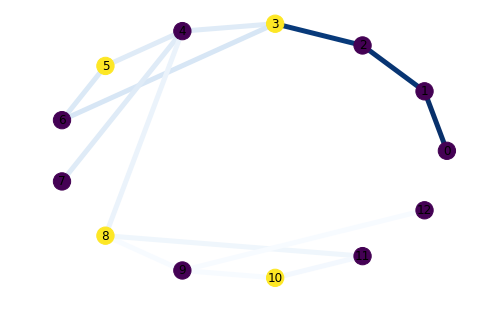

Greedy Best Flip
Initial cut: 100.0
Last cut: 211.0
Number of steps: 15
Elapsed time: 0.0049 s.



In [85]:
G = GetGWeightMatrix(2)
n = 13
initial_partition = Get0Partition(n)
initial_partition[3]=1
initial_partition[5]=1
initial_partition[8]=1
initial_partition[10]=1
#print(initial_partition)
PlotGraph(G, initial_partition)
initial_z = CutCost(G, initial_partition, n, k)
partition, z, elapsed_time, steps = SolveMaxCut(G, n, k, initial_z, initial_partition, "WF")
print('Greedy Best Flip')
print('Initial cut: ' + str(initial_z))
print('Last cut: ' + str(z))
print('Number of steps: ' + str(steps))
print("Elapsed time: " + str(elapsed_time) + " s.\n")

### Instance with exponential number of steps G2

In [334]:
G = GetGWeightMatrix(2)
n = np.size(G,1)
# Make sure zeros keep zeros
zeros = np.where(G==0)
#G = ScaleMatrix(G, 0, 1)
#G[zeros]=0
w_norm = np.linalg.norm(np.triu(G))
# Parameters
n_perturbations = 10000

structure = np.nonzero(G)
initial_partition_type = "0"
k = 2
heuristic = "WF"
#heuristic = "RPF"
sigmas = np.asarray([0, 0.01, 0.02, 0.03, 0.04])*w_norm
sigmas_labels = [0, 0.01, 0.02, 0.03, 0.04]
averages = []
results= []
from matplotlib import pyplot
bins = np.linspace(0, 30, 5)
for sigma in sigmas:
    steps = np.zeros(n_perturbations)
    for n_p in range(n_perturbations):
        G_p = np.copy(G)
        # Create perturbation
        if sigma>0:
            perturbation = np.random.normal(loc=0, scale=sigma, size=(n,n))
            G_p[structure] = G_p[structure] + perturbation[structure]        
        # Convert to symmetric matrix
        i_lower = np.tril_indices(n, -1)
        G_p[i_lower] = G_p.T[i_lower]
        # Get initial partition randomly
        initial_partition = GetInitialPartition(n, k, initial_partition_type)
        initial_partition[3]=1
        initial_partition[5]=1
        initial_partition[8]=1
        initial_partition[10]=1
        # Get initial cost value
        initial_z = CutCost(G_p, initial_partition, n, k)
        # Get next local maximum
        partition, z, elapsed_time, n_steps = SolveMaxCut(G_p, n, k, initial_z, initial_partition, heuristic)
        # Save results
        # times += elapsed_time
        steps[n_p]=n_steps
    averages.append(np.mean(steps))
    #results.append(steps)
    results.append(steps)
    #results.append(np.max(steps))

labels = ["σ=|W|*" + str(s) for s in sigmas_labels]
colors = GetColorsVector(len(averages))
# plt.hist(results, bins, label=labels, color=colors)
i=0
#for average in averages:
#    plt.axvline(x=average, color=colors[i])
#    i+=1
#pyplot.legend(loc='upper right')
#pyplot.show()

print(sigmas_labels)
print(results)

[0, 0.01, 0.02, 0.03, 0.04]
[array([15., 15., 15., ..., 15., 15., 15.]), array([ 3., 15., 15., ...,  9.,  3.,  3.]), array([5., 3., 3., ..., 3., 5., 7.]), array([ 8.,  3.,  3., ..., 11.,  5.,  3.]), array([ 8.,  3., 15., ...,  4.,  3.,  8.])]


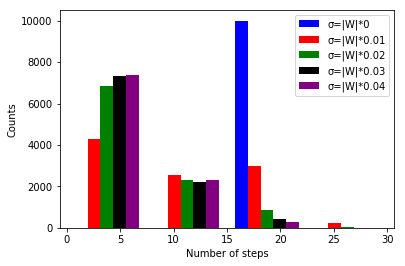

In [336]:
bins = np.linspace(0, 30, 5)
labels = ["σ=|W|*" + str(s) for s in sigmas_labels]
colors = GetColorsVector(len(averages))
plt.hist(results, bins, label=labels, color=colors)
i=0
#for average in averages:
#    plt.axvline(x=average, color=colors[i])
#    i+=1
pyplot.xlabel("Number of steps")
pyplot.ylabel("Counts")
pyplot.legend(loc='upper right')
pyplot.show()

In [ ]:
print(sigmas_labels)
print(results)

### Facebook graph

In [30]:
fileName="./Graphs/facebook.txt"
graph_type=nx.DiGraph()
G = nx.read_edgelist(fileName, create_using=graph_type, nodetype=int)
W = nx.to_numpy_matrix(G)
n = len(G.nodes())
k = 2
initial_partition = GetInitialPartition(n, k, "0")
initial_z = CutCost(W, initial_partition, n, k)

### Solve local Max-k-cut instance

#### Greedy Best Flip

In [31]:
partition, z, elapsed_time, steps = SolveMaxCut(W, n, k, initial_z, initial_partition, "GBF")
print('Greedy Best Flip')
print('Initial cut: ' + str(initial_z))
print('Last cut: ' + str(z))
print('Number of steps: ' + str(steps))
print("Elapsed time: " + str(elapsed_time) + " s.\n")
PlotGraph(W, partition)

KeyboardInterrupt: 

#### Random Positive Flip

Random Positive Flip
Initial cut: -5.124702341272353
Last cut: 3.096469773001522
Number of steps: 4
Elapsed time: 0.001 s.


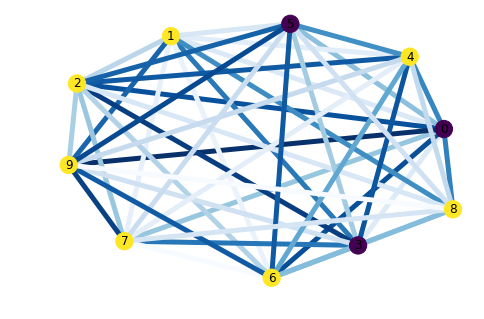

In [83]:
partition, z, elapsed_time, steps = SolveMaxCut(W, n, k, initial_z, initial_partition, "RPF")
print("Random Positive Flip")
print('Initial cut: ' + str(initial_z))
print('Last cut: ' + str(z))
print('Number of steps: ' + str(steps))
print("Elapsed time: " + str(elapsed_time) + " s.")
PlotGraph(W, partition)

#### Worst Flip

In [104]:
partition, z, elapsed_time, steps = SolveMaxCut(W, n, k, initial_z, initial_partition, "WF")
print("Worst Flip")
print('Initial cut: ' + str(initial_z))
print('Last cut: ' + str(z))
print('Number of steps: ' + str(steps))
print("Elapsed time: " + str(elapsed_time) + " s.")
PlotGraph(W, partition)

NameError: name 'initial_z' is not defined

In [55]:
nodes = np.linspace(8, 12, num=3)
# Remove decimal part
nodes = np.floor(nodes)
# Convert to integer
nodes = nodes.astype(int)
iters = 20
min_weight = -1
max_weight = 1
heuristics = ["GBF", "RPF", "WF"]
k = 2
initial_partition = "0"
dropout = 0

global_average_value, local_average_value, average_ratios, global_average_value_sd, local_average_value_sd, average_ratios_sd = SolveGlobalAndLocalMaxCut(nodes, iters, min_weight, max_weight, heuristics, k, initial_partition, dropout)

In [56]:
print(global_average_value)
print(average_ratios)

[[3.99877104]
 [5.7005743 ]
 [7.85326117]]
[[0.98857937 0.97250662 0.9333863 ]
 [0.93905586 0.93296049 0.92656897]
 [0.93258149 0.8779931  0.87738884]]


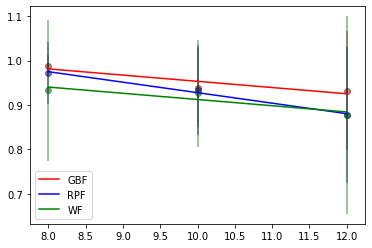

Regression results:

GBF
h      slope    intercept    r_value
---  -------  -----------  ---------
GBF   -0.014        1.093     -0.914
RPF
h      slope    intercept    r_value
---  -------  -----------  ---------
GBF   -0.024        1.164     -0.996
WF
h      slope    intercept    r_value
---  -------  -----------  ---------
GBF   -0.014        1.052     -0.916


In [57]:
PlotThreeRegressionResults(nodes, average_ratios[:,0], average_ratios_sd[:,0], nodes, average_ratios[:,1], average_ratios_sd[:,1], nodes, average_ratios[:,2], average_ratios_sd[:,2],
                               True, heuristics, "h", "lineal", ["GBF", "RPF", "WF"])

## Average complexity

### Main functions

#### Serial functions

In [15]:
def RunGridMaxCutAverageK(min_nodes, max_nodes, step_nodes, initial_partition_type, dropout, ks, min_weight, max_weight, iters_for_nk, heuristic, graph_type = "complete", storeCSV=False):

    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)

    steps_mean = np.zeros((len(nodes), len(ks)))
    steps_sd = np.zeros((len(nodes), len(ks)))
    
    # Save nodes
    if storeCSV:
        NumpyToCsv(nodes, "nodes")
    
    i = 0
    j = 0

    for ni in nodes:
        weights_size = int(ni*(ni-1)/2)
        for ki in ks:
            steps = np.zeros(iters_for_nk)
            for it in range(iters_for_nk):
                # Create graph and initial partition
                W_k_it = InitializeFlatGraph(weights_size, min_weight, max_weight, dropout, graph_type=graph_type)
                W_k_it = SymmetricMatrix(W_k_it)
                initial_partition = GetInitialPartition(ni, ki, initial_partition_type)
                # Get initial cost value
                initial_z = CutCost(W_k_it, initial_partition, ni, ki)
                # Get next local maximum
                partition, z, elapsed_time, n_steps = SolveMaxCut(W_k_it, ni, ki, initial_z, initial_partition, heuristic)
                # Save results for each iteration
                steps[it]=n_steps
             
            # Save results for a i,j combination    
            steps_mean[i,j] = np.mean(steps)
            steps_sd[i,j] = np.std(steps)/np.sqrt(iters_for_nk)
            if storeCSV:
                DeleteTempResults("average_complexities.csv")
                NumpyToCsv(steps_mean, "average_complexities")
                DeleteTempResults("average_complexities_sd.csv")
                NumpyToCsv(steps_sd, "average_complexities_sd")
            j = j + 1
        j = 0
        i = i + 1
    return steps_mean, steps_sd, nodes

def FindWorstInstance(n, initial_partition_type, dropout, k, min_weight, max_weight, iters_for_nk, heuristic, storeCSV=False):
    steps = np.zeros(iters_for_nk)   
    weights_size = int(n*(n-1)/2)
    max_value = 0
    for it in range(iters_for_nk):
        # Create graph and initial partition
        W_k_it = InitializeFlatGraph(weights_size, min_weight, max_weight, dropout)
        W_k_it = SymmetricMatrix(W_k_it)
        initial_partition = GetInitialPartition(n, k, initial_partition_type)
        # Get initial cost value
        initial_z = CutCost(W_k_it, initial_partition, n, k)
        # Get next local maximum
        partition, z, elapsed_time, n_steps = SolveMaxCut(W_k_it, n, k, initial_z, initial_partition, heuristic)
        # Save results for each iteration
        steps[it]=n_steps            
        if n_steps>max_value:
            max_value = n_steps
            worst_instance = W_k_it
            
    if storeCSV:
        DeleteTempResults("n_steps.csv")
        NumpyToCsv(steps, "n_steps")
        DeleteTempResults("worst_instance.csv")
        NumpyToCsv(worst_instance, "worst_instance")
    return worst_instance, max_value

def RunGridMaxCutAverageDropout(min_nodes, max_nodes, step_nodes, initial_partition_type, dropouts, k, min_weight, max_weight, iters_for_nk, heuristic):

    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)

    steps_mean = np.zeros((len(nodes), len(dropouts)))
    steps_sd = np.zeros((len(nodes), len(dropouts)))
    
    i = 0
    j = 0

    for ni in nodes:
        for d in dropouts:
            steps = np.zeros(iters_for_nk)
            for it in range(iters_for_nk):
                # Create graph and initial partition
                W = InitializeGraph(ni, min_weight, max_weight, d)
                initial_partition = GetInitialPartition(ni, k, initial_partition_type)
                # Get initial cost value
                initial_z = CutCost(W, initial_partition, ni, k)
                # Get next local maximum
                partition, z, elapsed_time, n_steps = SolveMaxCut(W, ni, k, initial_z, initial_partition, heuristic)
                # Save results for each iteration
                steps[it]=n_steps
                
            # Save results for a i,j combination    
            steps_mean[i,j] = np.mean(steps)
            steps_sd[i,j] = np.std(steps)/np.sqrt(iters_for_nk)
            j = j + 1
        j = 0
        i = i + 1
    return steps_mean, steps_sd, nodes

def RunGridMaxCutAverageDegrees(min_nodes, max_nodes, step_nodes, initial_partition_type, degrees, k, min_weight, max_weight, iters_for_nk, heuristic):

    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)

    steps_mean = np.zeros((len(nodes), len(dropouts)))
    steps_sd = np.zeros((len(nodes), len(dropouts)))
    
    i = 0
    j = 0

    for ni in nodes:
        for d in degrees:
            steps = np.zeros(iters_for_nk)
            for it in range(iters_for_nk):
                # Create graph and initial partition
                W = InitializeGraph(ni, min_weight, max_weight, d)
                initial_partition = GetInitialPartition(ni, k, initial_partition_type)
                # Get initial cost value
                initial_z = CutCost(W, initial_partition, ni, k)
                # Get next local maximum
                partition, z, elapsed_time, n_steps = SolveMaxCut(W, ni, k, initial_z, initial_partition, heuristic)
                # Save results for each iteration
                steps[it]=n_steps
                
            # Save results for a i,j combination    
            steps_mean[i,j] = np.mean(steps)
            steps_sd[i,j] = np.std(steps)/np.sqrt(iters_for_nk)
            j = j + 1
        j = 0
        i = i + 1
    return steps_mean, steps_sd, nodes

def RunGridMaxCutAverageHeuristics(min_nodes, max_nodes, step_nodes, initial_partition_type, dropout, k, min_weight, max_weight, iters_for_nk, heuristics):

    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)

    steps_mean = np.zeros((len(nodes), len(heuristics)))
    steps_sd = np.zeros((len(nodes), len(heuristics)))
    
    max_cut_mean = np.zeros((len(nodes), len(heuristics)))
    max_cut_sd = np.zeros((len(nodes), len(heuristics)))
    
    i = 0
    j = 0

    for ni in nodes:
        for h in heuristics:
            steps = np.zeros(iters_for_nk)
            max_cuts = np.zeros(iters_for_nk)
            for it in range(iters_for_nk):
                # Create graph and initial partition
                W = InitializeGraph(ni, min_weight, max_weight, dropout)
                initial_partition = GetInitialPartition(ni, k, initial_partition_type)
                # Get initial cost value
                initial_z = CutCost(W, initial_partition, ni, k)
                # Select method
                partition, z, elapsed_time, n_steps = SolveMaxCut(W, ni, k, initial_z, initial_partition, h)
                # Save results for each iteration
                steps[it]=n_steps
                max_cuts[it] = z
                
            # Save results for a i,j combination    
            steps_mean[i,j] = np.mean(steps)
            steps_sd[i,j] = np.std(steps)/np.sqrt(iters_for_nk)
            max_cut_mean[i,j] = np.mean(max_cuts)
            max_cut_sd[i,j] = np.std(max_cuts)/np.sqrt(iters_for_nk)
            j = j + 1
        j = 0
        i = i + 1
    return steps_mean, steps_sd, max_cut_mean, max_cut_sd, nodes

def RunGridMaxCutAverageSBM(min_nodes, max_nodes, step_nodes, initial_partition_type, dropout, k, min_weight, max_weight, iters_for_nk, heuristic, graph_structures):

    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)

    steps_max = np.zeros((len(nodes), len(graph_structures)))
    steps_mean = np.zeros((len(nodes), len(graph_structures)))
    steps_sd = np.zeros((len(nodes), len(graph_structures)))
    
    max_cut_mean = np.zeros((len(nodes), len(graph_structures)))
    max_cut_sd = np.zeros((len(nodes), len(graph_structures)))
    
    i = 0
    j = 0

    for ni in nodes:
        for g in graph_structures:
            steps = np.zeros(iters_for_nk)
            max_cuts = np.zeros(iters_for_nk)
            for it in range(iters_for_nk):
                # Create graph and initial partition
                W_st = InitializeGraph(ni, min_weight, max_weight, dropout, graph_type=g)
                W_weights = InitializeGraph(ni, min_weight, max_weight, dropout)
                W = np.multiply(W_st, W_weights)
                initial_partition = GetInitialPartition(ni, k, initial_partition_type)
                # Get initial cost value
                initial_z = CutCost(W, initial_partition, ni, k)
                # Select method
                partition, z, elapsed_time, n_steps = SolveMaxCut(W, ni, k, initial_z, initial_partition, heuristic)
                # Save results for each iteration
                steps[it]=n_steps
                max_cuts[it] = z
                
            # Save results for a i,j combination   
            steps_max[i,j] = np.max(steps)
            steps_mean[i,j] = np.mean(steps)
            steps_sd[i,j] = np.std(steps)/np.sqrt(iters_for_nk)
            max_cut_mean[i,j] = np.mean(max_cuts)
            max_cut_sd[i,j] = np.std(max_cuts)/np.sqrt(iters_for_nk)
            j = j + 1
        j = 0
        i = i + 1
    return steps_mean, steps_sd, max_cut_mean, max_cut_sd, steps_max, nodes

def RunGridMaxCutAverageIntercalations(min_nodes, max_nodes, step_nodes, initial_partition_type, dropout, k, min_weight, max_weight, iters_for_nk, heuristic, intercalations, storeCSV=False):

    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)

    steps_mean = np.zeros((len(nodes), len(intercalations)))
    steps_sd = np.zeros((len(nodes), len(intercalations)))
    
    # Save nodes
    if storeCSV:
        NumpyToCsv(nodes, "nodes")
    i = 0
    j = 0

    for ni in nodes:
        weights_size = int(ni*(ni-1)/2)
        for intercalation in intercalations:
            real_intercalation = np.floor(intercalation*ni).astype(int)
            steps = np.zeros(iters_for_nk)
            for it in range(iters_for_nk):
                # Create graph and initial partition
                W_k_it = InitializeFlatGraph(weights_size, min_weight, max_weight, dropout, None, "intercalate", real_intercalation)
                W_k_it = SymmetricMatrix(W_k_it)
                initial_partition = GetInitialPartition(ni, k, initial_partition_type)
                # Get initial cost value
                initial_z = CutCost(W_k_it, initial_partition, ni, k)
                # Get next local maximum
                partition, z, elapsed_time, n_steps = SolveMaxCut(W_k_it, ni, k, initial_z, initial_partition, heuristic)
                # Save results for each iteration
                steps[it]=n_steps
             
            # Save results for a i,j combination    
            steps_mean[i,j] = np.mean(steps)
            steps_sd[i,j] = np.std(steps)/np.sqrt(iters_for_nk)
            if storeCSV:
                DeleteTempResults("average_complexities.csv")
                NumpyToCsv(steps_mean, "average_complexities")
                DeleteTempResults("average_complexities_sd.csv")
                NumpyToCsv(steps_sd, "average_complexities_sd")
            j = j + 1
        j = 0
        i = i + 1
    return  nodes, steps_mean, steps_sd,

#GLOBAL
def SolveGlobalAndLocalMaxCut(nodes, iters, min_weight, max_weight, heuristics, k, initial_partition_type, dropout, storeCSV=False):
    # Average value for each node (global)
    global_average_value = np.zeros((len(nodes), 1))
    global_average_value_sd = np.zeros((len(nodes), 1))
    
    # Average value for each node (local) and heuristic
    local_average_value = np.zeros((len(nodes), len(heuristics)))
    local_average_value_sd = np.zeros((len(nodes), len(heuristics)))
    
    # Avg(local/global) for each node and heuristic
    average_ratios = np.zeros((len(nodes), len(heuristics)))
    average_ratios_sd = np.zeros((len(nodes), len(heuristics)))
    
    # Save nodes
    if storeCSV:
        NumpyToCsv(nodes, "nodes")
    # Save lengths
    nodes_length = len(nodes)
    heuristics_length = len(heuristics)
    
    # Start loop
    for i in range(nodes_length):
        # Get current node
        n = int(nodes[i])
        
        # Get initial partition
        initial_partition = GetInitialPartition(n, k, initial_partition_type)
        
        # Create variable to store results for each iteration
        global_value_iters = np.zeros((iters, 1))
        local_value_iters = np.zeros((iters, len(heuristics)))
        ratios_iters = np.zeros((iters, len(heuristics)))
        
        # Start loop for each iteration
        for it in range(iters):
            # Initialize graph
            W = InitializeGraph(n, min_weight, max_weight, dropout)
            # Global result
            _p, global_value_iter = GurobiSolveMaxCut(W, n)
            global_value_iters[it] = global_value_iter
            # Local result for each heuristic
            initial_cut = CutCost(W, initial_partition, n, k)
            #print("Global value", global_value_iter)
            for h in range(heuristics_length):
                heuristic = heuristics[h]
                _p, local_value_iter_heuristic, _t, _it = SolveMaxCut(W, n, k, initial_cut, initial_partition, heuristic)
                local_value_iters[it,h] = local_value_iter_heuristic
                #print("Heuristic", heuristic, local_value_iter_heuristic)
                if global_value_iter == 0:
                    ratios_iters[it,h] = 1
                else:
                    ratios_iters[it,h] = local_value_iter_heuristic/global_value_iter
              
        # Get the average values and append them
        global_average_value[i] = np.mean(global_value_iters)
        local_average_value[i] = np.mean(local_value_iters, axis = 0)
        average_ratios[i] = np.mean(ratios_iters, axis = 0)
        
        # Get the sd and append them
        global_average_value_sd[i] = np.std(global_value_iters)
        local_average_value_sd[i] = np.std(local_value_iters, axis = 0)
        average_ratios_sd[i] = np.std(ratios_iters, axis = 0)
        
        # Store
        if storeCSV:
            DeleteTempResults("global_average_value.csv")
            NumpyToCsv(global_average_value, "global_average_value")
            DeleteTempResults("local_average_value.csv")
            NumpyToCsv(local_average_value, "local_average_value")
            DeleteTempResults("average_ratios.csv")
            NumpyToCsv(average_ratios, "average_ratios")
            DeleteTempResults("global_average_value.csv")
            NumpyToCsv(global_average_value_sd, "global_average_value_sd")
            DeleteTempResults("local_average_value_sd.csv")
            NumpyToCsv(local_average_value_sd, "local_average_value_sd")
            DeleteTempResults("average_ratios_sd.csv")
            NumpyToCsv(average_ratios_sd, "average_ratios_sd")
   
    return global_average_value, local_average_value, average_ratios, global_average_value_sd, local_average_value_sd, average_ratios_sd

#### Parallel functions

In [90]:
def RunMaxCut(n, initial_partition_type, dropout, k, min_weight, max_weight, heuristic, seed, output):
    weights_size = int(n*(n-1)/2)
    # Create graph and initial partition
    W_k_it = InitializeFlatGraph(weights_size, min_weight, max_weight, dropout, seed)
    W_k_it = SymmetricMatrix(W_k_it)
    initial_partition = GetInitialPartition(n, k, initial_partition_type, seed)
    # Get initial cost value
    initial_z = CutCost(W_k_it, initial_partition, n, k)
    # Get next local maximum
    partition, z, elapsed_time, n_steps = SolveMaxCut(W_k_it, n, k, initial_z, initial_partition, heuristic)
    output.put(n_steps)
    return

def RunGridMaxCutAverageParallelErdosRenyi(min_nodes, max_nodes, step_nodes, initial_partition_type, k, probs, n_structures, n_samples, min_weight, max_weight, heuristic, storeCSV=False):
    
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    worst_structure_n_steps = np.zeros((len(nodes), len(probs)))
    worst_structures = []
    # Save nodes
    if storeCSV:
        NumpyToCsv(nodes, "nodes")
    # Running variables
    i = 0
    j = 0
    
    for ni in nodes:
        for prob in probs:
            start = time.time()
            if (__name__ == '__main__'):       
                N = mp.cpu_count()
                # Define an output queue
                output = mp.Manager().Queue()
                processes = [mp.Process(target=RunMaxCutFixedStructure, 
                                        args=(ni, initial_partition_type, k, min_weight, max_weight, prob, heuristic, n_samples, "erdos-renyi", s, output)) for s in range(n_structures)]
                # Start processes
                for p in processes:
                    p.start()

                # Exit the completed processes
                for p in processes:
                    p.join()

                # Get process results from the output queue
                results = [output.get() for p in processes]

                # Each results of the form [avg, max, graph] is stored at resutls[i]
                avg_values = []
                max_values = []
                structures = []
                for l in range(len(results)):
                    avg_values.append(results[l][0])
                    max_values.append(results[l][1])
                    structures.append(results[l][2])
                    
                # Get the worst structure for the given pair (n,p) and erdös-rényi
                worst_average_value = np.max(avg_values)
                worst_structure = structures[np.where(avg_values == worst_average_value)[0][0]]
            
                end = time.time()

                worst_structure_n_steps[i,j] = worst_average_value
                worst_structures.append(worst_structure)
                
                print("Worst number of steps for " + str(ni) + " and p=" + str(prob) + " is " + str(worst_average_value))
                print("Elapsed time: " + str(np.round((end-start), 2)) + " s.")
                # Save results
                if storeCSV:
                    DeleteTempResults("worst_structure_n_steps.csv")
                    NumpyToCsv(worst_structure_n_steps, "worst_structure_n_steps")
                    NumpyToCsv(worst_structure, "worst_structure_" + str(ni))
                j = j + 1
        i = i + 1
        j = 0
    
    return nodes, worst_structure_n_steps, worst_structures

def RunGridMaxCutAverageParallelSBM(min_nodes, max_nodes, step_nodes, initial_partition_type, k, n_structures, n_samples, min_weight, max_weight, heuristic, storeCSV=False):
    # define types of graph
    graph_types = ["assortative", "disassortative", "ordered", "core-periphery"]
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    worst_structure_n_steps = np.zeros((len(nodes), len(graph_types)))
    worst_structures = []
    # Save nodes
    if storeCSV:
        NumpyToCsv(nodes, "nodes")
    # Running variables
    i = 0
    j = 0
    
    for ni in nodes:
        for graph_type in graph_types:
            start = time.time()
            if (__name__ == '__main__'):       
                N = mp.cpu_count()
                # Define an output queue
                output = mp.Manager().Queue()
                processes = [mp.Process(target=RunMaxCutFixedStructure, 
                                        args=(ni, initial_partition_type, k, min_weight, max_weight, 0, heuristic, n_samples, graph_type, s, output)) for s in range(n_structures)]
                # Start processes
                for p in processes:
                    p.start()

                # Exit the completed processes
                for p in processes:
                    p.join()

                # Get process results from the output queue
                results = [output.get() for p in processes]

                # Each results of the form [avg, max, graph] is stored at resutls[i]
                avg_values = []
                max_values = []
                structures = []
                for l in range(len(results)):
                    avg_values.append(results[l][0])
                    max_values.append(results[l][1])
                    structures.append(results[l][2])
                    
                # Get the worst structure for the given pair (n,p) and erdös-rényi
                worst_average_value = np.max(avg_values)
                worst_structure = structures[np.where(avg_values == worst_average_value)[0][0]]
            
                end = time.time()

                worst_structure_n_steps[i,j] = worst_average_value
                worst_structures.append(worst_structure)
                
                print("Worst number of steps for " + str(ni) + " and graph=" + str(graph_type) + " is " + str(worst_average_value))
                print("Elapsed time: " + str(np.round((end-start), 2)) + " s.")
                # Save results
                if storeCSV:
                    DeleteTempResults("worst_structure_n_steps.csv")
                    NumpyToCsv(worst_structure_n_steps, "worst_structure_n_steps")
                    NumpyToCsv(worst_structure, "worst_structure_" + str(ni))
                j = j + 1
        i = i + 1
        j = 0
    
    return nodes, worst_structure_n_steps, worst_structures

def RunMaxCutFixedStructure(n, initial_partition_type, k, min_weight, max_weight, prob, heuristic, n_samples, graph_initialization, seed, output, given_structure=None):
    # Define the weight size
    weights_size = int(n*(n-1)/2)
    
    # Get initial partition type
    initial_partition = GetInitialPartition(n, k, initial_partition_type, seed)
    
    if given_structure == None:
        # Initialize for erdos-renyi
        if graph_initialization == "erdos-renyi":
            graph_connected = False
            while not graph_connected:
                G = nx.erdos_renyi_graph(n, prob, seed=None, directed=False)
                adjMat = nx.adjacency_matrix(G).todense()
                if nx.is_connected(G):
                    graph_connected = True
                else:
                    print("sampling new graph...")
        else:
            if graph_initialization in ["assortative", "disassortative", "ordered", "core-periphery"]:
                graph_connected = False
                while not graph_connected:
                    G = InitializeGraph(ni, -1, 1, 0, seed=seed, graph_type=graph_initialization, intercalation=None, modulo=None)
                    G_nx = nx.from_numpy_matrix(G)
                    adjMat = nx.adjacency_matrix(G_nx).todense()
                    if nx.is_connected(G):
                        graph_connected = True
                    else:
                        print("sampling new graph...")
    else:
        adjMat = given_structure
    
    # Define variables to store
    steps_list = []
    # Given the structure, sample the weights
    for sample in range(n_samples):
        # Sample weights for the whole matrix
        W = InitializeFlatGraph(weights_size, min_weight, max_weight, 0, seed)
        # Make sure the matrix is symmetric
        W = SymmetricMatrix(W)
        # Delete dropped edges
        W_final = np.multiply(adjMat, W)
        # Get initial cost value
        initial_z = CutCost(W_final, initial_partition, n, k)
        # Get next local maximum
        partition, z, elapsed_time, n_steps = SolveMaxCut(W_final, n, k, initial_z, initial_partition, heuristic)
        steps_list.append(n_steps)
    
    # Calculate mean and max
    avg_steps = np.mean(n_steps)
    max_steps = np.max(n_steps)
    
    # Return results
    results = []
    results.append(avg_steps)
    results.append(max_steps)
    results.append(adjMat)

    output.put(results)
    return

def RunGridMaxCutAverageParallelK(min_nodes, max_nodes, step_nodes, initial_partition_type, ks, dropout, 
                                  min_weight, max_weight, tries, heuristic):
    
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    average_complexities = np.zeros((len(nodes), len(ks)))
    average_complexities_sd = np.zeros((len(nodes), len(ks)))
       
    # Running variables
    i = 0
    j = 0
    best_result = 0
    
    for ni in nodes:
        for ki in ks:
            start = time.time()
            for t in range(tries):
                if (__name__ == '__main__'):       
                    N = mp.cpu_count()
                    # Define an output queue
                    output = mp.Manager().Queue()
                    processes = [mp.Process(target=RunMaxCut, 
                                            args=(ni, initial_partition_type, dropout, ki, min_weight, 
                                                  max_weight, heuristic, t, output)) 
                                 for t in range(tries)]
                    # Start processes
                    for p in processes:
                        p.start()

                    # Exit the completed processes
                    for p in processes:
                        p.join()

                    # Get process results from the output queue
                    results = [output.get() for p in processes]
                    results_values = []
                    for l in range(len(results)):
                        results_values.append(results[l])
            
            end = time.time()
            average_complexities[i,j] = np.mean(results_values)
            average_complexities_sd[i,j] = np.std(results_values)
            
            print("Average complexity for n=" + str(ni) + " and k=" + str(ki) + " is " + str(average_complexities[i,j]))
            print("Standard deviation is: ", average_complexities_sd[i,j])
            end = time.time()
            print("Elapsed time: " + str(np.round((end-start), 2)) + " s.")
            best_result = 0
            j = j + 1
        i = i + 1
        j = 0
    
    return nodes, average_complexities, average_complexities_sd

def RunMaxCutDegree(n, initial_partition_type, degseq, k, min_weight, max_weight, heuristic, seed, output):
    weights_size = int(n*(n-1)/2)
    # Create graph and initial partition
    W_k_it = InitializeFlatGraph(weights_size, min_weight, max_weight, 0, seed)
    W_k_it = SymmetricMatrix(W_k_it)
    # Get adjacency matrix with the given degree sequence
    adjMat = AdjacencyMatrixDegree(degseq)
    W_k_it = np.multiply(W_k_it,adjMat)
    # Get initial partition
    initial_partition = GetInitialPartition(n, k, initial_partition_type, seed)
    # Get initial cost value
    initial_z = CutCost(W_k_it, initial_partition, n, k)
    # Get next local maximum
    partition, z, elapsed_time, n_steps = SolveMaxCut(W_k_it, n, k, initial_z, initial_partition, heuristic)
    output.put(n_steps)
    return

#not working
def MaxCutAllAdjacencyMatricesParallel(n, initial_partition_type, k, min_weight, max_weight, n_tries, heuristic, storeCSV=False):

    # Create nodes grid
    n_instances = np.power(2, n)
    steps_mean = []
    steps_sd = []
    steps_max = []
    instances = []
    
    # Define the size of the weights vector
    weights_size = int(n*(n-1)/2)
    # Get all possible adjacencies
    adjMats = GetAllPossibleAdjacencyFlatMatrixes(weights_size)
    
    # Set current max number of steps
    current_max = 0
    i = 0
    j = 0
    
    # Get number of processors
    N = mp.cpu_count()
    iters_per_processor = int(np.floor(len(adjMats)/N))
    for ni in nodes:
        for ki in ks:
            start = time.time()
            for t in range(tries):
                if (__name__ == '__main__'):       
                    N = mp.cpu_count()
                    # Define an output queue
                    output = mp.Manager().Queue()
                    processes = [mp.Process(target=RunMaxCut, 
                                            args=(ni, initial_partition_type, dropout, ki, min_weight, 
                                                  max_weight, heuristic, t, output)) 
                                 for t in range(tries)]
                    # Start processes
                    for p in processes:
                        p.start()

                    # Exit the completed processes
                    for p in processes:
                        p.join()

                    # Get process results from the output queue
                    results = [output.get() for p in processes]
                    results_values = []
                    for l in range(len(results)):
                        results_values.append(results[l])
            
            end = time.time()
            average_complexities[i,j] = np.mean(results_values)
            average_complexities_sd[i,j] = np.std(results_values)
            
            print("Average complexity for n=" + str(ni) + " and k=" + str(ki) + " is " + str(average_complexities[i,j]))
            print("Standard deviation is: ", average_complexities_sd[i,j])
            end = time.time()
            print("Elapsed time: " + str(np.round((end-start), 2)) + " s.")
            best_result = 0
            j = j + 1
        i = i + 1
        j = 0
    for adjMat in adjMats:
        # Convert to symmetric matrix and check for connectivity
        sym_adjMat = SymmetricMatrix(adjMat)
        simpleG = nx.from_numpy_matrix(sym_adjMat)
        if not nx.is_connected(simpleG):
            continue
        steps = np.zeros(n_tries)
        for it in range(n_tries):
            # Create graph and initial partition
            W = InitializeFlatGraph(weights_size, min_weight, max_weight, dropout)
            W_it = np.multiply(W, adjMat)
            W_it = SymmetricMatrix(W_it)
            initial_partition = GetInitialPartition(n, k, initial_partition_type)
            # Get initial cost value
            initial_z = CutCost(W_it, initial_partition, n, k)
            # Get next local maximum
            partition, z, elapsed_time, n_steps = SolveMaxCut(W_it, n, k, initial_z, initial_partition, heuristic)
            # Save results for each iteration
            steps[it]=n_steps
            if n_steps > current_max:
                worstGraph = W_it
                current_max = n_steps

        # Save results for a i,j combination    
        steps_mean.append(np.mean(steps))
        steps_sd.append(np.std(steps)/np.sqrt(n_tries))
        new_max = np.max(steps)
        steps_max.append(new_max)
    if storeCSV:
        DeleteTempResults("worst_instance.csv")
        NumpyToCsv(worstGraph, "worst_instance")
        DeleteTempResults("steps_mean.csv")
        NumpyToCsv(steps_mean, "steps_mean")
    return steps_mean, steps_sd, steps_max, worstGraph

def RunGridMaxCutAverageParallelDegree(min_nodes, max_nodes, step_nodes, initial_partition_type, k, degrees, 
                                  min_weight, max_weight, tries, heuristic):
    
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    average_complexities = np.zeros((len(nodes), len(degrees)))
    average_complexities_sd = np.zeros((len(nodes), len(degrees)))
       
    # Running variables
    i = 0
    j = 0
    
    for ni in nodes:
        for dg in degrees:
            start = time.time()
            degseq = np.repeat(dg, ni)*ni
            for t in range(tries):
                if (__name__ == '__main__'):       
                    N = mp.cpu_count()
                    # Define an output queue
                    output = mp.Manager().Queue()
                    processes = [mp.Process(target=RunMaxCutDegree, 
                                            args=(ni, initial_partition_type, degseq, k, min_weight, 
                                                  max_weight, heuristic, t, output)) 
                                 for t in range(tries)]
                    # Start processes
                    for p in processes:
                        p.start()

                    # Exit the completed processes
                    for p in processes:
                        p.join()

                    # Get process results from the output queue
                    results = [output.get() for p in processes]
                    results_values = []
                    for l in range(len(results)):
                        results_values.append(results[l])
            
            end = time.time()
            average_complexities[i,j] = np.mean(results_values)
            average_complexities_sd[i,j] = np.std(results_values)
            
            print("Average complexity for n=" + str(ni) + " and dg=" + str(int(np.round(dg*ni, 2))) + " is " + str(average_complexities[i,j]))
            end = time.time()
            print("Elapsed time: " + str(np.round((end-start), 2)) + " s.")
            j = j + 1
        i = i + 1
        j = 0
    
    return nodes, average_complexities, average_complexities_sd

### Complete graph

#### Weight space for n = 3 OK

##### Main parameters

In [34]:
# n = 3

# Number of partitions (k-cut)
ks = [2]

# Define min weight and max weight of the graph
min_weight=-1
max_weight=1

# Number of points per axis
n_points_ax = 10

# How many times run with new partition
n_iters = 1

initial_partition_type="0"

# Dropout
dropout = 0

# complexity
complexity = "average"

# Only useful if smoothed
sigma = 0

##### Run and show results for 0 partition and GBF

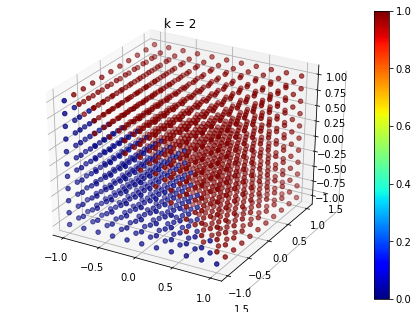

(1331, 3)
965.0
Results for k>3 are the same as for k=3 because we get to the equillibrium partition before trying out other things.
If we take a deterministic heurisitc and partition_type, results are also deterministic.


In [75]:
initial_partition_type = "0"
heuristic = "GBF"
for k in ks:
    x, f = MeshGrid3dMaxCut(k, min_weight, max_weight, initial_partition_type, n_points_ax, n_iters, complexity, heuristic, sigma)
    title = "k = " + str(k)
    PlotMeshGrid3d(x, f, title)

print(x.shape)
print(np.sum(f))
print("Results for k>3 are the same as for k=3 because we get to the equillibrium partition before trying out other things.")
print("If we take a deterministic heurisitc and partition_type, results are also deterministic.")

##### Run and show results for 0 partition and RPF

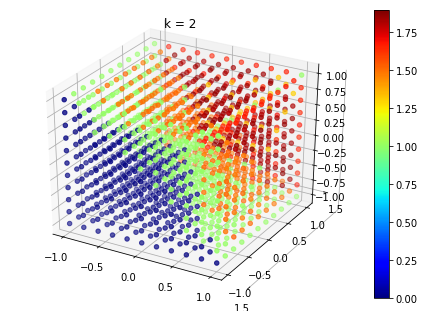

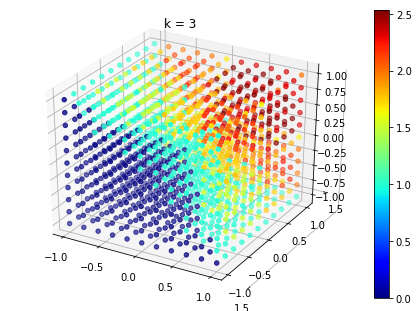

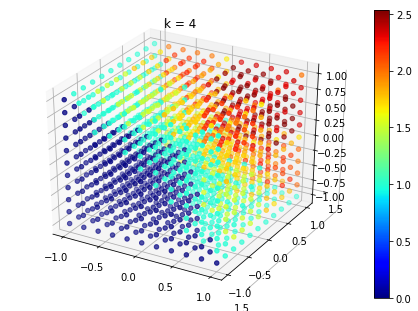

Given that the heuristic is no longer deterministic, results are somehow blurred.
However, there is a certain similiraty to the deterministic results.


In [269]:
initial_partition_type = "0"
heuristic = "RPF"
n_iters = 1000
for k in ks:
    x, f = MeshGrid3dMaxCut(k, min_weight, max_weight, initial_partition_type, n_points_ax, n_iters, complexity, heuristic, sigma)
    title = "k = " + str(k)
    PlotMeshGrid3d(x, f, title)
print("Given that the heuristic is no longer deterministic, results are somehow blurred.")
print("However, there is a certain similiraty to the deterministic results.")

##### Run and show results for 0 partition and WF

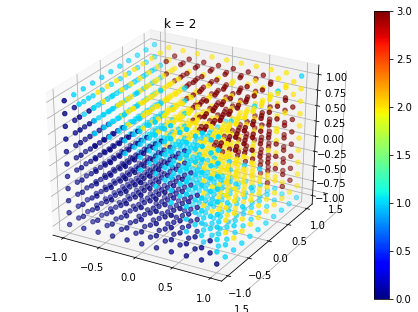

In [76]:
initial_partition_type = "0"
heuristic = "WF"
complexity = "average"
n_iters = 1
for k in ks:
    x, f = MeshGrid3dMaxCut(k, min_weight, max_weight, initial_partition_type, n_points_ax, n_iters, complexity, heuristic, sigma)
    title = "k = " + str(k)
    PlotMeshGrid3d(x, f, title)

##### Run and show results for random partition and GBF

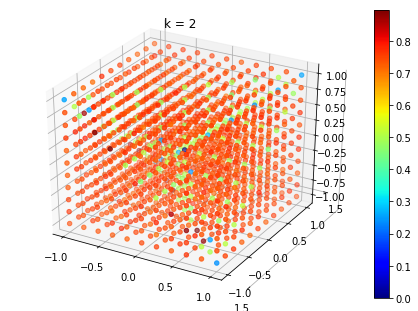

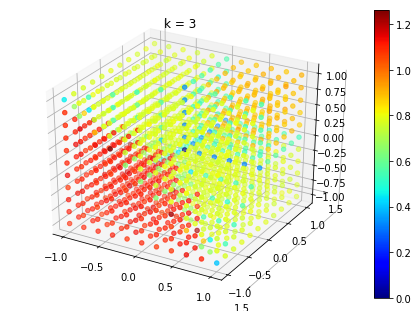

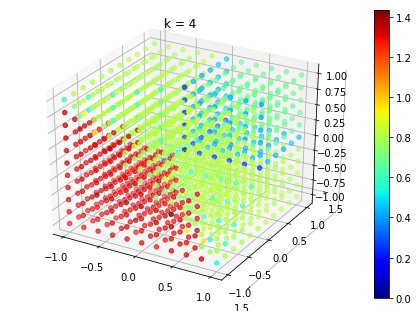

Taking now a random partition at the beginning makes everything blurrier but the structure is kept for k>3.


In [270]:
initial_partition_type = "random"
heuristic = "GBF"
n_iters = 1000
for k in ks:
    x, f = MeshGrid3dMaxCut(k, min_weight, max_weight, initial_partition_type, n_points_ax, n_iters, complexity, heuristic, sigma)
    title = "k = " + str(k)
    PlotMeshGrid3d(x, f, title)
print("Taking now a random partition at the beginning makes everything blurrier but the structure is kept for k>3.")

##### Run and show results for random partition and RPF

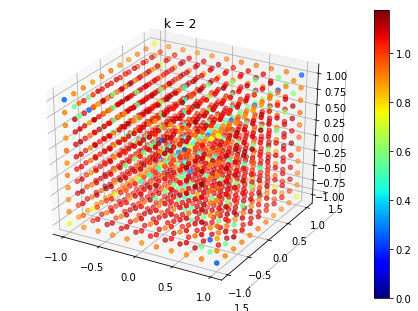

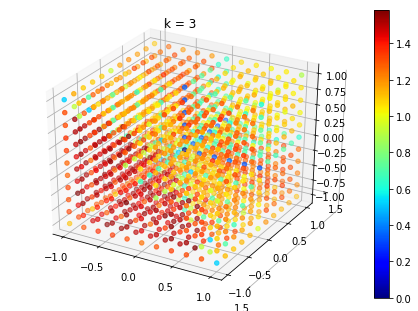

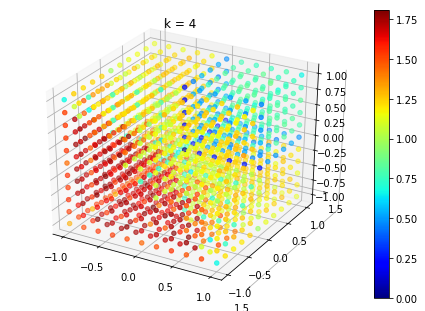

Blurry results. However similar to the previous ones.


In [271]:
initial_partition_type = "random"
heuristic = "RPF"
n_iters = 1000
for k in ks:
    x, f = MeshGrid3dMaxCut(k, min_weight, max_weight, initial_partition_type, n_points_ax, n_iters, complexity, heuristic, sigma)
    title = "k = " + str(k)
    PlotMeshGrid3d(x, f, title)
print("Blurry results. However similar to the previous ones.")

##### Run and show results for random partition and WF

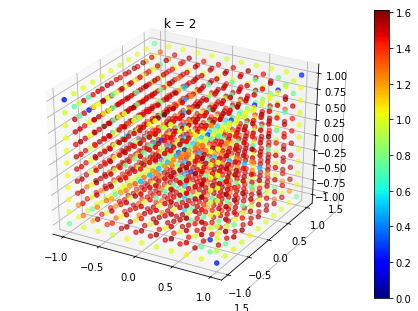

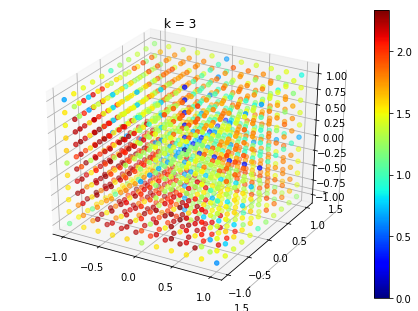

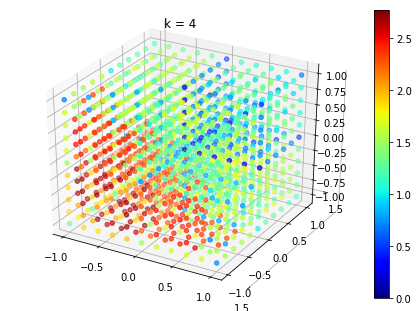

In [287]:
initial_partition_type = "random"
heuristic = "WF"
n_iters = 1000
for k in ks:
    x, f = MeshGrid3dMaxCut(k, min_weight, max_weight, initial_partition_type, n_points_ax, n_iters, complexity, heuristic, sigma)
    title = "k = " + str(k)
    PlotMeshGrid3d(x, f, title)

#### Dependency on n OK

###### Load results from local

In [78]:
nodes = CsvToNumpy("./Results/AC_N_0_RG_GBF_serial/nodes")
steps_mean = np.reshape(CsvToNumpy("./Results/AC_N_0_RG_GBF_serial/average_complexities"), (len(nodes), 1))
steps_sd = np.reshape(CsvToNumpy("./Results/AC_N_0_RG_GBF_serial/average_complexities_sd"), (len(nodes), 1))

###### Show results

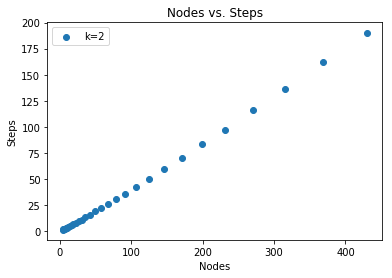

In [79]:
PlotResults(nodes, steps_mean, steps_sd, True, [2], 'k')

###### Polynomial behavior

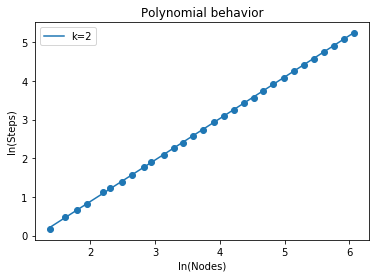

Regression results:

  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    1.074       -1.267      1.000


In [80]:
slopes, intercepts = PlotRegressionResults(nodes, steps_mean, steps_sd, False, [2], 'k', "polynomial")

#### Dependency on initial partition ok

##### Load results from LRZ

In [278]:
nodes_random = CsvToNumpy("./Results/Serial/AC_N_random_RG_GBF_serial/nodes")
steps_mean_random = np.reshape(CsvToNumpy("./Results/Serial/AC_N_random_RG_GBF_serial/average_complexities"), (len(nodes_random), 1))
steps_sd_random = np.reshape(CsvToNumpy("./Results/Serial/AC_N_random_RG_GBF_serial/average_complexities_sd"), (len(nodes_random), 1))

nodes_0 = CsvToNumpy("./Results/Serial/AC_N_0_RG_GBF_serial/nodes")
steps_mean_0 = np.reshape(CsvToNumpy("./Results/Serial/AC_N_0_RG_GBF_serial/average_complexities"), (len(nodes_0), 1))
steps_sd_0 = np.reshape(CsvToNumpy("./Results/Serial/AC_N_0_RG_GBF_serial/average_complexities_sd"), (len(nodes_0), 1))

##### Show results

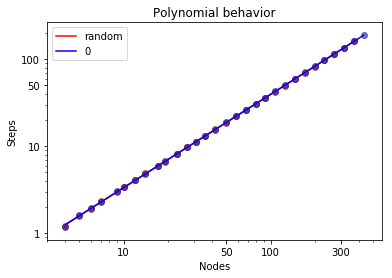

Regression results:

random
  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    1.073       -1.261      1.000
0
  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    1.074       -1.267      1.000


In [289]:
PlotTwoRegressionResults(nodes_random, steps_mean_random, steps_sd_random, nodes_0, steps_mean_0, steps_sd_0, 
                         True, [2], 'k', 'polynomial', ["random", "0"])

#### Dependency on k OK

##### Load results from LRZ

In [298]:
nodes = CsvToNumpy("./Results/Serial/AC_K_0/nodes")
steps_mean = np.reshape(CsvToNumpy("./Results/Serial/AC_K_0/average_complexities"), (len(nodes), 4))
#steps_sd = CsvToNumpy("./Results/Serial/AC_N_0/steps_sd")

##### Show results

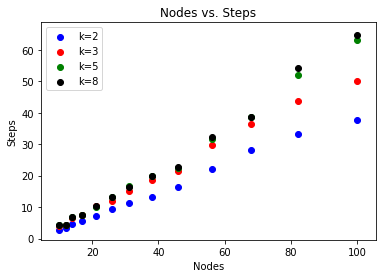

In [299]:
PlotResults(nodes, steps_mean, steps_sd, False, [2,3,5,8], 'k')

##### Polynomial behavior

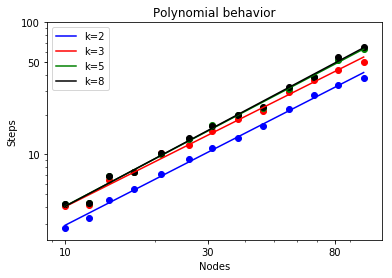

Regression results:

  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    1.156       -1.592      0.998
  3    1.133       -1.215      0.996
  5    1.189       -1.334      0.997
  8    1.201       -1.365      0.997


In [304]:
slopes, intercepts = PlotRegressionResults(nodes, steps_mean, steps_sd, False, [2,3,5,8], 'k', "polynomial")

#### Dependency on heuristics OK

##### Main parameters

In [247]:
## Define grid parameters
# Nodes
min_nodes = 5
max_nodes = 80
num_nodes = 10

# Dropout assumed to be 0
dropout = 0

min_weight = 0
max_weight = 1

# K-cuts
k=2

# Number of instances for each combination
iters_for_nk=50

# Method
methods = ["GBF", "RPF", "WF"]

# Initial partition
initial_partition_type = "0"

##### Run

In [248]:
steps_mean, steps_sd, max_cuts, max_cuts_sd, nodes = RunGridMaxCutAverageHeuristics(
    min_nodes, max_nodes, num_nodes, initial_partition_type, dropout, k, min_weight, max_weight, iters_for_nk, methods)

##### Show results

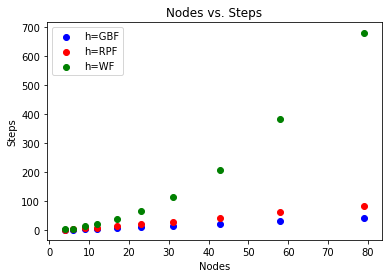

In [249]:
PlotResults(nodes, steps_mean, steps_sd, False, methods, 'h')

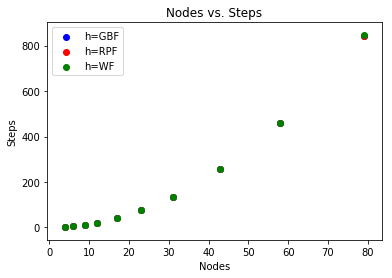

[[  2.38935164   2.35140477   2.16258062]
 [  5.33363063   5.10034534   5.02285089]
 [ 12.20823317  11.83598573  11.80837112]
 [ 21.33726049  20.75786778  20.6140207 ]
 [ 41.46514333  41.25153965  41.05733827]
 [ 75.29105745  74.95688323  74.60670032]
 [134.82599989 134.09874515 134.00951353]
 [256.20034623 255.25079147 256.11949819]
 [461.02384021 461.39580881 460.98401823]
 [843.58562785 844.28873302 845.74723904]]


In [250]:
PlotResults(nodes, max_cuts, max_cuts_sd, False, methods, 'h')
print(max_cuts)

##### Polynomial behavior

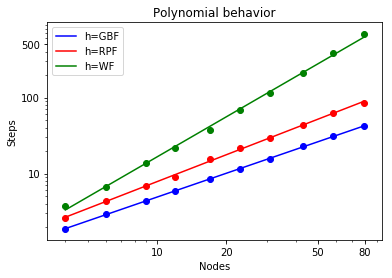

Regression results:

h      slope    intercept    r_value
---  -------  -----------  ---------
GBF    1.041       -0.809      1.000
RPF    1.175       -0.649      0.999
WF     1.752       -1.228      0.999


In [261]:
slopes, intercepts = PlotRegressionResults(nodes, steps_mean, steps_sd, False, methods, 'h', "polynomial")

###### Negative weights allowed

In [255]:
## Define grid parameters
# Nodes
min_nodes = 5
max_nodes = 80
num_nodes = 10

# Dropout assumed to be 0
dropout = 0

min_weight = -1
max_weight = 1

# K-cuts
k=2

# Number of instances for each combination
iters_for_nk=50

# Method
methods = ["GBF", "RPF", "WF"]

# Initial partition
initial_partition_type = "0"

In [256]:
steps_mean_n, steps_sd_n, nodes_n = RunGridMaxCutAverageHeuristics(
    min_nodes, max_nodes, num_nodes, initial_partition_type, dropout, k, min_weight, max_weight, iters_for_nk, methods)

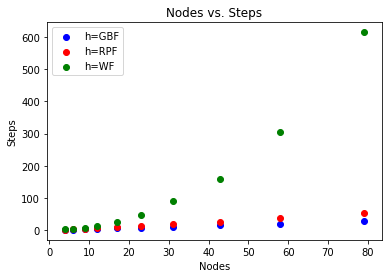

In [257]:
PlotResults(nodes_n, steps_mean_n, steps_sd_n, False, methods, 'h')

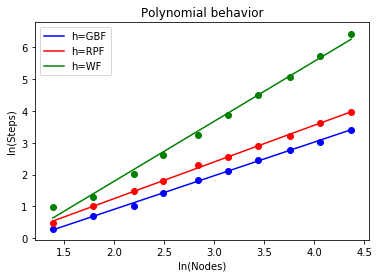

Regression results:

h      slope    intercept    r_value
---  -------  -----------  ---------
GBF    1.056       -1.205      0.999
RPF    1.153       -1.061      0.999
WF     1.885       -1.980      0.997


In [258]:
slopes, intercepts = PlotRegressionResults(nodes_n, steps_mean_n, steps_sd_n, False, methods, 'h', "polynomial")

#### Dependency on structure OK

##### Main parameters

In [9]:
## Define grid parameters
# Nodes
min_nodes = 9
max_nodes = 70
num_nodes = 10

# Dropout assumed to be 0
dropout = 0

min_weight = -1
max_weight = 1

# K-cuts
k=2

# Number of instances for each combination
iters_for_nk=200

# Method
heuristic = "GBF"

# Structures
graph_type = "intercalate"

# Intercalation
intercalations = [0.1, 0.2, 0.3, 0.4, 0.5]

# Initial partition
initial_partition_type = "0"

##### Run

In [10]:
nodes, average_complexity, average_complexity_sd = RunGridMaxCutAverageIntercalations(min_nodes, max_nodes, num_nodes, initial_partition_type, dropout, k, min_weight, max_weight, iters_for_nk, heuristic, intercalations, storeCSV=False)

KeyboardInterrupt: 

##### Show results

In [ ]:
PlotResults(nodes, average_complexity, average_complexity_sd, True, intercalations, 'intercalation')

##### Polynomial behavior

In [ ]:
slopes, intercepts = PlotRegressionResults(nodes, average_complexity, average_complexity_sd, True, intercalations, 'int_step', "polynomial")

#### Approximation guarantee

In [45]:
nodes = np.linspace(8, 20, num=10)
# Remove decimal part
nodes = np.floor(nodes)
# Convert to integer
nodes = nodes.astype(int)
iters = 100
min_weight = -1
max_weight = 1
heuristics = ["GBF", "RPF", "WF"]
k = 2
initial_partition = "0"
dropout = 0

In [51]:
nodes = CsvToNumpy("./Results/DA/Ratios_gurobi_200/nodes")
average_ratios = np.reshape(CsvToNumpy("./Results/DA/Ratios_gurobi_200/average_ratios"), (len(nodes), 3))
average_ratios_sd = np.reshape(CsvToNumpy("./Results/DA/Ratios_gurobi_200/average_ratios_sd"), (len(nodes), 3))
n = 50
average_ratios_se = average_ratios_sd/np.sqrt(n)

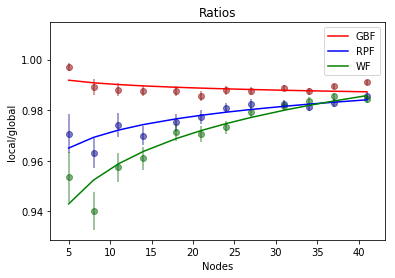

Regression results:

h      slope    intercept    r_value
---  -------  -----------  ---------
G     -0.002       -0.005     -0.497
h      slope    intercept    r_value
---  -------  -----------  ---------
R      0.009       -0.051      0.883
h      slope    intercept    r_value
---  -------  -----------  ---------
W      0.021       -0.093      0.930


In [52]:
PlotThreeRegressionResults(nodes, average_ratios[:,0], average_ratios_se[:,0], nodes, average_ratios[:,1], average_ratios_se[:,1], nodes, average_ratios[:,2], average_ratios_se[:,2],
                               True, heuristics, "h", "lineal", ["GBF", "RPF", "WF"])

#### Find worst instance

In [26]:
n = 5
iters = 500
min_weight = -1
max_weight = 1
heuristic = "GBF"
k = 2
initial_partition_type = "0"
dropout = 0

In [27]:
worst_graph, max_steps = FindWorstInstance(n, initial_partition_type, dropout, k, min_weight, max_weight, iters, heuristic, storeCSV=True)

(10, array([4., 3., 3., ..., 6., 3., 4.]))

In [37]:
n_steps = np.reshape(CsvToNumpy("./Results/DA/WorstInstance/n_steps"), (iters, 1))
worst_instance = CsvToNumpy("./Results/DA/WorstInstance/worst_instance")
cumulated_max = np.maximum.accumulate(n_steps)

Weight statistics

  n    mean    median    std    min_weight    max_weight
---  ------  --------  -----  ------------  ------------
 14   0.175     0.274  0.547        -0.989         0.999


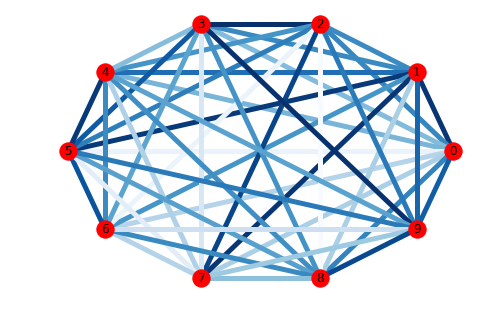

In [40]:
WeightsStats(worst_instance)
PlotGraph(worst_instance)

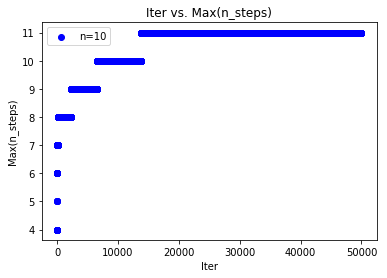

In [41]:
PlotResults(np.asarray(range(iters)), cumulated_max, [], False, [n], "n", "Iter", "Max(n_steps)")

#### Stochastic Block Model

In [18]:
# Number of nodes
min_nodes = 10
max_nodes = 60
num_nodes = 11

initial_partition_type = "0"
# Number of partitions (k-cut)
k = 2

# Define min weight and max weight of the graph
min_weight=-1
max_weight=1

iters_for_nk = 300
# Dropout
dropout = 0
heuristic = "GBF"

graph_structures = ["assortative", "disassortative", "ordered", "core-periphery"]

steps_mean, steps_sd, max_cut_mean, max_cut_sd, steps_max, nodes = RunGridMaxCutAverageSBM(min_nodes, max_nodes, num_nodes, initial_partition_type, dropout, k, min_weight, max_weight, iters_for_nk, heuristic, graph_structures)

[10 11 14 17 20 24 29 35 41 50 59]
[[ 2.  1.  6.  1.]
 [ 4.  3.  7.  4.]
 [ 4.  8.  8.  6.]
 [ 9.  8. 11.  9.]
 [11. 10. 12. 11.]
 [13. 11. 13. 13.]
 [16. 13. 15. 16.]
 [21. 19. 19. 18.]
 [23. 20. 22. 20.]
 [27. 26. 27. 25.]
 [32. 28. 33. 30.]]


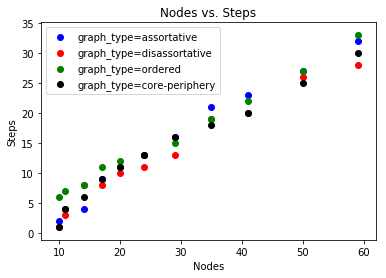

In [19]:
print(nodes)
print(steps_max)
PlotResults(nodes, steps_max, [], False, graph_structures, 'graph_type')

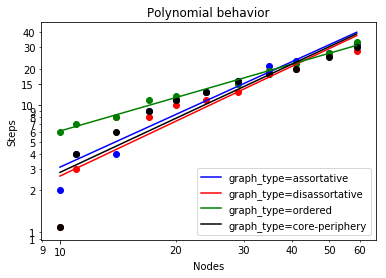

Regression results:

graph_type        slope    intercept    r_value
--------------  -------  -----------  ---------
assortative       1.439       -2.182      0.965
disassortative    1.499       -2.489      0.913
ordered           0.914       -0.289      0.995
core-periphery    1.478       -2.371      0.910


In [20]:
slopes, intercepts = PlotRegressionResults(nodes, steps_max, [], False, graph_structures, "graph_type", "polynomial")

### Partial graph

#### Dependency on dropout OK

##### Main parameters

In [342]:
# Nodes
min_nodes = 9
max_nodes = 80
num_nodes = 12

#min_weight and max_weight
min_weight=-1
max_weight=1

# List of dropouts
dropouts = dropouts = [0, 0.2, 0.4, 0.6, 0.8]

# K-cut
k=2

# Number of instances for each combination
iters_for_nk=300

# Method
heuristic = "GBF"

# Initial partition
initial_partition_type = "0"

##### Run

In [343]:
steps_mean, steps_sd, nodes = RunGridMaxCutAverageDropout(
    min_nodes, max_nodes, num_nodes, initial_partition_type, dropouts, k, min_weight, max_weight, iters_for_nk, heuristic)

##### Show results

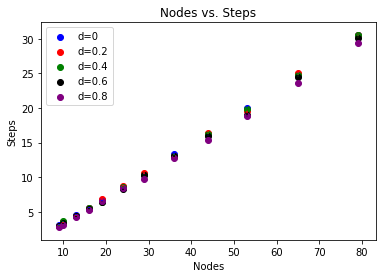

In [344]:
PlotResults(nodes, steps_mean, steps_sd, True, dropouts, 'd')

##### Polynomial behavior

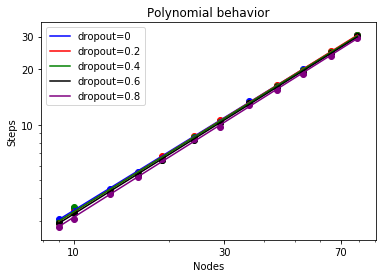

Regression results:

  dropout    slope    intercept    r_value
---------  -------  -----------  ---------
    0.000    1.053       -1.191      1.000
    0.200    1.066       -1.241      1.000
    0.400    1.061       -1.228      1.000
    0.600    1.067       -1.269      1.000
    0.800    1.078       -1.332      1.000


In [345]:
slopes, intercepts = PlotRegressionResults(nodes, steps_mean, steps_sd, True, dropouts, 'dropout', "polynomial")
# In the beginning there are many ill-posed graphs (single vertices or not connected components...)

#### Dependency on the vertices degree

##### Main parameters

In [140]:
# Nodes
min_nodes = 5
max_nodes = 150
num_nodes = 15

#min_weight and max_weight
min_weight=-1
max_weight=1

# List of degrees
degrees = np.round(np.linspace(0,0.9,5),2)

# K-cut
k=2

# Number of instances for each combination
iters_for_nk=60

# Method
heuristic = "GBF"

# Initial partition
initial_partition_type = "0"

##### Load results

In [141]:
nodes = CsvToNumpy("./Results/AC_DG_0/nodes")
steps_mean = np.reshape(CsvToNumpy("./Results/AC_DG_0/average_complexities"), (len(nodes), 5))

##### Show results

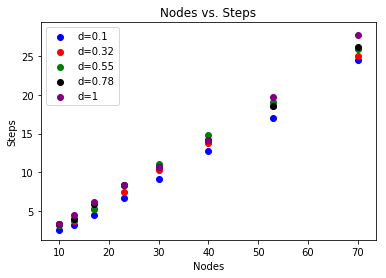

In [142]:
PlotResults(nodes, steps_mean, [], False, [0.1,0.32,0.55,0.78,1], 'd')

##### Polynomial behavior

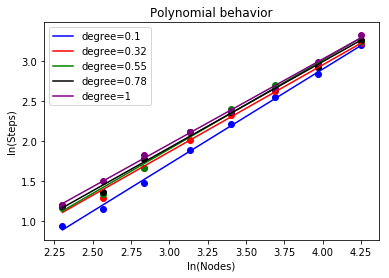

Regression results:

  degree    slope    intercept    r_value
--------  -------  -----------  ---------
   0.100    1.183       -1.832      0.999
   0.320    1.085       -1.391      0.997
   0.550    1.110       -1.428      0.998
   0.780    1.075       -1.308      0.998
   1.000    1.063       -1.228      0.999


In [143]:
slopes, intercepts = PlotRegressionResults(nodes, steps_mean, [], False, [0.1,0.32,0.55,0.78,1], 'degree', "polynomial")

## Smoothed complexity

### Main functions

In [109]:
from scipy.optimize import basinhopping

def MaxCutAllAdjacencyMatrices(n, initial_partition_type, k, min_weight, max_weight, n_tries, heuristic, storeCSV=False):

    # Create nodes grid
    n_instances = np.power(2, n)
    steps_mean = []
    steps_sd = []
    steps_max = []
    instances = []
    
    # Define the size of the weights vector
    weights_size = int(n*(n-1)/2)
    # Get all possible adjacencies
    adjMats = GetAllPossibleAdjacencyFlatMatrixes(weights_size)
    instance_counter = 0
    # Set current max number of steps
    current_max = 0
    i = 0
    j = 0
    for adjMat in adjMats:
        # Convert to symmetric matrix and check for connectivity
        sym_adjMat = SymmetricMatrix(adjMat)
        simpleG = nx.from_numpy_matrix(sym_adjMat)
        if not nx.is_connected(simpleG):
            continue
        instances.append(sym_adjMat)
        instance_counter += 1
        steps = np.zeros(n_tries)
        for it in range(n_tries):
            # Create graph and initial partition
            W = InitializeFlatGraph(weights_size, min_weight, max_weight, 0)
            W_it = np.multiply(W, adjMat)
            W_it = SymmetricMatrix(W_it)
            initial_partition = GetInitialPartition(n, k, initial_partition_type)
            # Get initial cost value
            initial_z = CutCost(W_it, initial_partition, n, k)
            # Get next local maximum
            partition, z, elapsed_time, n_steps = SolveMaxCut(W_it, n, k, initial_z, initial_partition, heuristic)
            # Save results for each iteration
            steps[it]=n_steps
            if n_steps > current_max:
                worstGraph = W_it
                current_max = n_steps

        # Save results for a i,j combination    
        steps_mean.append(np.mean(steps))
        steps_sd.append(np.std(steps)/np.sqrt(n_tries))
        new_max = np.max(steps)
        steps_max.append(new_max)
    if storeCSV:
        DeleteTempResults("worst_instance.csv")
        NumpyToCsv(worstGraph, "worst_instance")
        DeleteTempResults("steps_mean.csv")
        NumpyToCsv(steps_mean, "steps_mean")
        DeleteTempResults("steps_max.csv")
        NumpyToCsv(steps_max, "steps_max")
        DeleteTempResults("instances.pkl")
        output = open('instances.pkl', 'wb')
        pickle.dump(instances, output)
        output.close()
    return steps_mean, steps_sd, steps_max, worstGraph

def SmoothedComplexity(W, n, k, initial_partition_type, dropout, iters_for_perturbation, heuristic, sigma):
    ####### IMPORTANT ########
    # It always returns the NEGATIVE smoothed complexity #
    steps = np.zeros(iters_for_perturbation)
    if np.asarray(W).ndim==1:
        W = np.copy(SymmetricMatrix(W))
    for it in range(iters_for_perturbation):
        # Create weight matrix
        W_k_it = np.copy(W)
        # Add perturbation
        if sigma > 0:
            # Keep structure! Do not perturbate dropouted edges!
            structure = np.nonzero(W_k_it)
            perturbation = np.random.normal(loc=0, scale=sigma, size=(n,n))
            W_k_it[structure] += perturbation[structure]
        # Make sure that the elements are in range (-1, 1)
        W_k_it[W_k_it > 1] = 1
        W_k_it[W_k_it < -1] = -1
        # Copy upper diagonal to lower diagonal (only the upper perturbation counts)
        i_lower = np.tril_indices(n, -1)
        W_k_it[i_lower] = np.copy(W_k_it.T[i_lower])
        # Make sure that diagonal is 0
        np.fill_diagonal(W_k_it, 0)
        # Get initial partition randomly
        initial_partition = GetInitialPartition(n, k, initial_partition_type)
        # Get initial cost value
        initial_z = CutCost(W_k_it, initial_partition, n, k)
        # Get next local maximum
        partition, z, elapsed_time, n_steps = SolveMaxCut(W_k_it, n, k, initial_z, initial_partition, heuristic)
        # Save results
        # times += elapsed_time
        steps[it]=n_steps
        # Think of another measure of the gap
    step_means = np.mean(steps)
    return -1*step_means

def CallbackOptimization(zi, xi, context):
    global callback_iter
    print(callback_iter, ";", xi)
    callback_iter += 1
    return

def OptimizationSmoothedComplexityK(min_nodes, max_nodes, step_nodes, initial_partition_type, ks, dropout, 
                                  min_weight, max_weight, n_perturbations, heuristic, sigma, n_iterations, algorithm, storeCSV=False):
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    smoothed_complexities = np.zeros((len(nodes), len(ks)))
    # Save nodes
    if storeCSV:
        NumpyToCsv(nodes, "nodes")
    # Running variables
    i = 0
    j = 0
    
    for ni in nodes:
        # Define weight size (upper diagonal)
        weights_size = int(ni*(ni-1)/2)
        # Create boundaries
        bound = (-1., 1.)
        bounds = []
        for m in range(weights_size):
            bounds.append(bound)
        bounded_step = RandomDisplacementBounds(np.array([b[0] for b in bounds]), np.array([b[1] for b in bounds]))
        for ki in ks:
            #Initial guess of size ni(ni-1)/2
            W0 = InitializeFlatGraph(weights_size, -1, 1, dropout)
            # Initialize kwargs
            if algorithm == "basinhopping":
                from scipy.optimize import basinhopping
                minimizer_kwargs = {"args": (ni, ki, initial_partition_type, dropout, n_perturbations, heuristic, sigma), "bounds": bounds}
                ret = basinhopping(SmoothedComplexity, W0, disp = True, minimizer_kwargs=minimizer_kwargs, niter_success=n_iterations, take_step=bounded_step)
            elif algorithm == "differential_evolution":
                minimizer_kwargs = [ni, ki, initial_partition_type, dropout, n_perturbations, heuristic, sigma]
                from scipy.optimize import differential_evolution
                ret = differential_evolution(SmoothedComplexity, bounds = bounds, disp = True, args=minimizer_kwargs, workers = 3)
            elif algorithm == "dual_annealing":
                minimizer_kwargs = [ni, ki, initial_partition_type, dropout, n_perturbations, heuristic, sigma]
                from scipy.optimize import dual_annealing
                ret = dual_annealing(SmoothedComplexity, bounds = bounds, args=minimizer_kwargs, maxiter=n_iterations, callback=CallbackOptimization)
            else: #local minimum
                minimizer_kwargs = (ni, ki, initial_partition_type, dropout, n_perturbations, heuristic, sigma)
                from scipy.optimize import minimize
                ret = minimize(SmoothedComplexity, W0, args=minimizer_kwargs, method=algorithm, bounds=bounds)
            smoothed_complexities[i, j] = ret.fun
            if storeCSV:
                DeleteTempResults("smoothed_complexities.csv")
                NumpyToCsv(smoothed_complexities, "smoothed_complexities")
            j = j + 1
        j = 0
        i = i + 1
    return nodes, -1*smoothed_complexities

def OptimizationSmoothedComplexityHeuristics(min_nodes, max_nodes, step_nodes, initial_partition_type, k, dropout, 
                                  min_weight, max_weight, n_perturbations, heuristics, sigma, n_iterations, algorithm, storeCSV=False):
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    smoothed_complexities = np.zeros((len(nodes), len(heuristics)))
    # Save nodes
    if storeCSV:
        NumpyToCsv(nodes, "nodes")
    # Running variables
    i = 0
    j = 0
    
    for ni in nodes:
        # Define weight size (upper diagonal)
        weights_size = int(ni*(ni-1)/2)
        # Create boundaries
        bound = (-1., 1.)
        bounds = []
        for m in range(weights_size):
            bounds.append(bound)
        bounded_step = RandomDisplacementBounds(np.array([b[0] for b in bounds]), np.array([b[1] for b in bounds]))
        for heuristic in heuristics:
            #Initial guess of size ni(ni-1)/2
            W0 = InitializeFlatGraph(weights_size, -1, 1, dropout)
            # Initialize kwargs
            if algorithm == "basinhopping":
                from scipy.optimize import basinhopping
                minimizer_kwargs = {"args": (ni, k, initial_partition_type, dropout, n_perturbations, heuristic, sigma), "bounds": bounds}
                ret = basinhopping(SmoothedComplexity, W0, disp = True, minimizer_kwargs=minimizer_kwargs, niter_success=n_iterations, take_step=bounded_step)
            elif algorithm == "differential_evolution":
                minimizer_kwargs = [ni, k, initial_partition_type, dropout, n_perturbations, heuristic, sigma]
                from scipy.optimize import differential_evolution
                ret = differential_evolution(SmoothedComplexity, bounds = bounds, disp = True, args=minimizer_kwargs, workers = 3)
            elif algorithm == "dual_annealing":
                minimizer_kwargs = [ni, k, initial_partition_type, dropout, n_perturbations, heuristic, sigma]
                from scipy.optimize import dual_annealing
                ret = dual_annealing(SmoothedComplexity, bounds = bounds, args=minimizer_kwargs, maxiter=n_iterations)
            else: #local minimum
                minimizer_kwargs = (ni, k, initial_partition_type, dropout, n_perturbations, heuristic, sigma)
                from scipy.optimize import minimize
                ret = minimize(SmoothedComplexity, W0, args=minimizer_kwargs, method=algorithm, bounds=bounds)
            smoothed_complexities[i, j] = ret.fun
            if storeCSV:
                DeleteTempResults("smoothed_complexities.csv")
                NumpyToCsv(smoothed_complexities, "smoothed_complexities")
            j = j + 1
        j = 0
        i = i + 1
    return nodes, -1*smoothed_complexities

def OptimizationSmoothedComplexityDropouts(min_nodes, max_nodes, step_nodes, initial_partition_type, k, dropouts, 
                                  min_weight, max_weight, n_perturbations, heuristic, sigma, n_iterations, algorithm, storeCSV=False):
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    smoothed_complexities = np.zeros((len(nodes), len(dropouts)))
    # Save nodes
    if storeCSV:
        NumpyToCsv(nodes, "nodes")
    # Running variables
    i = 0
    j = 0
    
    for ni in nodes:
        # Define weight size (upper diagonal)
        weights_size = int(ni*(ni-1)/2)
        # Create boundaries
        bound = (-1., 1.)
        bounds = []
        for m in range(weights_size):
            bounds.append(bound)
        bounded_step = RandomDisplacementBounds(np.array([b[0] for b in bounds]), np.array([b[1] for b in bounds]))
        for dropout in dropouts:
            #Initial guess of size ni(ni-1)/2
            W0 = InitializeFlatGraph(weights_size, -1, 1, dropout)
            # Initialize kwargs
            if algorithm == "basinhopping":
                from scipy.optimize import basinhopping
                minimizer_kwargs = {"args": (ni, k, initial_partition_type, dropout, n_perturbations, heuristic, sigma), "bounds": bounds}
                ret = basinhopping(SmoothedComplexity, W0, disp = True, minimizer_kwargs=minimizer_kwargs, niter_success=n_iterations, take_step=bounded_step)
            elif algorithm == "differential_evolution":
                minimizer_kwargs = [ni, k, initial_partition_type, dropout, n_perturbations, heuristic, sigma]
                from scipy.optimize import differential_evolution
                ret = differential_evolution(SmoothedComplexity, bounds = bounds, disp = True, args=minimizer_kwargs, workers = 3)
            elif algorithm == "dual_annealing":
                minimizer_kwargs = [ni, k, initial_partition_type, dropout, n_perturbations, heuristic, sigma]
                from scipy.optimize import dual_annealing
                ret = dual_annealing(SmoothedComplexity, bounds = bounds, args=minimizer_kwargs, maxiter=n_iterations)
            else: #local minimum
                minimizer_kwargs = (ni, k, initial_partition_type, dropout, n_perturbations, heuristic, sigma)
                from scipy.optimize import minimize
                ret = minimize(SmoothedComplexity, W0, args=minimizer_kwargs, method=algorithm, bounds=bounds)
            smoothed_complexities[i, j] = ret.fun
            if storeCSV:
                DeleteTempResults("smoothed_complexities.csv")
                NumpyToCsv(smoothed_complexities, "smoothed_complexities")
            j = j + 1
        j = 0
        i = i + 1
    return nodes, -1*smoothed_complexities

def OptimizationSmoothedComplexitySigmas(min_nodes, max_nodes, step_nodes, initial_partition_type, k, dropout, 
                                  min_weight, max_weight, n_perturbations, heuristic, sigmas, n_iterations, algorithm, storeCSV=False):
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    smoothed_complexities = np.zeros((len(nodes), len(sigmas)))
    # Save nodes
    if storeCSV:
        NumpyToCsv(nodes, "nodes")
    # Running variables
    i = 0
    j = 0
    
    for ni in nodes:
        # Define weight size (upper diagonal)
        weights_size = int(ni*(ni-1)/2)
        # Create boundaries
        bound = (-1., 1.)
        bounds = []
        for m in range(weights_size):
            bounds.append(bound)
        bounded_step = RandomDisplacementBounds(np.array([b[0] for b in bounds]), np.array([b[1] for b in bounds]))
        for sigma in sigmas:
            #Initial guess of size ni(ni-1)/2
            W0 = InitializeFlatGraph(weights_size, -1, 1, dropout)
            # Initialize kwargs
            if algorithm == "basinhopping":
                from scipy.optimize import basinhopping
                minimizer_kwargs = {"args": (ni, k, initial_partition_type, dropout, n_perturbations, heuristic, sigma), "bounds": bounds}
                ret = basinhopping(SmoothedComplexity, W0, disp = True, minimizer_kwargs=minimizer_kwargs, niter_success=n_iterations, take_step=bounded_step)
            elif algorithm == "differential_evolution":
                minimizer_kwargs = [ni, k, initial_partition_type, dropout, n_perturbations, heuristic, sigma]
                from scipy.optimize import differential_evolution
                ret = differential_evolution(SmoothedComplexity, bounds = bounds, disp = True, args=minimizer_kwargs, workers = 3)
            elif algorithm == "dual_annealing":
                minimizer_kwargs = [ni, k, initial_partition_type, dropout, n_perturbations, heuristic, sigma]
                from scipy.optimize import dual_annealing
                ret = dual_annealing(SmoothedComplexity, bounds = bounds, args=minimizer_kwargs, maxiter=n_iterations)
            else: #local minimum
                minimizer_kwargs = (ni, k, initial_partition_type, dropout, n_perturbations, heuristic, sigma)
                from scipy.optimize import minimize
                ret = minimize(SmoothedComplexity, W0, args=minimizer_kwargs, method=algorithm, bounds=bounds)
            smoothed_complexities[i, j] = ret.fun
            if storeCSV:
                DeleteTempResults("smoothed_complexities.csv")
                NumpyToCsv(smoothed_complexities, "smoothed_complexities")
            j = j + 1
        j = 0
        i = i + 1
    return nodes, -1*smoothed_complexities

def RandomGridSmoothedComplexityK(min_nodes, max_nodes, step_nodes, initial_partition_type, ks, dropout, 
                                  min_weight, max_weight, iters_for_nk, iters_for_w, heuristic, 
                                  sigma, plotMaxEvolution = False, plotWorstGraph = False, storeCSV=False):
    
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    step_means = np.zeros(iters_for_w)
    smoothed_complexities = np.zeros((len(nodes), len(ks)))
    # Save nodes
    if storeCSV:
        NumpyToCsv(nodes, "nodes")
       
    # Running variables
    i = 0
    j = 0
    
    for ni in nodes:
        # Define weight size (upper diagonal)
        weights_size = int(ni*(ni-1)/2)
        for ki in ks:
            best_results_so_far = np.zeros(iters_for_w)
            for w in range(iters_for_w):
                W = InitializeFlatGraph(weights_size, min_weight, max_weight, dropout)
                # Perform a dropout
                if dropout>0:
                    D = np.random.choice([0,1], size=weights_size, replace=True, p=[dropout, 1-dropout])
                    W = np.multiply(W,D)
                structure = np.nonzero(W)
                if plotWorstGraph and w == 0:
                    print("First graph\n")
                    WeightsStats(W)
                    PlotGraph(SymmetricMatrix(W))
                    PlotWeightsHistogram(W)
                # Initialize results
                steps = np.zeros(iters_for_nk)
                for nk in range(iters_for_nk):
                    # Create perturbation
                    perturbation = np.random.normal(loc=0, scale=sigma, size=weights_size)
                    W_k_it = np.copy(W)
                    W_k_it[structure] = W_k_it[structure] + perturbation[structure]        
                    # Convert to symmetric matrix
                    W_k_it = SymmetricMatrix(W_k_it)
                    # Get initial partition randomly
                    initial_partition = GetInitialPartition(ni, ki, initial_partition_type)
                    # Get initial cost value
                    initial_z = CutCost(W_k_it, initial_partition, ni, ki)
                    # Get next local maximum
                    partition, z, elapsed_time, n_steps = SolveMaxCut(W_k_it, ni, ki, initial_z, initial_partition, heuristic)
                    # Save results
                    # times += elapsed_time
                    steps[nk]=n_steps
                    # Think of another measure of the gap
                step_means[w] = np.mean(steps)
                # Store values for plotResults
                
                if w == 0:
                    best_results_so_far[0] = step_means[0]
                    worstGraph = W
                else:
                    best_results_so_far[w] = max(step_means[w], best_results_so_far[w-1])
                    if step_means[w]>best_results_so_far[w-1]:
                        worstGraph = W
            # Plot results if required
            if plotMaxEvolution:
                PlotResults(np.asarray(range(iters_for_w)), np.reshape(best_results_so_far, (iters_for_w, 1)), [], 
                            False, [ni], "n", "Iter", "S.C.")
                PlotResults(np.asarray(range(iters_for_w)), np.reshape(step_means, (iters_for_w, 1)), [], 
                            False, [ni], "n", "Iter", "A.C.")
            if plotWorstGraph:
                print("Worst graph\n")
                WeightsStats(worstGraph)
                PlotGraph(SymmetricMatrix(worstGraph))
                PlotWeightsHistogram(worstGraph)
                
            smoothed_complexities[i,j] = np.max(step_means)
            print("Best result for n=" + str(ni) + " and k=" + str(ki) + " is " + str(smoothed_complexities[i,j]))
            if storeCSV:
                DeleteTempResults("smoothed_complexities.csv")
                NumpyToCsv(smoothed_complexities, "smoothed_complexities")
            j = j + 1
        i = i + 1
        j = 0        
    
    return nodes, smoothed_complexities

def RandomGridSmoothedComplexityWorstStructure(n, initial_partition_type, k, dropouts, 
                                  min_weight, max_weight, tries, tries_in_dropout, n_perturbations, heuristic, 
                                  sigma, graph_type = "complete", plotMaxEvolution = False, plotWorstGraph = False):
    
    # Store results
    step_means = np.zeros(n_perturbations)
    smoothed_complexities = np.zeros(len(dropouts))
    
    worst_graph = 0
    worst_sc = 0
    all_sc = []
    all_worst_sc = []
    # Running variables
    i = 0
    j = 0
    
    weights_size = int(n*(n-1)/2)
    for d in dropouts:
        for t in range(tries):
            if d>0:
                D = np.random.choice([0,1], size=weights_size, replace=True, p=[d, 1-d])        
            for t_d in range(tries_in_dropout):
                W = InitializeFlatGraph(weights_size, min_weight, max_weight, 0)
                # Perform a dropout
                if d>0:
                    W = np.multiply(W,D)
                structure = np.nonzero(W)
                steps = np.zeros(n_perturbations)
                for w in range(n_perturbations):
                    # Create perturbation
                    perturbation = np.random.normal(loc=0, scale=sigma, size=weights_size)
                    W_k_it = np.copy(W)
                    W_k_it[structure] = W_k_it[structure] + perturbation[structure]
                    # Convert to symmetric matrix
                    W_k_it = SymmetricMatrix(W_k_it)
                    # Get initial partition randomly
                    initial_partition = GetInitialPartition(n, k, initial_partition_type)
                    # Get initial cost value
                    initial_z = CutCost(W_k_it, initial_partition, n, k)
                    # Get next local maximum
                    partition, z, elapsed_time, n_steps = SolveMaxCut(W_k_it, n, k, initial_z, initial_partition, heuristic)
                    steps[w]=n_steps
                # Compare and store results
                if np.mean(steps)>worst_sc:
                    worstGraph = W
                worst_sc = max(np.mean(steps), worst_sc)
                all_sc.append(np.mean(steps))
                all_worst_sc.append(worst_sc)
    # Plot results if required
    if plotMaxEvolution:
        #PlotResults(np.asarray(range(len(all_sc))), np.reshape(all_sc, (len(all_sc), 1)), [], 
        #            False, [n], "n",  "A.C.", "Iter")
        plt.hist(np.asarray(all_sc), density=True)  # `density=False` would make counts
        plt.ylabel('Probability')
        plt.xlabel('Data');
        PlotResults(np.asarray(range(len(all_worst_sc))), np.reshape(all_worst_sc, (len(all_worst_sc), 1)), [], 
                    False, [n], "n","Iter", "max(n_steps)")
    if plotWorstGraph:
        print("Worst graph\n")
        WeightsStats(worstGraph)
        PlotGraph(SymmetricMatrix(worstGraph))
        PlotWeightsHistogram(worstGraph)
    return

def RandomGridSmoothedComplexityWorstStructureModulo(n, initial_partition_type, k, dropout, 
                                  min_weight, max_weight, tries, n_perturbations, heuristic, 
                                  sigma, modulos, graph_type = "modulo", plotMaxEvolution = False, plotWorstGraph = False):
    
    # Store results
    step_means = np.zeros(n_perturbations)
    smoothed_complexities = np.zeros(len(dropouts))
    
    worst_graph = 0
    worst_sc = 0
    all_sc = []
    all_worst_sc = []
    # Running variables
    i = 0
    j = 0
    
    weights_size = int(n*(n-1)/2)
    for m in modulos:
        W = InitializeFlatGraph(n, min_weight, max_weight, 0, graph_type = graph_type, modulo = m)
        for t in range(tries):
            if dropout>0:
                D = np.random.choice([0,1], size=weights_size, replace=True, p=[d, 1-d])        
                W = np.multiply(W,D)
            structure = np.nonzero(W)
            steps = np.zeros(n_perturbations)
            for w in range(n_perturbations):
                # Create perturbation
                perturbation = np.random.normal(loc=0, scale=sigma, size=weights_size)
                W_k_it = np.copy(W)
                W_k_it[structure] = W_k_it[structure] + perturbation[structure]
                # Convert to symmetric matrix
                W_k_it = SymmetricMatrix(W_k_it)
                # Get initial partition randomly
                initial_partition = GetInitialPartition(n, k, initial_partition_type)
                # Get initial cost value
                initial_z = CutCost(W_k_it, initial_partition, n, k)
                # Get next local maximum
                partition, z, elapsed_time, n_steps = SolveMaxCut(W_k_it, n, k, initial_z, initial_partition, heuristic)
                steps[w]=n_steps
            # Compare and store results
            if np.mean(steps)>worst_sc:
                worstGraph = W
            worst_sc = max(np.mean(steps), worst_sc)
            all_sc.append(np.mean(steps))
            all_worst_sc.append(worst_sc)
    # Plot results if required
    if plotMaxEvolution:
        #PlotResults(np.asarray(range(len(all_sc))), np.reshape(all_sc, (len(all_sc), 1)), [], 
        #            False, [n], "n",  "A.C.", "Iter")
        plt.hist(np.asarray(all_sc), density=True)  # `density=False` would make counts
        plt.ylabel('Probability')
        plt.xlabel('Data');
        PlotResults(np.asarray(range(len(all_worst_sc))), np.reshape(all_worst_sc, (len(all_worst_sc), 1)), [], 
                    False, [n], "n","S.C.", "Iter")
    if plotWorstGraph:
        print("Worst graph\n")
        WeightsStats(worstGraph)
        PlotGraph(SymmetricMatrix(worstGraph))
        PlotWeightsHistogram(worstGraph)
    return

def RandomGridSmoothedComplexityDropout(min_nodes, max_nodes, step_nodes, initial_partition_type, k, dropouts, 
                                  min_weight, max_weight, iters_for_nk, iters_for_w, heuristic, 
                                  sigma, plotMaxEvolution = False, plotWorstGraph = False, storeCSV=False):   
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    step_means = np.zeros(iters_for_w)
    smoothed_complexities = np.zeros((len(nodes), len(dropouts)))
    # Save nodes
    if storeCSV:
        NumpyToCsv(nodes, "nodes")
       
    # Running variables
    i = 0
    j = 0
    
    for ni in nodes:
        # Define weight size (upper diagonal)
        weights_size = int(ni*(ni-1)/2)
        for dropout in dropouts:
            best_results_so_far = np.zeros(iters_for_w)
            for w in range(iters_for_w):
                W = InitializeFlatGraph(weights_size, min_weight, max_weight, dropout)
                # Perform a dropout
                if dropout>0:
                    connected = False
                    while not connected:
                        D = np.random.choice([0,1], size=weights_size, replace=True, p=[dropout, 1-dropout])
                        W_dropped = np.multiply(W,D)
                        # Check for connectivity
                        W_sym = nx.from_numpy_matrix(SymmetricMatrix(W_dropped))
                        if nx.is_connected(W_sym):
                            connected = True
                structure = np.nonzero(W_dropped)
                if plotWorstGraph and w == 0:
                    print("First graph\n")
                    WeightsStats(W_dropped)
                    PlotGraph(SymmetricMatrix(W_dropped))
                    PlotWeightsHistogram(W_dropped)
                # Initialize results
                steps = np.zeros(iters_for_nk)
                for nk in range(iters_for_nk):
                    # Create perturbation
                    perturbation = np.random.normal(loc=0, scale=sigma, size=weights_size)
                    W_k_it = np.copy(W_dropped)
                    W_k_it[structure] = W_k_it[structure] + perturbation[structure]        
                    # Convert to symmetric matrix
                    W_k_it = SymmetricMatrix(W_k_it)
                    # Get initial partition randomly
                    initial_partition = GetInitialPartition(ni, k, initial_partition_type)
                    # Get initial cost value
                    initial_z = CutCost(W_k_it, initial_partition, ni, k)
                    # Get next local maximum
                    partition, z, elapsed_time, n_steps = SolveMaxCut(W_k_it, ni, k, initial_z, initial_partition, heuristic)
                    # Save results
                    # times += elapsed_time
                    steps[nk]=n_steps
                    # Think of another measure of the gap
                step_means[w] = np.mean(steps)
                # Store values for plotResults
                
                if w == 0:
                    best_results_so_far[0] = step_means[0]
                    worstGraph = W
                else:
                    best_results_so_far[w] = max(step_means[w], best_results_so_far[w-1])
                    if step_means[w]>best_results_so_far[w-1]:
                        worstGraph = W
            # Plot results if required
            if plotMaxEvolution:
                PlotResults(np.asarray(range(iters_for_w)), np.reshape(best_results_so_far, (iters_for_w, 1)), [], 
                            False, [ni], "n", "Iter", "S.C.")
            if plotWorstGraph:
                print("Worst graph\n")
                WeightsStats(worstGraph)
                PlotGraph(SymmetricMatrix(worstGraph))
                PlotWeightsHistogram(worstGraph)
                
            smoothed_complexities[i,j] = np.max(step_means)
            print("Best result for n=" + str(ni) + " and dropout=" + str(dropout) + " is " + str(smoothed_complexities[i,j]))
            if storeCSV:
                DeleteTempResults("smoothed_complexities.csv")
                NumpyToCsv(smoothed_complexities, "smoothed_complexities")
            j = j + 1
        i = i + 1
        j = 0        
    
    return nodes, smoothed_complexities

def RandomGridSmoothedComplexityHeuristic(min_nodes, max_nodes, step_nodes, initial_partition_type, k, dropout, 
                                  min_weight, max_weight, iters_for_nk, iters_for_w, heuristics, 
                                  sigma, plotMaxEvolution = False, plotWorstGraph = False, storeCSV=False):
    
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    step_means = np.zeros(iters_for_w)
    smoothed_complexities = np.zeros((len(nodes), len(heuristics)))
    # Save nodes
    if storeCSV:
        NumpyToCsv(nodes, "nodes")
       
    # Running variables
    i = 0
    j = 0
    
    for ni in nodes:
        # Define weight size (upper diagonal)
        weights_size = int(ni*(ni-1)/2)
        for heuristic in heuristics:
            best_results_so_far = np.zeros(iters_for_w)
            for w in range(iters_for_w):
                W = InitializeFlatGraph(weights_size, min_weight, max_weight, dropout)
                # Perform a dropout
                if dropout>0:
                    D = np.random.choice([0,1], size=weights_size, replace=True, p=[dropout, 1-dropout])
                    W = np.multiply(W,D)
                structure = np.nonzero(W)
                if plotWorstGraph and w == 0:
                    print("First graph\n")
                    WeightsStats(W)
                    PlotGraph(SymmetricMatrix(W))
                    PlotWeightsHistogram(W)
                # Initialize results
                steps = np.zeros(iters_for_nk)
                for nk in range(iters_for_nk):
                    # Create perturbation
                    perturbation = np.random.normal(loc=0, scale=sigma, size=weights_size)
                    W_k_it = np.copy(W)
                    W_k_it[structure] = W_k_it[structure] + perturbation[structure]        
                    # Convert to symmetric matrix
                    W_k_it = SymmetricMatrix(W_k_it)
                    # Get initial partition randomly
                    initial_partition = GetInitialPartition(ni, k, initial_partition_type)
                    # Get initial cost value
                    initial_z = CutCost(W_k_it, initial_partition, ni, k)
                    # Get next local maximum
                    partition, z, elapsed_time, n_steps = SolveMaxCut(W_k_it, ni, k, initial_z, initial_partition, heuristic)
                    # Save results
                    # times += elapsed_time
                    steps[nk]=n_steps
                    # Think of another measure of the gap
                step_means[w] = np.mean(steps)
                # Store values for plotResults
                
                if w == 0:
                    best_results_so_far[0] = step_means[0]
                    worstGraph = W
                else:
                    best_results_so_far[w] = max(step_means[w], best_results_so_far[w-1])
                    if step_means[w]>best_results_so_far[w-1]:
                        worstGraph = W
            # Plot results if required
            if plotMaxEvolution:
                PlotResults(np.asarray(range(iters_for_w)), np.reshape(best_results_so_far, (iters_for_w, 1)), [], 
                            False, [ni], "n", "Iter", "S.C.")
            if plotWorstGraph:
                print("Worst graph\n")
                WeightsStats(worstGraph)
                PlotGraph(SymmetricMatrix(worstGraph))
                PlotWeightsHistogram(worstGraph)
                
            smoothed_complexities[i,j] = np.max(step_means)
            print("Best result for n=" + str(ni) + " and heuristic=" + str(heuristic) + " is " + str(smoothed_complexities[i,j]))
            if storeCSV:
                DeleteTempResults("smoothed_complexities.csv")
                NumpyToCsv(smoothed_complexities, "smoothed_complexities")
            j = j + 1
        i = i + 1
        j = 0        
    
    return nodes, smoothed_complexities

def RandomGridSmoothedComplexitySigma(min_nodes, max_nodes, step_nodes, initial_partition_type, k, dropout, 
                                  min_weight, max_weight, iters_for_nk, iters_for_w, heuristic, 
                                  sigmas, plotMaxEvolution = False, plotWorstGraph = False, storeCSV=False):
    
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    step_means = np.zeros(iters_for_w)
    smoothed_complexities = np.zeros((len(nodes), len(sigmas)))
    # Save nodes
    if storeCSV:
        NumpyToCsv(nodes, "nodes")
       
    # Running variables
    i = 0
    j = 0
    
    for ni in nodes:
        # Define weight size (upper diagonal)
        weights_size = int(ni*(ni-1)/2)
        for sigma in sigmas:
            best_results_so_far = np.zeros(iters_for_w)
            for w in range(iters_for_w):
                W = InitializeFlatGraph(weights_size, min_weight, max_weight, dropout)
                # Perform a dropout
                if dropout>0:
                    D = np.random.choice([0,1], size=weights_size, replace=True, p=[dropout, 1-dropout])
                    W = np.multiply(W,D)
                structure = np.nonzero(W)
                if plotWorstGraph and w == 0:
                    print("First graph\n")
                    WeightsStats(W)
                    PlotGraph(SymmetricMatrix(W))
                    PlotWeightsHistogram(W)
                # Initialize results
                steps = np.zeros(iters_for_nk)
                for nk in range(iters_for_nk):
                    # Create perturbation
                    perturbation = np.random.normal(loc=0, scale=sigma, size=weights_size)
                    W_k_it = np.copy(W)
                    W_k_it[structure] = W_k_it[structure] + perturbation[structure]        
                    # Convert to symmetric matrix
                    W_k_it = SymmetricMatrix(W_k_it)
                    # Get initial partition randomly
                    initial_partition = GetInitialPartition(ni, k, initial_partition_type)
                    # Get initial cost value
                    initial_z = CutCost(W_k_it, initial_partition, ni, k)
                    # Get next local maximum
                    partition, z, elapsed_time, n_steps = SolveMaxCut(W_k_it, ni, k, initial_z, initial_partition, heuristic)
                    # Save results
                    # times += elapsed_time
                    steps[nk]=n_steps
                    # Think of another measure of the gap
                step_means[w] = np.mean(steps)
                # Store values for plotResults
                
                if w == 0:
                    best_results_so_far[0] = step_means[0]
                    worstGraph = W
                else:
                    best_results_so_far[w] = max(step_means[w], best_results_so_far[w-1])
                    if step_means[w]>best_results_so_far[w-1]:
                        worstGraph = W
            # Plot results if required
            if plotMaxEvolution:
                PlotResults(np.asarray(range(iters_for_w)), np.reshape(best_results_so_far, (iters_for_w, 1)), [], 
                            False, [ni], "n", "Iter", "S.C.")
            if plotWorstGraph:
                print("Worst graph\n")
                WeightsStats(worstGraph)
                PlotGraph(SymmetricMatrix(worstGraph))
                PlotWeightsHistogram(worstGraph)
                
            smoothed_complexities[i,j] = np.max(step_means)
            print("Best result for n=" + str(ni) + " and sigma=" + str(sigma) + " is " + str(smoothed_complexities[i,j]))
            if storeCSV:
                DeleteTempResults("smoothed_complexities.csv")
                NumpyToCsv(smoothed_complexities, "smoothed_complexities")
            j = j + 1
        i = i + 1
        j = 0        
    
    return nodes, smoothed_complexities

def RandomGridSmoothedComplexityIntercalations(min_nodes, max_nodes, step_nodes, initial_partition_type, k, dropout, 
                                  min_weight, max_weight, iters_for_nk, iters_for_w, heuristic, 
                                  sigma, intercalations, plotMaxEvolution = False, plotWorstGraph = False, storeCSV=False):
    
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    step_means = np.zeros(iters_for_w)
    smoothed_complexities = np.zeros((len(nodes), len(intercalations)))
    # Save nodes
    if storeCSV:
        NumpyToCsv(nodes, "nodes")
       
    # Running variables
    i = 0
    j = 0
    
    for ni in nodes:
        # Define weight size (upper diagonal)
        weights_size = int(ni*(ni-1)/2)
        for intercalation in intercalations:
            best_results_so_far = np.zeros(iters_for_w)
            real_intercalation = np.floor(intercalation*ni).astype(int)
            for w in range(iters_for_w):
                W = InitializeFlatGraph(ni, min_weight, max_weight, dropout, None, "intercalate", real_intercalation)
                # Perform a dropout
                if dropout>0:
                    D = np.random.choice([0,1], size=weights_size, replace=True, p=[dropout, 1-dropout])
                    W = np.multiply(W,D)
                structure = np.nonzero(W)
                if plotWorstGraph and w == 0:
                    print("First graph\n")
                    WeightsStats(W)
                    PlotGraph(SymmetricMatrix(W))
                    PlotWeightsHistogram(W)
                # Initialize results
                steps = np.zeros(iters_for_nk)
                for nk in range(iters_for_nk):
                    # Create perturbation
                    perturbation = np.random.normal(loc=0, scale=sigma, size=weights_size)
                    W_k_it = np.copy(W)
                    W_k_it[structure] = W_k_it[structure] + perturbation[structure]        
                    # Convert to symmetric matrix
                    W_k_it = SymmetricMatrix(W_k_it)
                    # Get initial partition randomly
                    initial_partition = GetInitialPartition(ni, k, initial_partition_type)
                    # Get initial cost value
                    initial_z = CutCost(W_k_it, initial_partition, ni, k)
                    # Get next local maximum
                    partition, z, elapsed_time, n_steps = SolveMaxCut(W_k_it, ni, k, initial_z, initial_partition, heuristic)
                    # Save results
                    # times += elapsed_time
                    steps[nk]=n_steps
                    # Think of another measure of the gap
                step_means[w] = np.mean(steps)
                # Store values for plotResults
                
                if w == 0:
                    best_results_so_far[0] = step_means[0]
                    worstGraph = W
                else:
                    best_results_so_far[w] = max(step_means[w], best_results_so_far[w-1])
                    if step_means[w]>best_results_so_far[w-1]:
                        worstGraph = W
            # Plot results if required
            if plotMaxEvolution:
                PlotResults(np.asarray(range(iters_for_w)), np.reshape(best_results_so_far, (iters_for_w, 1)), [], 
                            False, [ni], "n", "Iter", "S.C.")
            if plotWorstGraph:
                print("Worst graph\n")
                WeightsStats(worstGraph)
                PlotGraph(SymmetricMatrix(worstGraph))
                PlotWeightsHistogram(worstGraph)
                
            smoothed_complexities[i,j] = np.max(step_means)
            print("Best result for n=" + str(ni) + " and intercalation=" + str(intercalation) + " is " + str(smoothed_complexities[i,j]))
            if storeCSV:
                DeleteTempResults("smoothed_complexities.csv")
                NumpyToCsv(smoothed_complexities, "smoothed_complexities")
            j = j + 1
        i = i + 1
        j = 0        
    
    return nodes, smoothed_complexities

def RandomSearchSmoothedComplexitySigmas(min_nodes, max_nodes, step_nodes, initial_partition_type, k, dropout, 
                                  min_weight, max_weight, iters_for_nk, iters_for_w, heuristic, sigmas):
    
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    step_means = np.zeros(iters_for_w)
    smoothed_complexities = np.zeros((len(nodes), len(sigmas)))
       
    # Running variables
    i = 0
    j = 0
    
    for ni in nodes:
        # Define weight size (upper diagonal)
        weights_size = int(ni*(ni-1)/2)
        for s in sigmas:
            for w in range(iters_for_w):
                W = InitializeFlatGraph(weights_size, min_weight, max_weight, dropout)
                # Perform a dropout
                if dropout>0:
                    D = np.random.choice([0,1], size=weights_size, replace=True, p=[dropout, 1-dropout])
                    W = np.multiply(W,D)
                # Keep structure
                structure = np.nonzero(W)
                # Initialize results
                steps = np.zeros(iters_for_nk)
                for nk in range(iters_for_nk):
                    # Create perturbation
                    perturbation = np.random.normal(loc=0, scale=s, size=weights_size)
                    W_k_it = np.copy(W)
                    W_k_it[structure] = W_k_it[structure] + perturbation[structure]                    
                    # Convert to symmetric matrix
                    W_k_it = SymmetricMatrix(W_k_it)
                    # Get initial partition randomly
                    initial_partition = GetInitialPartition(ni, k, initial_partition_type)
                    # Get initial cost value
                    initial_z = CutCost(W_k_it, initial_partition, ni, k)
                    # Get next local maximum
                    partition, z, elapsed_time, n_steps = SolveMaxCut(W_k_it, ni, k, initial_z, initial_partition, heuristic)
                    # Save results
                    # times += elapsed_time
                    steps[nk]=n_steps
                    # Think of another measure of the gap
                step_means[w] = np.mean(steps)
            smoothed_complexities[i,j] = np.max(step_means)
            j = j + 1
        i = i + 1
        j = 0
    
    return nodes, smoothed_complexities

def RandomSearchSmoothedComplexityDropout(min_nodes, max_nodes, step_nodes, initial_partition_type, k, dropouts, 
                                  min_weight, max_weight, iters_for_nk, iters_for_w, heuristic, sigma):
    
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    step_means = np.zeros(iters_for_w)
    smoothed_complexities = np.zeros((len(nodes), len(dropouts)))
       
    # Running variables
    i = 0
    j = 0
    
    for ni in nodes:
        # Define weight size (upper diagonal)
        weights_size = int(ni*(ni-1)/2)
        for d in dropouts:
            for w in range(iters_for_w):
                W = InitializeFlatGraph(weights_size, min_weight, max_weight, dropout)
                # Perform a dropout
                if d>0:
                    D = np.random.choice([0,1], size=weights_size, replace=True, p=[d, 1-d])
                    W = np.multiply(W,D)
                # Keep structure
                structure = np.nonzero(W)
                # Initialize results
                steps = np.zeros(iters_for_nk)
                for nk in range(iters_for_nk):
                    # Perturbate real edges
                    perturbation = np.random.normal(loc=0, scale=sigma, size=weights_size)
                    W_k_it = np.copy(W)
                    W_k_it[structure] = W_k_it[structure] + perturbation[structure]                    
                    # Convert to symmetric matrix
                    W_k_it = SymmetricMatrix(W_k_it)
                    # Get initial partition randomly
                    initial_partition = GetInitialPartition(ni, k, initial_partition_type)
                    # Get initial cost value
                    initial_z = CutCost(W_k_it, initial_partition, ni, k)
                    # Get next local maximum
                    partition, z, elapsed_time, n_steps = SolveMaxCut(W_k_it, ni, k, initial_z, initial_partition, heuristic)
                    # Save results
                    # times += elapsed_time
                    steps[nk]=n_steps
                    # Think of another measure of the gap
                step_means[w] = np.mean(steps)
            smoothed_complexities[i,j] = np.max(step_means)
            j = j + 1
        i = i + 1
        j = 0
    
    return nodes, smoothed_complexities

def RandomSearchSmoothedComplexityHeuristics(min_nodes, max_nodes, step_nodes, initial_partition_type, k, dropout, 
                                  min_weight, max_weight, iters_for_nk, iters_for_w, heuristics, sigma):
    
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    step_means = np.zeros(iters_for_w)
    smoothed_complexities = np.zeros((len(nodes), len(heuristics)))
       
    # Running variables
    i = 0
    j = 0
    
    for ni in nodes:
        # Define weight size (upper diagonal)
        weights_size = int(ni*(ni-1)/2)
        for h in heuristics:
            for w in range(iters_for_w):
                W = InitializeFlatGraph(weights_size, min_weight, max_weight, dropout)
                # Perform a dropout
                if dropout>0:
                    D = np.random.choice([0,1], size=weights_size, replace=True, p=[dropout, 1-dropout])
                    W = np.multiply(W,D)
                structure = np.nonzero(W)
                # Initialize results
                steps = np.zeros(iters_for_nk)
                for nk in range(iters_for_nk):
                    # Create perturbation
                    perturbation = np.random.normal(loc=0, scale=sigma, size=weights_size)
                    W_k_it = np.copy(W)
                    W_k_it[structure] = W_k_it[structure] + perturbation[structure]
                    # Convert to symmetric matrix
                    W_k_it = SymmetricMatrix(W_k_it)
                    # Get initial partition randomly
                    initial_partition = GetInitialPartition(ni, k, initial_partition_type)
                    # Get initial cost value
                    initial_z = CutCost(W_k_it, initial_partition, ni, k)
                    # Get next local maximum
                    partition, z, elapsed_time, n_steps = SolveMaxCut(W_k_it, ni, k, initial_z, initial_partition, h)
                    # Save results
                    # times += elapsed_time
                    steps[nk]=n_steps
                    # Think of another measure of the gap
                step_means[w] = np.mean(steps)
            smoothed_complexities[i,j] = np.max(step_means)
            j = j + 1
        i = i + 1
        j = 0
    
    return nodes, smoothed_complexities

def DecayLearningRate(e0, decay, iters):
    e = e0
    iters = iters + 1
    e = e0/(1+decay*iters)
    return e

def RandomOptimizationSmoothedComplexityK(min_nodes, max_nodes, step_nodes, initial_partition_type, ks, 
                                  min_weight, max_weight, iters, tries, heuristic, iters_for_perturbation, e0, decay, sigma):
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    smoothed_complexities = np.zeros((len(nodes), len(ks)))
       
    # Running variables
    i = 0
    j = 0

    # Define first learning rate
    
    best_result = 0

    for ni in nodes:
        # Define weight size (upper diagonal)
        weights_size = int(ni*(ni-1)/2)
        for ki in ks:
            # First guess
            x = InitializeFlatGraph(weights_size, min_weight, max_weight, dropout)
            e = e0
            for it in range(iters):          
                for t in range(tries):
                    # Create perturbation
                    perturbation = np.random.normal(loc=0, scale=e, size=weights_size)
                    x_t = np.copy(x) + perturbation
                    # Make sure elements stay within range
                    x_t[x_t > 1] = 1
                    x_t[x_t < -1] = -1
                    # Convert to symmetric matrix
                    W_k_it = SymmetricMatrix(x_t)
                    # Get initial partition randomly
                    initial_partition = GetInitialPartition(ni, ki, initial_partition_type)
                    # Get initial cost value
                    initial_z = CutCost(W_k_it, initial_partition, ni, ki)
                    # Get next local maximum
                    result = -1*(SmoothedComplexity(x_t, ni, ki, initial_partition_type, 0, iters_for_perturbation, heuristic, sigma))
                    # Save results
                    if result>best_result:
                        best_result = result
                        best_x = x_t
                e = DecayLearningRate(e0, decay, iters)
            smoothed_complexities[i,j] = best_result
            print("Best result for n=" + str(ni) + " and k=" + str(ki) + " is " + str(best_result))
            best_result = 0
            j = j + 1
        i = i + 1
        j = 0
    
    return nodes, smoothed_complexities 

def RandomOptimizationSmoothedComplexityParallelK(min_nodes, max_nodes, step_nodes, initial_partition_type, ks, 
                                  min_weight, max_weight, iters_max, tries, heuristic, iters_for_perturbation, e0, decay, sigma):
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    smoothed_complexities = np.zeros((len(nodes), len(ks)))
       
    # Running variables
    i = 0
    j = 0

    # Tolerance
    tol = 1e-4

    # Initiliaze
    best_result = 0
    e = e0
    
    for ni in nodes:
        # Define weight size (upper diagonal)
        weights_size = int(ni*(ni-1)/2)
        for ki in ks:
            # First guess
            x = InitializeFlatGraph(weights_size, min_weight, max_weight, dropout)
            it = 0
            start = time.time()
            while(it<iters_max):
                print("It " + str(it))
                #N = tf.contrib.eager.num_gpus()
                N = mp.cpu_count()
                #print("N of cpu count = ")
                #print(N)
                if (__name__ == '__main__'):
                    
                    # Define an output queue
                    output = mp.Manager().Queue()
                    processes = [mp.Process(target=RunSmoothedComplexity, 
                                            args=(x, ni, initial_partition_type, ki, e, iters_for_perturbation, heuristic, sigma, t, output)) 
                                 for t in range(tries)]
                    # Start processes
                    for p in processes:
                        p.start()

                    # Exit the completed processes
                    for p in processes:
                        p.join()

                    # Get process results from the output queue
                    results = [output.get() for p in processes]
                    results_values = []
                    results_x = []
                    for l in range(len(results)):
                        results_values.append(results[l][-1])
                        results_x.append(results[l][:-1])

                iter_result = np.max(results_values)
                best_index = np.argmax(results_values)
                end = time.time
                if iter_result > best_result:
                    best_result = iter_result
                    x = results_x[best_index]
                    e = DecayLearningRate(e0, decay, it)
                else:
                    break
                it+=1
                
            smoothed_complexities[i,j] = best_result
            print("Best result for n=" + str(ni) + " and k=" + str(ki) + " is " + str(best_result))
            end = time.time()
            print("Elapsed time: " + str(np.round((end-start), 2)) + " s.")
            best_result = 0            
            j = j + 1
        i = i + 1
        j = 0
    
    return nodes, smoothed_complexities
        
def RunSmoothedComplexity(x, n, initial_partition_type, k, e, iters_for_perturbation, heuristic, sigma, seed, output):
    # Weights size is the length of x
    weights_size = len(x)
    # Create perturbation
    local_state = np.random.RandomState(seed)
    structure = np.nonzero(x)
    # Store weights
    x_t = np.copy(x)
    if sigma > 0:
        perturbation = local_state.normal(loc=0, scale=e, size=weights_size)
        x_t[structure] = x_t[structure] + perturbation[structure]
    # Make sure elements stay within range
    x_t[x_t > 1] = 1
    x_t[x_t < -1] = -1
    # Convert to symmetric matrix
    W_k_it = SymmetricMatrix(x_t)
    # Get initial partition randomly
    initial_partition = GetInitialPartition(n, k, initial_partition_type)
    # Get initial cost value
    initial_z = CutCost(W_k_it, initial_partition, n, k)
    # Get next local maximum
    smoothed_complexity = -1*(SmoothedComplexity(x_t, n, k, initial_partition_type, 0, iters_for_perturbation, heuristic, sigma))
    # Return results as a dictionary key=f, value=x
    results = np.append(x_t, smoothed_complexity)
    output.put(results)
    return x_t, smoothed_complexity

def RunRandomSmoothedComplexity(n, min_weight, max_weight, dropout, initial_partition_type, k, tries, n_perturbations, heuristic, sigma, output):
    weights_size = int(n*(n-1)/2)
    results = []
    for t in range(int(tries)):
        current_seed = np.random.seed(int(time.time()))
        x = InitializeFlatGraph(weights_size, min_weight, max_weight, dropout, seed = current_seed)
        # Keep structure
        structure = np.nonzero(x)
        # Weights size is the length of x
        weights_size = len(x)    
        # Convert to symmetric matrix
        W_k_it = SymmetricMatrix(x)
        # Get initial partition randomly
        initial_partition = GetInitialPartition(n, k, initial_partition_type)
        # Get initial cost value
        initial_z = CutCost(W_k_it, initial_partition, n, k)
        # Get next local maximum
        smoothed_complexity = -1*(SmoothedComplexity(W_k_it, n, k, initial_partition_type, 0, n_perturbations, heuristic, sigma))
        results.append(smoothed_complexity)
    max_result = np.max(results)
    # Return results as a dictionary key=f, value=x
    results = np.append(x, max_result)
    output.put(results)
    return x, smoothed_complexity

class RandomDisplacementBounds(object):
    """random displacement with bounds:  see: https://stackoverflow.com/a/21967888/2320035
        Modified! (dropped acceptance-rejection sampling for a more specialized approach)
    """
    def __init__(self, xmin, xmax, stepsize=0.5):
        self.xmin = xmin
        self.xmax = xmax
        self.stepsize = stepsize

    def __call__(self, x):
        """take a random step but ensure the new position is within the bounds """
        min_step = np.maximum(self.xmin - x, -self.stepsize)
        max_step = np.minimum(self.xmax - x, self.stepsize)

        random_step = np.random.uniform(low=min_step, high=max_step, size=x.shape)
        xnew = x + random_step

        return xnew

#### Parallel functions

In [ ]:
def RandomGridSmoothedComplexityParallelK(min_nodes, max_nodes, step_nodes, initial_partition_type, ks, dropout, 
                                  min_weight, max_weight, n_perturbations, tries, heuristic, sigma, storeCSV=False):
    
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    smoothed_complexities = np.zeros((len(nodes), len(ks)))
    # Save nodes
    if storeCSV:
        NumpyToCsv(nodes, "nodes")
       
    # Running variables
    i = 0
    j = 0
    best_result = 0
    
    for ni in nodes:
        # Define weight size (upper diagonal)
        weights_size = int(ni*(ni-1)/2)
        for ki in ks:
            start = time.time()
            N = mp.cpu_count()
            iters_per_processor = np.floor(tries/N)
            if (__name__ == '__main__'):       
                # Define an output queue
                output = mp.Manager().Queue()
                processes = [mp.Process(target=RunRandomSmoothedComplexity, 
                                        args=(ni, min_weight, max_weight, dropout, initial_partition_type,
                                              ki, iters_per_processor, n_perturbations, heuristic, sigma, output)) 
                              for n_p in range(int(N))]
                # Start processes
                for p in processes:
                    p.start()

                # Exit the completed processes
                for p in processes:
                    p.join()

                # Get process results from the output queue
                results = [output.get() for p in processes]
                results_values = []
                for l in range(len(results)):
                    results_values.append(results[l][-1])

            iter_result = np.max(results_values)
            best_index = np.argmax(results_values)
            end = time.time()
            if iter_result > best_result:
                best_result = iter_result
    
            smoothed_complexities[i,j] = best_result
            
            print("Best result for n=" + str(ni) + " and k=" + str(ki) + " is " + str(best_result))
            end = time.time()
            if storeCSV:
                DeleteTempResults("smoothed_complexities.csv")
                NumpyToCsv(smoothed_complexities, "smoothed_complexities")
            print("Elapsed time: " + str(np.round((end-start), 2)) + " s.")
            best_result = 0
            j = j + 1
        i = i + 1
        j = 0
    
    return nodes, smoothed_complexities

### Complete graph

#### Single run

In [399]:
# Number of partitions (k-cut)
k = 2
sigma = 0.01
min_nodes = 10
max_nodes = 10
num_nodes = 1

initial_partition_type="0"
ks=[2]

# Define min weight and max weight of the graph
min_weight=-1
max_weight=1

# How many times run with new partition
n_iterations = 10000
n_perturbations = 1
algorithm = "dual_annealing"

# Dropout
dropout = 0

# complexity
complexity = "smoothed"

In [400]:
OptimizationSmoothedComplexityK(min_nodes, max_nodes, num_nodes, initial_partition_type, ks, dropout, 
                                  min_weight, max_weight, n_perturbations, heuristic, sigma, n_iterations, algorithm, storeCSV=False)

4 ; -4.0
5 ; -6.0
6 ; -8.0
7 ; -9.0
8 ; -10.0
9 ; -11.0
10 ; -12.0


(array([10]), array([[12.]]))

#### Weight space for n = 3 OK

##### Main parameters

In [14]:
# Number of partitions (k-cut)
k = 2
sigma = 0.1

# Define min weight and max weight of the graph
min_weight=-1
max_weight=1

# Number of points per axis
n_points_ax = 10

# How many times run with new partition
n_iters = 20

# Dropout
dropout = 0

# complexity
complexity = "smoothed"

#####  Dependency on sigma

In [16]:
#Perturbations
sigmas = [1, 0.1, 0.01]

###### Run and show results for 0 partition and GBF

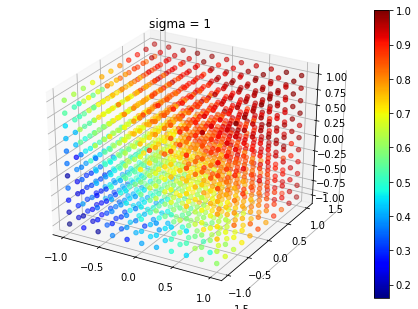

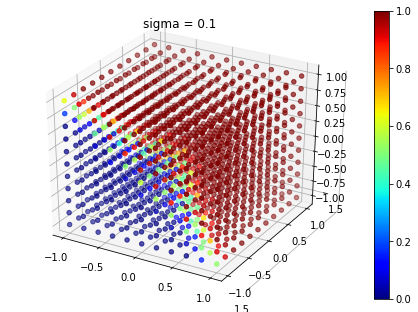

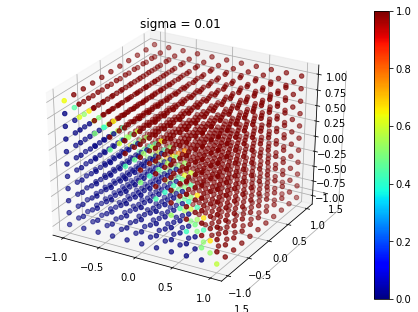

In [58]:
initial_partition_type = "0"
heuristic = "GBF"
for sigma in sigmas:
    x, f = MeshGrid3dMaxCut(k, min_weight, max_weight, initial_partition_type, n_points_ax, n_iters, complexity, heuristic, sigma)
    title = "sigma = " + str(sigma)
    PlotMeshGrid3d(x, -1*f, title)

###### Run and show results for 0 partition and RPF

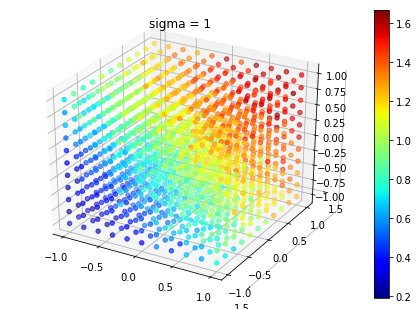

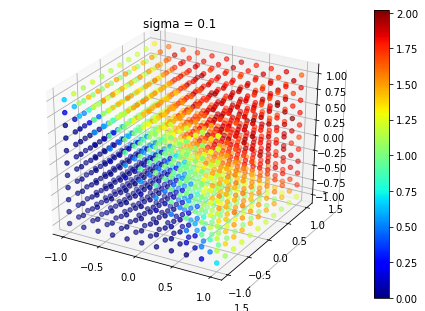

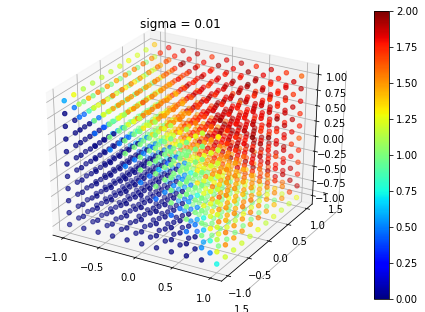

In [59]:
initial_partition_type = "0"
heuristic = "RPF"
for sigma in sigmas:
    x, f = MeshGrid3dMaxCut(k, min_weight, max_weight, initial_partition_type, n_points_ax, n_iters, complexity, heuristic, sigma)
    title = "sigma = " + str(sigma)
    PlotMeshGrid3d(x, -1*f, title)

###### Run and show results for 0 partition and WF

In [298]:
initial_partition_type = "0"
complexity = "smoothed"
heuristic = "WF"
for sigma in sigmas:
    x, f = MeshGrid3dMaxCut(k, min_weight, max_weight, initial_partition_type, n_points_ax, n_iters, complexity, heuristic, sigma)
    title = "sigma = " + str(sigma)
    PlotMeshGrid3d(x, -1*f, title)

KeyboardInterrupt: 

###### Run and show results for random partition and GBF

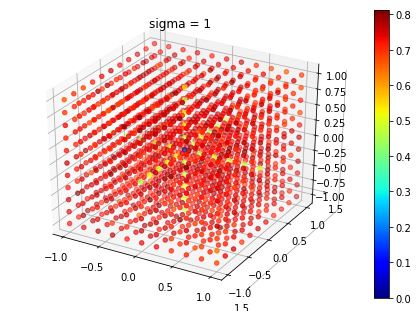

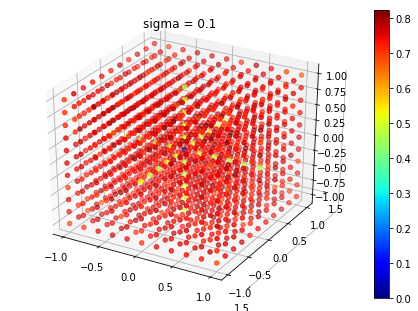

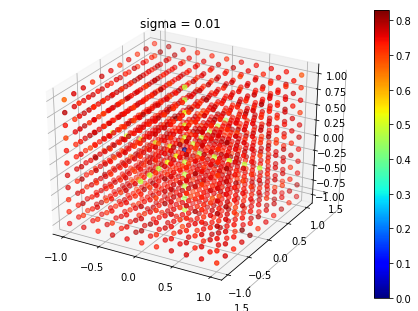

In [17]:
initial_partition_type = "random"
heuristic = "GBF"
for sigma in sigmas:
    x, f = MeshGrid3dMaxCut(k, min_weight, max_weight, initial_partition_type, n_points_ax, n_iters, complexity, heuristic, sigma)
    title = "sigma = " + str(sigma)
    PlotMeshGrid3d(x, -1*f, title)

###### Run and show results for random partition and RPF

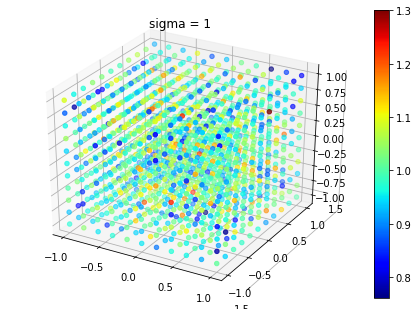

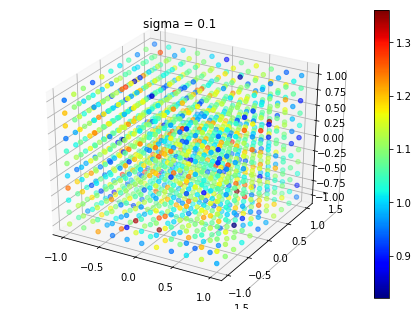

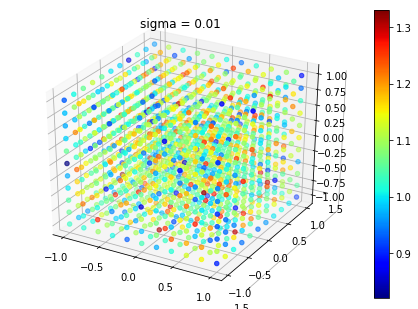

In [61]:
initial_partition_type = "random"
heuristic = "RPF"
for sigma in sigmas:
    x, f = MeshGrid3dMaxCut(k, min_weight, max_weight, initial_partition_type, n_points_ax, n_iters, complexity, heuristic, sigma)
    title = "sigma = " + str(sigma)
    PlotMeshGrid3d(x, -1*f, title)

##### Dependency on k



In [62]:
ks = [2, 3, 4]

###### Run and show results for 0 partition and GBF

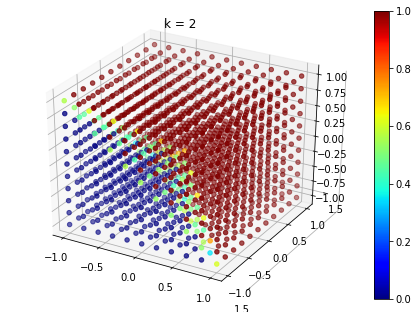

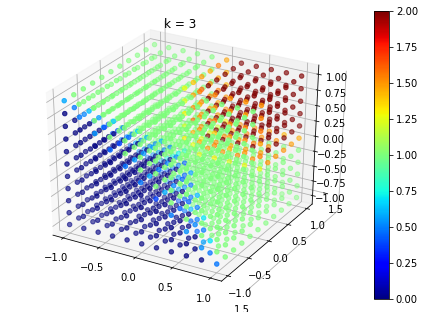

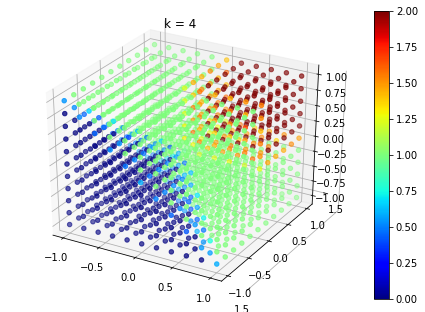

In [63]:
initial_partition_type = "0"
heuristic = "GBF"
for k in ks:
    x, f = MeshGrid3dMaxCut(k, min_weight, max_weight, initial_partition_type, n_points_ax, n_iters, complexity, heuristic, sigma)
    title = "k = " + str(k)
    PlotMeshGrid3d(x, -1*f, title)

###### Run and show results for 0 partition and RPF

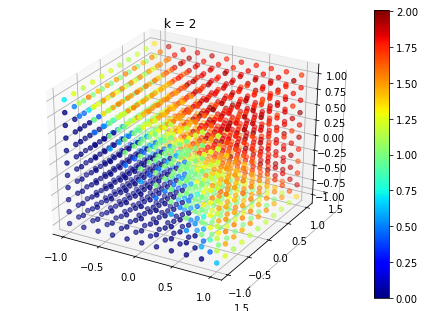

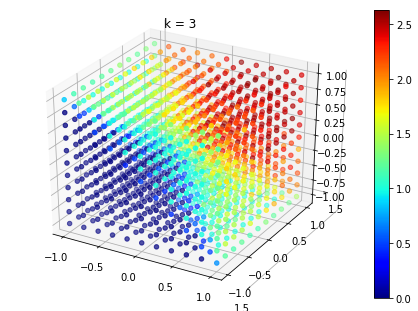

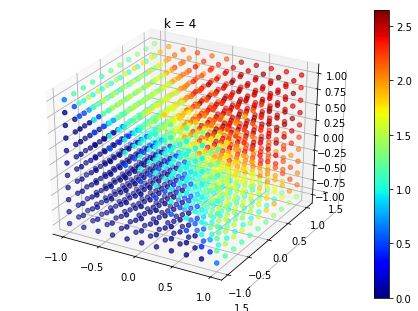

In [64]:
initial_partition_type = "0"
heuristic = "RPF"
for k in ks:
    x, f = MeshGrid3dMaxCut(k, min_weight, max_weight, initial_partition_type, n_points_ax, n_iters, complexity, heuristic, sigma)
    title = "k = " + str(k)
    PlotMeshGrid3d(x, -1*f, title)

###### Run and show results for random partition and GBF

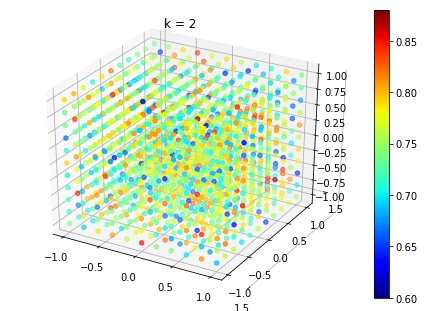

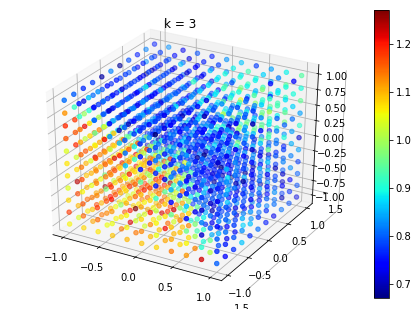

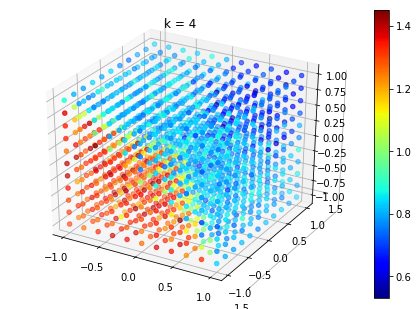

In [65]:
initial_partition_type = "random"
heuristic = "GBF"
for k in ks:
    x, f = MeshGrid3dMaxCut(k, min_weight, max_weight, initial_partition_type, n_points_ax, n_iters, complexity, heuristic, sigma)
    title = "k = " + str(k)
    PlotMeshGrid3d(x, -1*f, title)

###### Run and show results for random partition and RPF

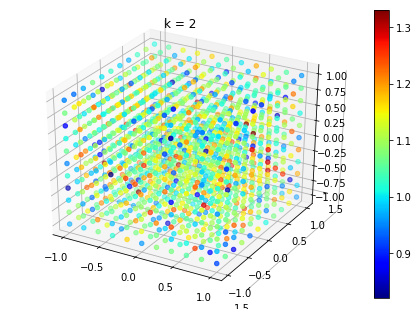

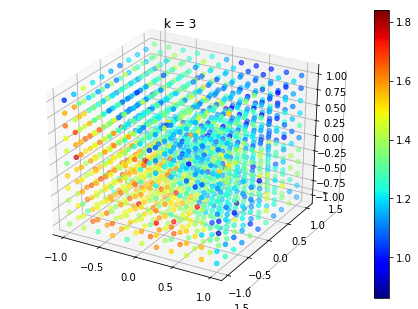

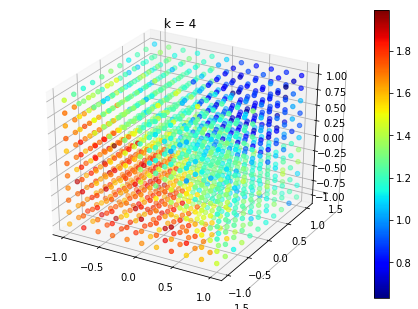

In [66]:
initial_partition_type = "random"
heuristic = "RPF"
for k in ks:
    x, f = MeshGrid3dMaxCut(k, min_weight, max_weight, initial_partition_type, n_points_ax, n_iters, complexity, heuristic, sigma)
    title = "k = " + str(k)
    PlotMeshGrid3d(x, -1*f, title)

#### Evolution of the maximum

##### Main parameters

In [158]:
## Define grid parameters
# Nodes
min_nodes = 60
max_nodes = 60
num_nodes = 1

# Dropout assumed to be 0
dropout = 0

# Min/max weights
min_weight = -1
max_weight = 1

# K-cuts
ks=[2]

# Number of instances for each combination
iters_for_nk=3000

# Perturbations
n_perturbations=10

#sigma
sigma = 0.1

# Method
heuristic = "GBF"

# Initial partition
initial_partition_type = "0"

##### Run

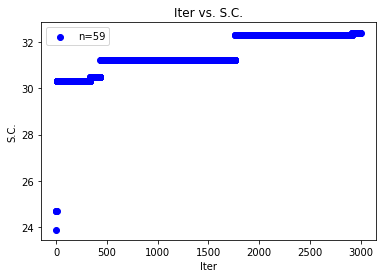

Best result for n=59 and k=2 is 32.4


In [159]:
nodes, smoothed_complexities = RandomGridSmoothedComplexityK(min_nodes, max_nodes, num_nodes, initial_partition_type, ks, dropout, 
                                  min_weight, max_weight, n_perturbations, iters_for_nk, heuristic, sigma, True, False, False)

#### Worst graph

##### Main parameters

In [37]:
## Define grid parameters
# Nodes
min_nodes = 11
max_nodes = 11
num_nodes = 1

# Dropout assumed to be 0
dropout = 0

# Min/max weights
min_weight = -1
max_weight = 1

# K-cuts
ks=[2]

# Number of instances for each combination
iters_for_nk=15

# Perturbations
n_perturbations=15

#sigma
sigma = 0.01

# Method
heuristic = "RPF"

##### Worst structure

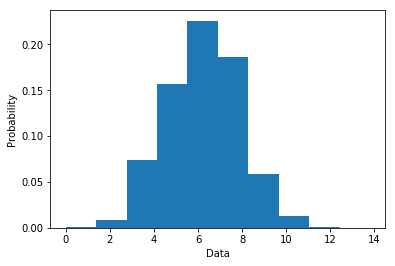

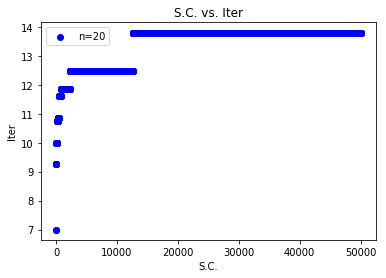

Worst graph

Weight statistics

  n    mean    median    std    min_weight    max_weight
---  ------  --------  -----  ------------  ------------
  9   0.283     0.340  0.460        -0.748         0.951


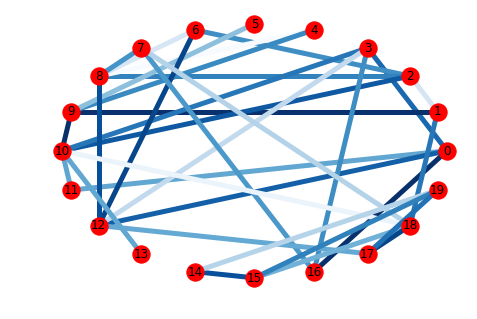

Reject null hypothesis: different distributions with probability 97.5 %
0.4842105263157894 > 0.1518447961086028


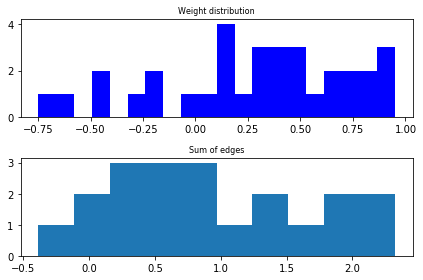

In [25]:
n = 20
initial_partition_type = "0"
k = 2
dropouts = [0.85]
min_weight = -1
max_weight = 1
tries = 1000
tries_in_dropout = 50
n_perturbations = 15
heuristic = "GBF"
sigma = 0.05
RandomGridSmoothedComplexityWorstStructure(n, initial_partition_type, k, dropouts, 
                                  min_weight, max_weight, tries, tries_in_dropout, n_perturbations, heuristic, 
                                  sigma, plotMaxEvolution = True, plotWorstGraph = True)

##### Run and plot with 0 partition

First graph

Weight statistics

  n    mean    median    std    min_weight    max_weight
---  ------  --------  -----  ------------  ------------
  7  -0.010     0.112  0.651        -0.967         0.969


C:\Users\kerik\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


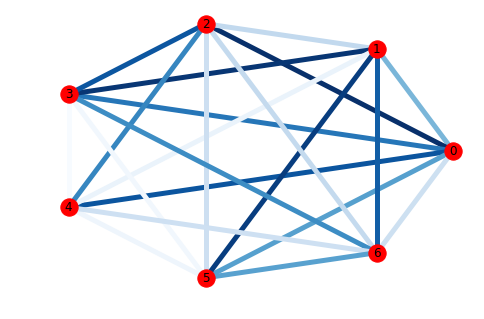

Both distributions are the same with probability 97.5 %
0.23809523809523803 < 0.45673791588779206


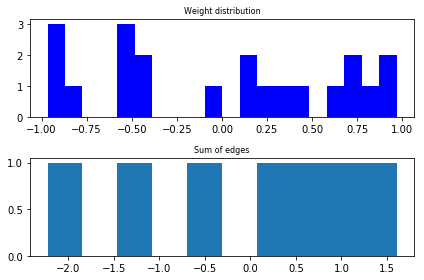

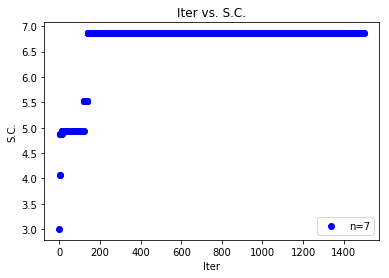

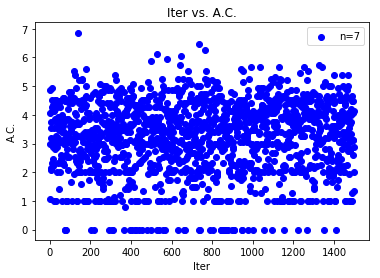

Worst graph

Weight statistics

  n    mean    median    std    min_weight    max_weight
---  ------  --------  -----  ------------  ------------
  7   0.242     0.242  0.471        -0.535         0.971


C:\Users\kerik\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


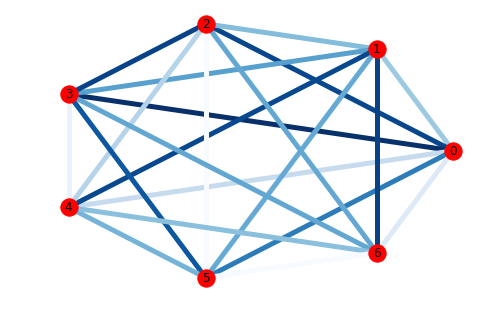

Both distributions are the same with probability 97.5 %
0.38095238095238093 < 0.45673791588779206


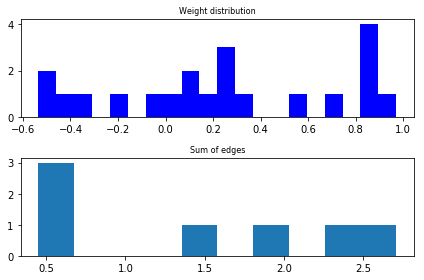

Best result for n=7 and k=2 is 6.866666666666666


In [38]:
# Initial partition
min_nodes = 8
max_nodes = 8
num_nodes = 1
initial_partition_type = "0"
nodes, smoothed_complexities = RandomGridSmoothedComplexityK(min_nodes, max_nodes, num_nodes, initial_partition_type, ks, dropout, min_weight, max_weight, n_perturbations, iters_for_nk, heuristic, sigma, True, True)

First graph

Weight statistics

  n    mean    median    std    min_weight    max_weight
---  ------  --------  -----  ------------  ------------
 10   0.010    -0.035  0.562        -0.960         0.998


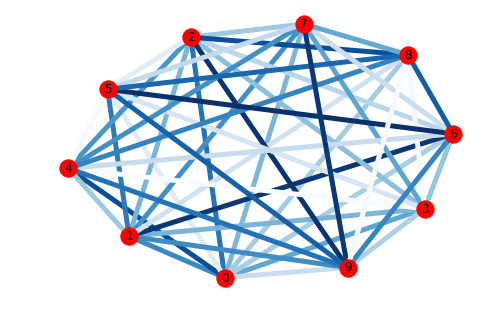

Both distributions are the same with probability 97.5 %
0.11111111111111105 < 0.3120113958032801


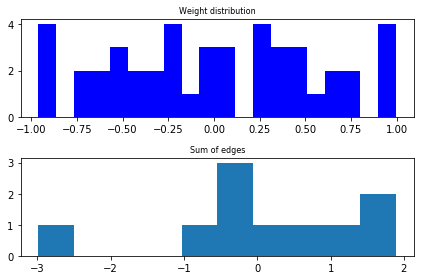

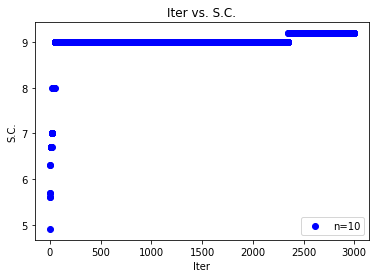

Worst graph

Weight statistics

  n    mean    median    std    min_weight    max_weight
---  ------  --------  -----  ------------  ------------
 10   0.148     0.202  0.544        -0.954         0.994


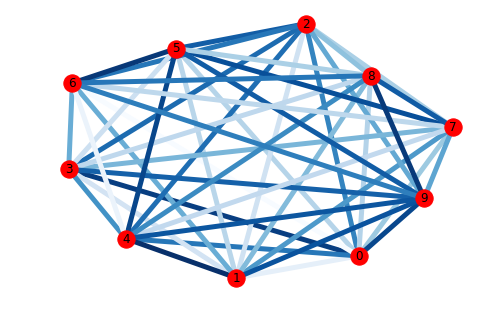

Both distributions are the same with probability 97.5 %
0.15555555555555556 < 0.3120113958032801


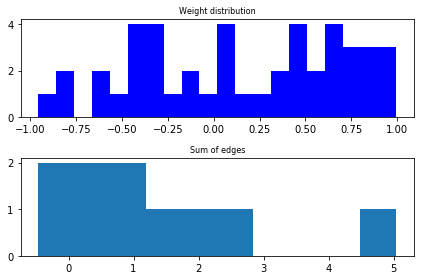

Best result for n=10 and k=2 is 9.2


In [164]:
# Initial partition
min_nodes = 10
max_nodes = 10
num_nodes = 1
initial_partition_type = "0"
nodes, smoothed_complexities = RandomGridSmoothedComplexityK(min_nodes, max_nodes, num_nodes, initial_partition_type, ks, dropout, min_weight, max_weight, n_perturbations, iters_for_nk, heuristic, sigma, True, True)

First graph

Weight statistics

  n    mean    median    std    min_weight    max_weight
---  ------  --------  -----  ------------  ------------
 70  -0.008    -0.007  0.576        -0.999         1.000


C:\Users\kerik\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


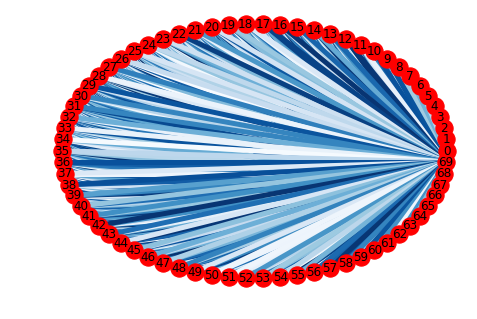

Both distributions are the same with probability 97.5 %
0.0331262939958592 < 0.042591030267102606


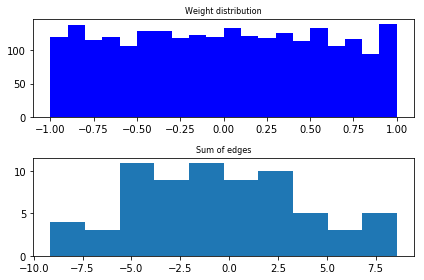

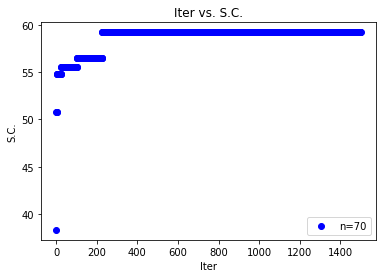

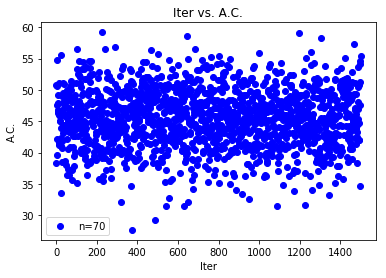

Worst graph

Weight statistics

  n    mean    median    std    min_weight    max_weight
---  ------  --------  -----  ------------  ------------
 70   0.040     0.074  0.580        -1.000         0.998


C:\Users\kerik\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


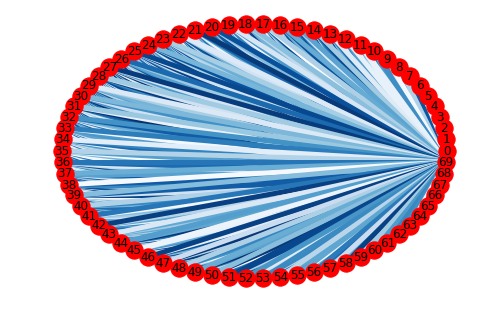

Reject null hypothesis: different distributions with probability 97.5 %
0.06666666666666665 > 0.042591030267102606


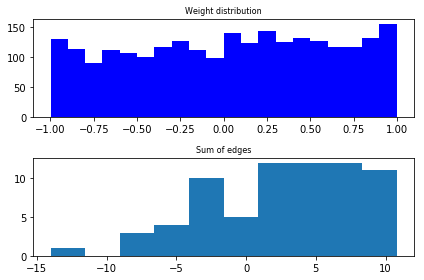

Best result for n=70 and k=2 is 59.2


In [39]:
# Initial partition
min_nodes = 70
max_nodes = 70
num_nodes = 1
initial_partition_type = "0"
nodes, smoothed_complexities = RandomGridSmoothedComplexityK(min_nodes, max_nodes, num_nodes, initial_partition_type, ks, dropout, min_weight, max_weight, n_perturbations, iters_for_nk, heuristic, sigma, True, True)

First graph

Weight statistics

  n    mean    median    std    min_weight    max_weight
---  ------  --------  -----  ------------  ------------
100  -0.005    -0.006  0.578        -1.000         1.000


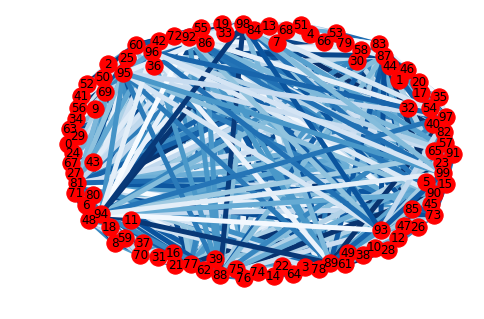

Both distributions are the same with probability 97.5 %
0.013535353535353511 < 0.029749119331672673


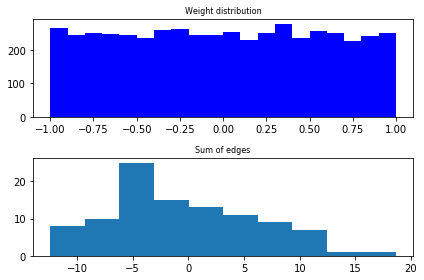

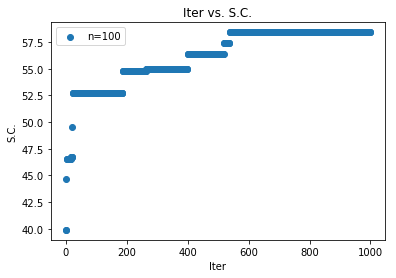

Worst graph

Weight statistics

  n    mean    median    std    min_weight    max_weight
---  ------  --------  -----  ------------  ------------
100  -0.002     0.001  0.578        -0.999         1.000


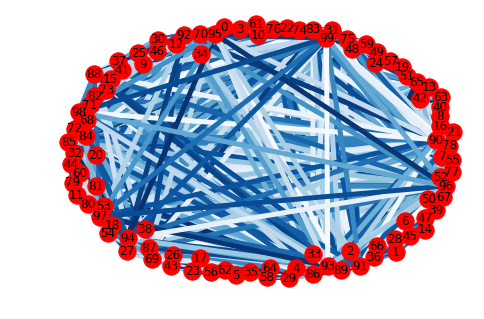

Both distributions are the same with probability 97.5 %
0.014343434343434325 < 0.029749119331672673


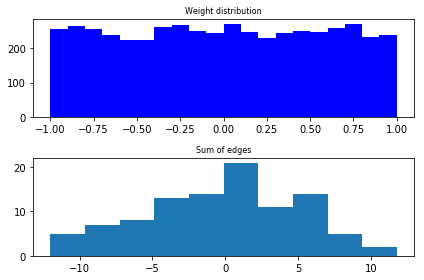

Best result for n=100 and k=2 is 58.4


In [35]:
# Initial partition
min_nodes = 100
max_nodes = 100
num_nodes = 1
initial_partition_type = "0"
nodes, smoothed_complexities = RandomGridSmoothedComplexityK(min_nodes, max_nodes, num_nodes, initial_partition_type, ks, dropout, min_weight, max_weight, n_perturbations, iters_for_nk, heuristic, sigma, True, True)

##### Erdos-Renyi

###### Load results from LRZ

In [68]:
# For each n in n_structures, we create a graph with a probability p. Weights are sampled n_samples times for this structure.
# The worst_value reached for each structure is shown.
# n_structures = 1000
# n_samples = 500
probs = [0.3, 0.5, 0.8]
nodes = CsvToNumpy("./Results/Parallel/Erdos-Renyi/nodes")
worst_n_steps = np.reshape(CsvToNumpy("./Results/Parallel/Erdos-Renyi/worst_structure_n_steps"), (len(nodes), 3))

###### Show results

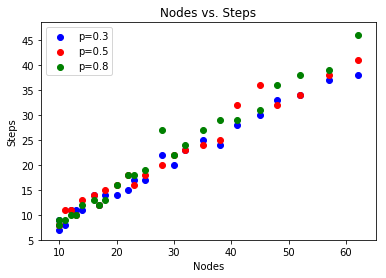

In [69]:
PlotResults(nodes, worst_n_steps, [], False, probs, 'p')

###### Polynomial behavior

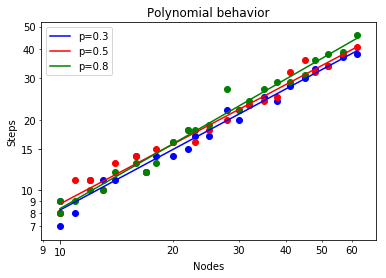

Regression results:

    p    slope    intercept    r_value
-----  -------  -----------  ---------
0.300    0.859        0.129      0.989
0.500    0.847        0.216      0.987
0.800    0.919        0.003      0.992


In [71]:
slopes, intercepts = PlotRegressionResults(nodes, worst_n_steps, [], False, probs, 'p', "polynomial")

###### Load worst structure

C:\Users\kerik\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


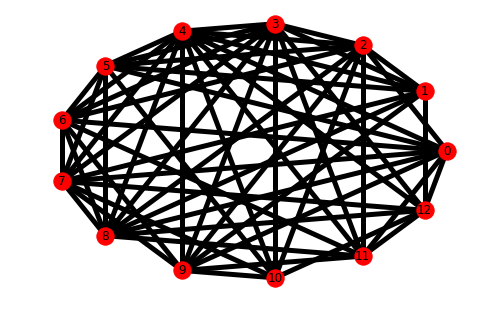

In [83]:
n = 13
worst_structure = np.reshape(CsvToNumpy("./Results/Parallel/Erdos-Renyi/worst_structure_" + str(n)), (n, n))
PlotGraph(worst_structure)

##### Brute force

In [93]:
n = 5
initial_partition_type = "0"
k = 2
min_weight, max_weight = -1, 1
n_tries = 10
heuristic = "GBF"

In [110]:
# test all connected graphs of n nodes
a, b, c, d = MaxCutAllAdjacencyMatrices(n, initial_partition_type, k, min_weight, max_weight, n_tries, heuristic, storeCSV=True)

In [137]:
avg_steps = CsvToNumpy("./steps_mean")
max_steps = CsvToNumpy("./steps_max")
pkl_file = open('instances.pkl', 'rb')
all_instances = pickle.load(pkl_file)

# Sort indices along value
sorted_indices = np.argsort(avg_steps)
all_instances = np.array(all_instances)
sorted_instances = all_instances[sorted_indices]

print(sorted_instances[0])
print(sorted_instances[len(all_instances)-1])

[[0. 1. 1. 0. 1.]
 [1. 0. 1. 0. 1.]
 [1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0.]]
[[0. 1. 0. 1. 1.]
 [1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0.]]


##### Worst structure modulo

###### Main parameters

In [94]:
## Define grid parameters
# Nodes
n = 17

# Dropout assumed to be 0
dropout = 0

# Min/max weights
min_weight = -1
max_weight = 1

# K-cuts
k=2

# Number of instances for each combination
tries=1000

# Perturbations
n_perturbations=15

initial_partition_type = "0"

#sigma
sigma = 0.1

modulos = [2, 6, 10, 12, 14]

# Method
heuristic = "GBF"

In [95]:
RandomGridSmoothedComplexityWorstStructureModulo(n, initial_partition_type, k, dropout, 
                                  min_weight, max_weight, tries, n_perturbations, heuristic, 
                                  sigma, modulos, graph_type = "modulo", plotMaxEvolution = True, plotWorstGraph = True)

KeyboardInterrupt: 

#### Dependency on n OK

##### Random partition + GBF

###### Show results

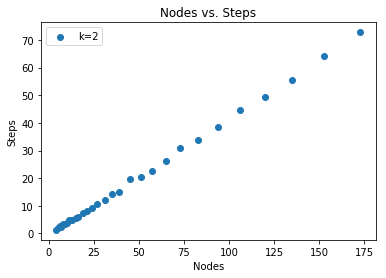

In [27]:
nodes = CsvToNumpy("./Results/SC_N_random_RG_GBF_serial/nodes")
smoothed_complexities = np.reshape(CsvToNumpy("./Results/SC_N_random_RG_GBF_serial/smoothed_complexities"), (len(nodes), 1))
PlotResults(nodes, smoothed_complexities, [], False, [2], 'k')
# 1000 iterations

###### Polynomial behavior

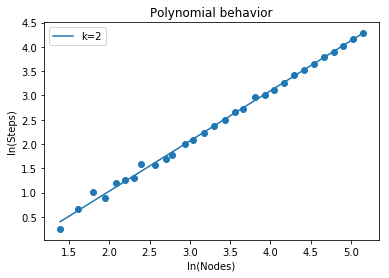

Regression results:

  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    1.031       -1.027      0.998


In [28]:
slopes, intercepts = PlotRegressionResults(nodes, smoothed_complexities, [], False, [2], 'k', "polynomial")

#### Dependency on k OK

##### Random grid

###### Main parameters

In [7]:
## Define grid parameters
# Nodes
min_nodes = 10
max_nodes = 50
num_nodes = 8

# Dropout assumed to be 0
dropout = 0

# K-cuts
ks=[2, 3, 5, 8]

# Weights range
min_weight = -1
max_weight = 1

# Weight perturbation (smoothed complexity)
sigma = 0.05

# iters_for_w
iters_for_w = 500

n_perturbations = 15

# Heuristic
heuristic = "GBF"

# partition
initial_partition_type = "0"

###### Run

In [8]:
#nodes, smoothed_complexities = RandomGridSmoothedComplexityK(min_nodes, max_nodes, num_nodes, initial_partition_type, ks, dropout, 
#                                  min_weight, max_weight, iters_for_nk, iters_for_w, heuristic, sigma)

nodes, smoothed_complexities = RandomGridSmoothedComplexityK(min_nodes, max_nodes, num_nodes, initial_partition_type, ks, dropout, 
                                  min_weight, max_weight, n_perturbations, iters_for_w, heuristic, sigma)

Best result for n=10 and k=2 is 7.133333333333334
Best result for n=10 and k=3 is 8.8
Best result for n=10 and k=5 is 8.8
Best result for n=10 and k=8 is 10.0
Best result for n=12 and k=2 is 7.6
Best result for n=12 and k=3 is 9.6
Best result for n=12 and k=5 is 12.4
Best result for n=12 and k=8 is 10.466666666666667
Best result for n=15 and k=2 is 10.666666666666666
Best result for n=15 and k=3 is 11.266666666666667
Best result for n=15 and k=5 is 13.0
Best result for n=15 and k=8 is 13.466666666666667
Best result for n=19 and k=2 is 12.333333333333334
Best result for n=19 and k=3 is 13.933333333333334
Best result for n=19 and k=5 is 16.4
Best result for n=19 and k=8 is 17.4
Best result for n=25 and k=2 is 18.2
Best result for n=25 and k=3 is 19.6
Best result for n=25 and k=5 is 22.266666666666666
Best result for n=25 and k=8 is 22.0
Best result for n=31 and k=2 is 16.466666666666665
Best result for n=31 and k=3 is 22.333333333333332
Best result for n=31 and k=5 is 24.733333333333334


###### Main parameters

In [65]:
## Define grid parameters
# Nodes
min_nodes = 5
max_nodes = 30
num_nodes = 10

# Dropout assumed to be 0
dropout = 0

# K-cuts
ks=[2]

# Weights range
min_weight = -1
max_weight = 1

# Weight perturbation (smoothed complexity)
sigma = 0.01

# Weight perturbation random search ("step size")
e = 0.8

# Decay of step size
decay = 0.001

# Number of times we perturbate the weights per step
iters_for_perturbation= 20

# Method
heuristic = "GBF"

# n iterations of algorithm
n_iterations = 30

# Tries random search
tries = 20

# partition
initial_partition_type = "0"

###### Run

In [66]:
nodes, smoothed_complexities = RandomOptimizationSmoothedComplexityK(min_nodes, max_nodes, num_nodes, initial_partition_type, ks, 
                                  min_weight, max_weight, n_iterations, tries, heuristic, iters_for_perturbation, e, decay, sigma)
#nodes, smoothed_complexities = RandomOptimizationSmoothedComplexityParallelK(min_nodes, max_nodes, num_nodes, initial_partition_type, ks, 
#                                  min_weight, max_weight, n_iterations, tries, heuristic, iters_for_perturbation, e, decay, sigma)

Best result for n=4 and k=2 is 3.0
Best result for n=6 and k=2 is 5.0
Best result for n=7 and k=2 is 7.0
Best result for n=9 and k=2 is 8.0
Best result for n=11 and k=2 is 10.35
Best result for n=13 and k=2 is 11.025
Best result for n=16 and k=2 is 10.3
Best result for n=20 and k=2 is 15.475
Best result for n=24 and k=2 is 15.6
Best result for n=29 and k=2 is 21.0


##### Load results from LRZ

In [305]:
nodes = CsvToNumpy("./Results/DA/SC_GBF_K_0/nodes")
smoothed_complexities = np.reshape(CsvToNumpy("./Results/DA/SC_GBF_K_0/smoothed_complexities"), (len(nodes), 4))
ks = [2, 3, 5, 8]

##### Show results

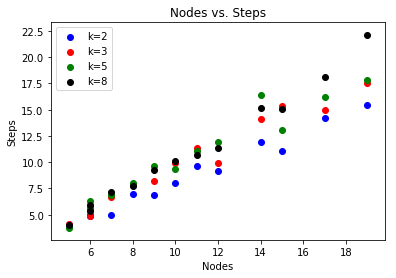

In [306]:
PlotResults(nodes, -1*smoothed_complexities, [], False, ks, 'k')

##### Polynomial behavior

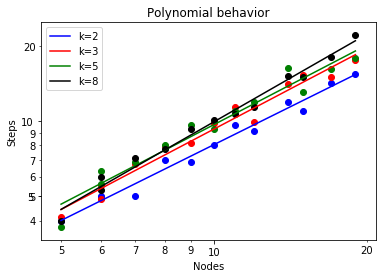

Regression results:

  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    1.008       -0.235      0.989
  3    1.069       -0.232      0.985
  5    1.058       -0.165      0.975
  8    1.165       -0.385      0.993


In [315]:
slopes, intercepts = PlotRegressionResults(nodes, -1*smoothed_complexities, [], False, ks, 'k', "polynomial")

#### Dependency on initial partition OK

<p>For deterministic algorithms, the 0 partition gives a higher number of steps while conserving the same slope as the random initial partition.</p>
<p>However, for a randomized algorithm, both partition give very similar results</p>

##### GBF

###### Load data

In [291]:
nodes_random = CsvToNumpy("./Results/Serial/SC_N_random_RG_GBF_serial/nodes")
smoothed_complexities_random = np.reshape(CsvToNumpy("./Results/Serial/SC_N_random_RG_GBF_serial/smoothed_complexities"), (len(nodes_random), 1))
nodes_0 = CsvToNumpy("./Results/Serial/SC_N_0_RG_GBF_serial/nodes")
smoothed_complexities_0 = np.reshape(CsvToNumpy("./Results/Serial/SC_N_0_RG_GBF_serial/smoothed_complexities"), (len(nodes_0), 1))

###### Show results

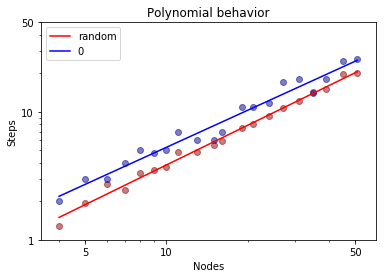

Regression results:

random
  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    1.030       -1.026      0.995
0
  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    0.962       -0.550      0.983


In [294]:
PlotTwoRegressionResults(nodes_random, smoothed_complexities_random, [], nodes_0, smoothed_complexities_0, [], False, [2], 'k', 'polynomial', ["random", "0"])

##### RPF

###### Load data

In [318]:
nodes_random = CsvToNumpy("./Results/SC_N_random_RG_RPF_serial/nodes")
smoothed_complexities_random = np.reshape(CsvToNumpy("./Results/SC_N_random_RG_RPF_serial/smoothed_complexities"), (len(nodes_random), 1))
nodes_0 = CsvToNumpy("./Results/SC_N_0_RG_RPF_serial/nodes")
smoothed_complexities_0 = np.reshape(CsvToNumpy("./Results/SC_N_0_RG_RPF_serial/smoothed_complexities"), (len(nodes_0), 1))

###### Show results

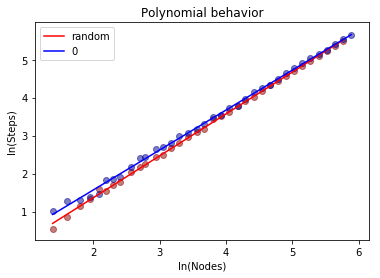

Regression results:

random
  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    1.102       -0.838      0.999
0
  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    1.051       -0.532      0.999


In [319]:
PlotTwoRegressionResults(nodes_random, smoothed_complexities_random, [], nodes_0, smoothed_complexities_0, [], False, [2], 'k', 'polynomial', ["random", "0"])

##### WF

###### Load data

In [320]:
nodes_random = CsvToNumpy("./Results/SC_N_random_RG_WF_serial/nodes")
smoothed_complexities_random = np.reshape(CsvToNumpy("./Results/SC_N_random_RG_WF_serial/smoothed_complexities"), (len(nodes_random), 1))
nodes_0 = CsvToNumpy("./Results/SC_N_0_RG_WF_serial/nodes")
smoothed_complexities_0 = np.reshape(CsvToNumpy("./Results/SC_N_0_RG_WF_serial/smoothed_complexities"), (len(nodes_0), 1))

###### Show results

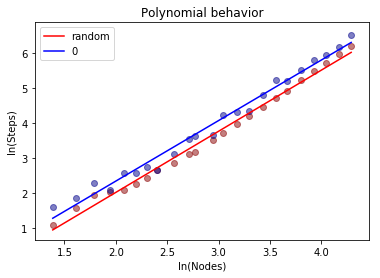

Regression results:

random
  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    1.747       -1.471      0.996
0
  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    1.730       -1.114      0.992


In [321]:
PlotTwoRegressionResults(nodes_random, smoothed_complexities_random, [], nodes_0, smoothed_complexities_0, [], False, [2], 'k', 'polynomial', ["random", "0"])

#### Dependency on maximization method OK

<p>Basin-hopping, dual annealing, random search and differential evolution take too much time and do not seem to offer better results than random grid.<p/>

##### Main parameters

In [221]:
## Define grid parameters
# Nodes
min_nodes = 6
max_nodes = 6
num_nodes = 1

# Dropout assumed to be 0
dropout = 0

# Min/max weights
min_weight = -1
max_weight = 1

# K-cuts
ks=[2]

# Number of instances for each combination
n_iterations = 10

# Perturbations
n_perturbations=25

#sigma
sigma = 0.1

# Method
heuristic = "GBF"

#algorithm
algorithm = "basinhopping"

initial_partition_type = "0"

##### Run

In [222]:
nodes, sc = OptimizationSmoothedComplexityK(min_nodes, max_nodes, num_nodes, initial_partition_type, ks, dropout, 
                                  min_weight, max_weight, n_perturbations, heuristic, sigma, n_iterations, algorithm, storeCSV=False)

basinhopping step 0: f -1.6
basinhopping step 1: f -0.52 trial_f -0.52 accepted 1  lowest_f -1.6
basinhopping step 2: f -2.04 trial_f -2.04 accepted 1  lowest_f -2.04
found new global minimum on step 2 with function value -2.04
basinhopping step 3: f -2.04 trial_f -2.04 accepted 1  lowest_f -2.04
basinhopping step 4: f -2.16 trial_f -2.16 accepted 1  lowest_f -2.16
found new global minimum on step 4 with function value -2.16
basinhopping step 5: f -2.6 trial_f -2.6 accepted 1  lowest_f -2.6
found new global minimum on step 5 with function value -2.6
basinhopping step 6: f -1.92 trial_f -1.92 accepted 1  lowest_f -2.6
basinhopping step 7: f -1.88 trial_f -1.88 accepted 1  lowest_f -2.6
basinhopping step 8: f -2.12 trial_f -2.12 accepted 1  lowest_f -2.6
basinhopping step 9: f -2.12 trial_f -0.6 accepted 0  lowest_f -2.6
basinhopping step 10: f -2.12 trial_f -1.4 accepted 0  lowest_f -2.6
basinhopping step 11: f -2.12 trial_f -0.6 accepted 0  lowest_f -2.6
basinhopping step 12: f -1.96 t

In [223]:
algorithm = "dual_annealing"
nodes, sc = OptimizationSmoothedComplexityK(min_nodes, max_nodes, num_nodes, initial_partition_type, ks, dropout, 
                               min_weight, max_weight, n_perturbations, heuristic, sigma, n_iterations, algorithm, storeCSV=False)


In [224]:
print(sc)

[[3.84]]


##### Load results from LRZ

In [154]:
nodes_RG = CsvToNumpy("./Results/Serial/SC_N_0_RG_GBF_serial/nodes")
smoothed_complexities_RG = np.reshape(CsvToNumpy("./Results/Serial/SC_N_0_RG_GBF_serial/smoothed_complexities"), (len(nodes_RG), 1))
nodes_DA = CsvToNumpy("./Results/Serial/SC_N_0_DA_GBF_Serial/nodes")
smoothed_complexities_DA = np.reshape(CsvToNumpy("./Results/Serial/SC_N_0_DA_GBF_Serial/smoothed_complexities"), (len(nodes_DA), 1))
nodes_BH = CsvToNumpy("./Results/Serial/SC_N_0_BH_GBF_Serial/nodes")
smoothed_complexities_BH = np.reshape(CsvToNumpy("./Results/Serial/SC_N_0_BH_GBF_Serial/smoothed_complexities"), (len(nodes_BH), 1))

##### Compare results

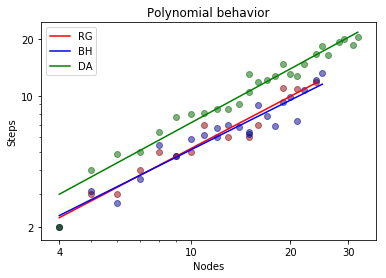

Regression results:

method      slope    intercept    r_value
--------  -------  -----------  ---------
R           0.923       -0.472      0.970
method      slope    intercept    r_value
--------  -------  -----------  ---------
B           0.878       -0.384      0.955
method      slope    intercept    r_value
--------  -------  -----------  ---------
D           0.954       -0.228      0.978


In [232]:
PlotThreeRegressionResults(nodes_RG, smoothed_complexities_RG, [], nodes_BH, -1*smoothed_complexities_BH, [], nodes_DA, -1*smoothed_complexities_DA, [], True, ["GBF"], "method", 'polynomial', ["RG", "BH", "DA"])

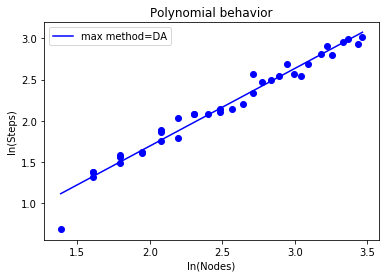

Regression results:

max method      slope    intercept    r_value
------------  -------  -----------  ---------
DA              0.941       -0.186      0.983


([0.9405854024281383], [-0.18574773874584016])

In [284]:
# Dual annealing
PlotRegressionResults(nodes_DA, -1*smoothed_complexities_DA, [], False, ["DA"], "max method", "polynomial")

#### Dependency on heuristics OK

<p>RPF and GBF have a linear behavior where as WF shows a polynomially squared behavior</p>

##### Load results from LRZ

In [262]:
nodes = CsvToNumpy("./Results/DA/SC_Heuristics_0/nodes")
smoothed_complexities = np.reshape(CsvToNumpy("./Results/DA/SC_Heuristics_0/smoothed_complexities"), (len(nodes), 3))

##### Show results

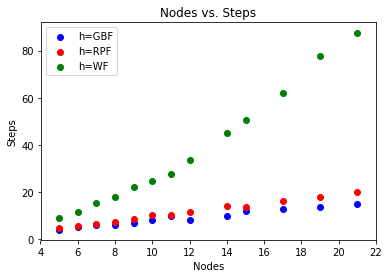

In [263]:
PlotResults(nodes, -1*smoothed_complexities, [], False, ['GBF', 'RPF', 'WF'], 'h')

##### Polynomial behavior

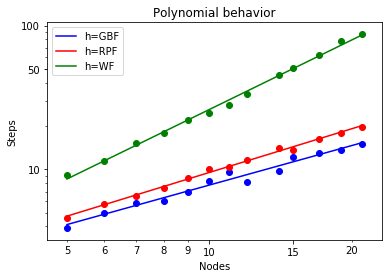

Regression results:

h      slope    intercept    r_value
---  -------  -----------  ---------
GBF    0.914       -0.054      0.987
RPF    1.011       -0.075      0.997
WF     1.608       -0.441      0.998


In [276]:
slopes, intercepts = PlotRegressionResults(nodes, -1*smoothed_complexities, [], False, ['GBF', 'RPF', 'WF'], 'h', "polynomial")
#
# Intercepts are higher than those of the average complexity (which makes sense since we are considering
# the maximum of all perturbed averages) whereas exponents remain the same up to the second decimal place.

#### Dependency on structure OK

In [25]:
nodes = CsvToNumpy("./Results/SC_Intercalation_0_RG_GBF_serial/nodes")
smoothed_complexities = np.reshape(CsvToNumpy("./Results/SC_Intercalation_0_RG_GBF_serial/smoothed_complexities"), (len(nodes), 5))
intercalations = [0.1, 0.2, 0.3, 0.4, 0.5]

OSError: ./Results/SC_Intercalation_0_RG_GBF_serial/nodes.csv not found.

##### Show results

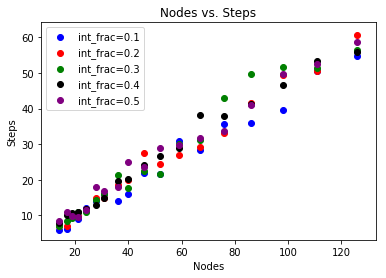

In [232]:
PlotResults(nodes, smoothed_complexities, [], False, intercalations, 'int_frac')

##### Polynomial behavior

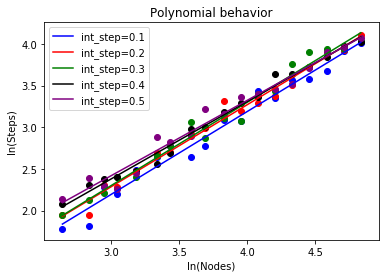

Regression results:

  int_step    slope    intercept    r_value
----------  -------  -----------  ---------
     0.100    0.992       -0.780      0.987
     0.200    0.982       -0.659      0.992
     0.300    0.997       -0.690      0.990
     0.400    0.927       -0.398      0.995
     0.500    0.903       -0.287      0.987


In [233]:
slopes, intercepts = PlotRegressionResults(nodes, smoothed_complexities, [], False, intercalations, 'int_step', "polynomial")

#### Dependency on structure for a fixed n

##### Main parameters

In [26]:
## Define grid parameters
# Nodes
min_nodes = 40
max_nodes = 40
num_nodes = 1

# Dropout assumed to be 0
dropout = 0

# K-cuts
k=2

# Weights range
min_weight = 0
max_weight = 1

# Perturbation
k = 2

# Number of instances for each combination
tries = 200

intercalations = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

# iters_for_w
n_perturbations = 20

# sigma
sigma = 0.05

# Method
heuristic = "GBF"

# partition
initial_partition_type = "0"

nodes, sc = RandomGridSmoothedComplexityIntercalations(min_nodes, max_nodes, num_nodes, initial_partition_type, k, dropout, 
                                  min_weight, max_weight, tries, n_perturbations, heuristic, 
                                  sigma, intercalations, plotMaxEvolution = False, plotWorstGraph = False, storeCSV=False)

Best result for n=39 and intercalation=0.05 is 19.46
Best result for n=39 and intercalation=0.1 is 21.47
Best result for n=39 and intercalation=0.15 is 20.68
Best result for n=39 and intercalation=0.2 is 21.95
Best result for n=39 and intercalation=0.25 is 22.135
Best result for n=39 and intercalation=0.3 is 21.145
Best result for n=39 and intercalation=0.35 is 22.6
Best result for n=39 and intercalation=0.4 is 24.075
Best result for n=39 and intercalation=0.45 is 21.62
Best result for n=39 and intercalation=0.5 is 21.71


##### Plot results

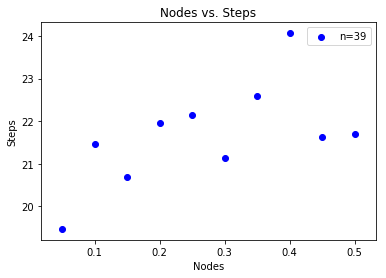

In [27]:
PlotResults(np.asarray(intercalations), sc.T, [], False, nodes, 'n')

##### Polynomial behavior

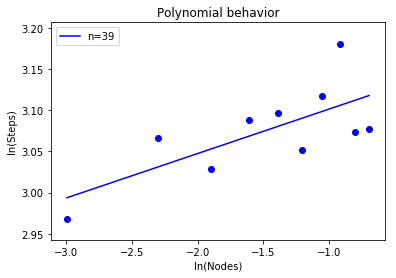

Regression results:

     n    slope    intercept    r_value
------  -------  -----------  ---------
39.000    0.054        3.155      0.710


In [28]:
slopes, intercepts = PlotRegressionResults(np.asarray(intercalations), sc.T, [], False, nodes, 'n', "polynomial")

#### Dependency on sigma

##### Load results

In [316]:
nodes = CsvToNumpy("./Results/DA/SC_GBF_Sigma_0/nodes")
smoothed_complexities = np.reshape(CsvToNumpy("./Results/DA/SC_GBF_Sigma_0/smoothed_complexities"), (len(nodes), 5))
sigmas = [0, 0.01, 0.05, 0.1, 0.5]
nodes_repeated = pd.DataFrame(np.repeat(nodes, len(sigmas)))
sigmas_repeated = []
for i in range(len(nodes)):
    sigmas_repeated.extend(sigmas)
sigmas_repeated = pd.DataFrame(sigmas_repeated)

X = pd.concat([nodes_repeated, sigmas_repeated], axis = 1)
X.columns = ["k2", "k1"]
Y = -1*smoothed_complexities.flatten()

##### Plot

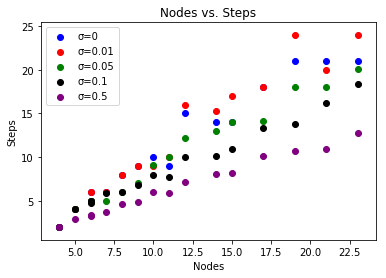

In [317]:
PlotResults(nodes, -1*smoothed_complexities, [], False, sigmas, 'σ')

##### Polynomial behavior

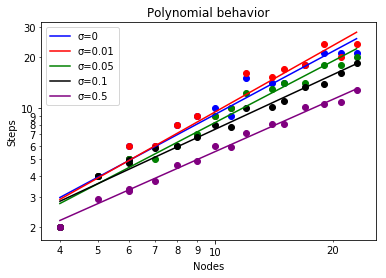

Regression results:

    σ    slope    intercept    r_value
-----  -------  -----------  ---------
0.000    1.230       -0.614      0.972
0.010    1.295       -0.729      0.975
0.050    1.199       -0.652      0.982
0.100    1.065       -0.436      0.980
0.500    1.019       -0.632      0.996


In [320]:
slopes, intercepts = PlotRegressionResults(nodes, -1*smoothed_complexities, [], False, sigmas, 'σ', "polynomial")

##### Multilinear regression

In [19]:
params, r2sq = MultilinearRegression(X, Y, 'log-log')
# ln(SC) = ln(C) -k1*ln(sigma) + k2*ln(n)
C = np.round(params[0], 2)
k1 = np.round(-1*params[2], 2)
k2 = np.round(params[1],2)
print("Smoothed complexity:", C, "*σ^", -1*k1, "*n^", k2)
print("R2:", r2sq)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     724.7
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           1.15e-50
Time:                        09:32:03   Log-Likelihood:                 43.834
No. Observations:                  80   AIC:                            -81.67
Df Residuals:                      77   BIC:                            -74.52
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9362      0.081    -11.511      0.0

#### Polynomial smoothed complexity (low sigmas)

##### Show data

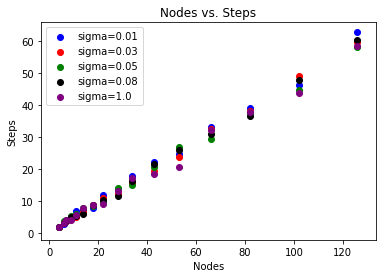

In [12]:
PlotResults(nodes, smoothed_complexities, [], False, sigmas, 'sigma')

##### Multilineal regresion

In [11]:
params, r2sq = MultilinearRegression(X, Y, 'log-log')
# ln(SC) = ln(C) -k1*ln(sigma) + k2*ln(n)
C = np.round(params[0], 2)
k1 = np.round(-1*params[2], 2)
k2 = np.round(params[1],2)
print("Smoothed complexity:", C, "*σ^", -1*k1, "*n^", k2)
print("R2:", r2sq)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     5789.
Date:                Sun, 10 May 2020   Prob (F-statistic):           1.17e-84
Time:                        18:15:54   Log-Likelihood:                 88.715
No. Observations:                  80   AIC:                            -171.4
Df Residuals:                      77   BIC:                            -164.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5716      0.034    -16.984      0.0

#### Polynomial smoothed complexity (high sigmas)

##### Load data from LRZ

In [9]:
nodes = CsvToNumpy("./Results/Serial/SC_Sigma_0_RG_GBF_serial/nodes")
sigmas = CsvToNumpy("./Results/Serial/SC_Sigma_0_RG_GBF_serial/sigmas")
smoothed_complexities = CsvToNumpy("./Results/Serial/SC_Sigma_0_RG_GBF_serial/smoothed_complexities")

nodes_repeated = pd.DataFrame(np.repeat(nodes, len(sigmas)))
sigmas_repeated = []
for i in range(len(nodes)):
    sigmas_repeated.extend(sigmas)
sigmas_repeated = pd.DataFrame(sigmas_repeated)

X = pd.concat([nodes_repeated, sigmas_repeated], axis = 1)
X.columns = ["k2", "k1"]
Y = smoothed_complexities.flatten()

[ 1.99933333  1.794       1.83666667  1.78066667  1.502       2.986
  2.69133333  2.58266667  2.36866667  2.42        3.88266667  3.176
  2.81466667  2.612       2.752       4.42933333  4.186       3.79
  3.89        3.46933333  5.78666667  5.01466667  4.64733333  4.432
  4.35933333  5.59466667  5.94266667  5.72866667  5.71666667  5.486
  6.94466667  7.93133333  7.264       7.07933333  6.78466667  8.98333333
  9.46933333  9.16066667  9.24266667  8.532      12.054      11.88733333
 11.788      11.574      11.258      14.746      14.032      14.33533333
 13.30466667 13.52533333 19.634      18.60133333 17.59866667 18.33066667
 16.65333333 24.446      21.67733333 22.20133333 21.71666667 21.778
 31.426      28.47933333 27.03       26.822      26.424      37.34666667
 36.20666667 35.31933333 34.74866667 33.76       47.00866667 43.38866667
 43.82       41.268      41.33333333 56.46466667 54.52533333 54.366
 52.88666667 51.52266667]


##### Show data

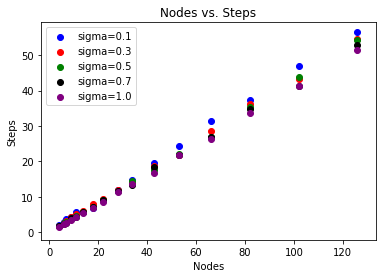

In [6]:
PlotResults(nodes, smoothed_complexities, [], False, sigmas, 'sigma')

##### Multilineal regresion

In [10]:
params, r2sq = MultilinearRegression(X, Y, 'log-log')
# ln(SC) = ln(C) -k1*ln(sigma) + k2*ln(n)
C = np.exp(np.round(params[0], 2))
k1 = np.round(-1*params[2], 2)
k2 = np.round(params[1],2)
print("Smoothed complexity:", C, "*σ^", -1*k1, "*n^", k2)
print("R2:", r2sq)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.469e+04
Date:                Sat, 01 Aug 2020   Prob (F-statistic):          3.72e-100
Time:                        19:19:55   Log-Likelihood:                 122.10
No. Observations:                  80   AIC:                            -238.2
Df Residuals:                      77   BIC:                            -231.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8928      0.021    -43.361      0.0

C:\Users\kerik\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Partial graph (dropout)

#### Load results from LRZ

In [346]:
nodes = CsvToNumpy("./Results/DA/SC_Dropouts_GBF_0/nodes")
smoothed_complexities = np.reshape(CsvToNumpy("./Results/DA/SC_Dropouts_GBF_0/smoothed_complexities"), (len(nodes), 5))
dropouts = [0, 0.2, 0.4, 0.6, 0.8]

#### Show results

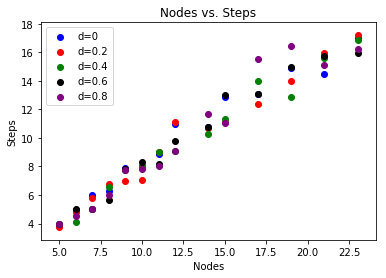

In [347]:
PlotResults(nodes, -1*smoothed_complexities, [], False, dropouts, 'd')

#### Polynomial behavior

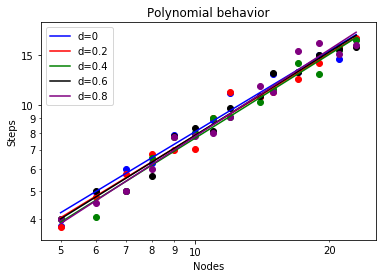

Regression results:

    d    slope    intercept    r_value
-----  -------  -----------  ---------
0.000    0.938       -0.072      0.988
0.200    0.952       -0.133      0.989
0.400    0.973       -0.203      0.988
0.600    0.967       -0.168      0.988
0.800    1.008       -0.271      0.986


In [356]:
slopes, intercepts = PlotRegressionResults(nodes, -1*smoothed_complexities, [], False, dropouts, 'd', "polynomial")

## Average vs. Smoothed Complexity

### Main functions

In [69]:
def PlotTwoRegressionResults(nodes1, steps_mean1, steps_sd1, nodes2, steps_mean2, with_errorbars, r_var, r_var_label, method, labels):
    
    # Create a new plot
    plt.figure(np.random.randint(501, 1000))

    # t runs over all columns of steps_mean
    t=0
    slopes1=[]
    intercepts1=[]
    r_values1=[]
    p_values1=[]
    std_errs1=[]    
    
    # Convert X axis according to method
    x1 = nodes1
    if method=="polynomial":
        x1 = np.log(x1.reshape(-1, 1))
    if method == "quasipolynomial":
        x1 = np.log(x1.reshape(-1, 1))*x1.reshape(-1, 1)
    
    # For the averae case, we have to reduce the number of vertices so that the have similar lengths
    last_index = np.argmax(nodes1>np.max(nodes2))
    x1 = x1[:last_index]
    steps_mean1 = steps_mean1[:last_index]
    steps_sd1 = steps_sd1[:last_index]
    
    for r_v in r_var:
        # Convert Y axis according to method
        y1 = steps_mean1[:,t]
        if (method=="polynomial") or (method=="exponential") or (method=="quasipolynomial"):
            y1 = np.log(y1)
        plt.scatter(x1, y1, c = "darkred")
        if with_errorbars:
            y_sd1 = steps_sd1[:, t]
            plt.errorbar(x1,y1,yerr=y_sd1, linestyle="None", c = "darkred")

        # Linear regression
        slope1, intercept1, r_value1, p_value1, std_err1 = stats.mstats.linregress(x1,y1)

        # Store results
        slopes1.append(slope1)
        intercepts1.append(intercept1)
        r_values1.append(r_value1)
        p_values1.append(p_value1)
        std_errs1.append(std_err1)

        # Linear regression prediction
        y_reg1 = intercept1 + slope1*x1
        plt.plot(x1, y_reg1, label=labels[0], c = "red")
        t+=1
        
    # t runs over all columns of steps_mean
    t=0
    slopes2=[]
    intercepts2=[]
    r_values2=[]
    p_values2=[]
    std_errs2=[]   
    
    # X2 is smoothed, therefore no error bars
    # Convert X axis according to method
    x2 = nodes2
    if method=="polynomial":
        x2 = np.log(x2.reshape(-1, 1))
    if method == "quasipolynomial":
        x2 = np.log(x2.reshape(-1, 1))*x2.reshape(-1, 1)
    
    for r_v in r_var:
        # Convert Y axis according to method
        y2 = steps_mean2[:,t]
        if (method=="polynomial") or (method=="exponential") or (method=="quasipolynomial"):
            y2 = np.log(y2)
        plt.scatter(x2, y2, c = "darkblue")

        # Linear regression
        slope2, intercept2, r_value2, p_value2, std_err2 = stats.mstats.linregress(x2,y2)

        # Store results
        slopes2.append(slope2)
        intercepts2.append(intercept2)
        r_values2.append(r_value2)
        p_values2.append(p_value2)
        std_errs2.append(std_err2)

        # Linear regression prediction
        y_reg2 = intercept2 + slope2*x2
        plt.plot(x2, y_reg2, label=labels[1], c = "blue")
        t+=1

    if method=="polynomial":
        plt.title('Polynomial behavior')     
        plt.xlabel('ln(Nodes)') 
        plt.ylabel('ln(Steps)')
    
    if method=="exponential":
        plt.title('Exponential behavior')     
        plt.xlabel('Nodes') 
        plt.ylabel('ln(Steps)')
        
    if method=="quasipolynomial":
        plt.title('Quasiplynomial behavior')     
        plt.xlabel('ln(Nodes)*Nodes') 
        plt.ylabel('ln(Steps)')
    
    plt.legend(loc="upper left")        
    plt.show()

    # Print table
    print("Regression results:\n")
    print(labels[0])
    print(tabulate(list(zip(*[r_var, slopes1, intercepts1, r_values1])), headers=[r_var_label, 'slope', 'intercept', 'r_value'], floatfmt=".3f"))
    print(labels[1])
    print(tabulate(list(zip(*[r_var, slopes2, intercepts2, r_values2])), headers=[r_var_label, 'slope', 'intercept', 'r_value'], floatfmt=".3f"))
    
    return

### Complete graph

#### Dependency on n

In [73]:
labels = ["average", "smoothed"]

##### Random partition + GBF

###### Load results

In [71]:
ac_nodes = CsvToNumpy("./Results/AC_N_random_RG_GBF_serial/nodes")
ac_steps_mean = np.reshape(CsvToNumpy("./Results/AC_N_random_RG_GBF_serial/average_complexities"), (len(ac_nodes), 1))
ac_steps_sd = np.reshape(CsvToNumpy("./Results/AC_N_random_RG_GBF_serial/average_complexities_sd"), (len(ac_nodes), 1))
sc_nodes = CsvToNumpy("./Results/SC_N_random_RG_GBF_serial/nodes")
sc_smoothed_complexities = np.reshape(CsvToNumpy("./Results/SC_N_random_RG_GBF_serial/smoothed_complexities"), (len(sc_nodes), 1))

###### Polynomial behavior

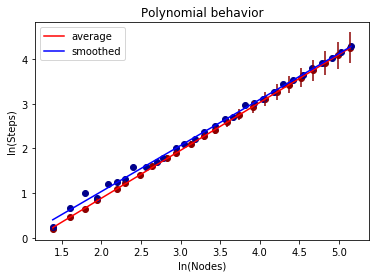

Regression results:

average
  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    1.072       -1.260      1.000
smoothed
  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    1.031       -1.027      0.998


In [72]:
PlotTwoRegressionResults(ac_nodes, ac_steps_mean, ac_steps_sd, sc_nodes, sc_smoothed_complexities, True, [2], 'k', 'polynomial', labels)

##### Random partition + RPF

###### Load results

In [158]:
ac_nodes = CsvToNumpy("./Results/AC_N_random_RG_RPF_serial/nodes")
ac_steps_mean = np.reshape(CsvToNumpy("./Results/AC_N_random_RG_RPF_serial/average_complexities"), (len(ac_nodes), 1))
ac_steps_sd = np.reshape(CsvToNumpy("./Results/AC_N_random_RG_RPF_serial/average_complexities_sd"), (len(ac_nodes), 1))
sc_nodes = CsvToNumpy("./Results/SC_N_random_RG_RPF_serial/nodes")
sc_smoothed_complexities = np.reshape(CsvToNumpy("./Results/SC_N_random_RG_RPF_serial/smoothed_complexities"), (len(sc_nodes), 1))

###### Polynomial behavior

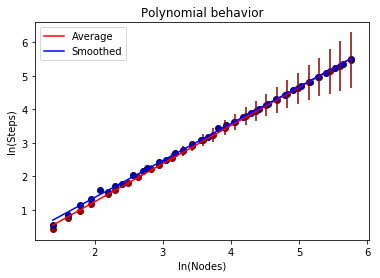

Regression results:

Average complexity
  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    1.138       -1.036      1.000

Smoothed complexity
  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    1.102       -0.838      0.999


In [159]:
PlotTwoRegressionResults(ac_nodes, ac_steps_mean, ac_steps_sd, sc_nodes, sc_smoothed_complexities, True, [2], 'k', 'polynomial', labels)

##### Random partition + WF

###### Load results

In [160]:
ac_nodes = CsvToNumpy("./Results/AC_N_random_RG_WF_serial/nodes")
ac_steps_mean = np.reshape(CsvToNumpy("./Results/AC_N_random_RG_WF_serial/average_complexities"), (len(ac_nodes), 1))
ac_steps_sd = np.reshape(CsvToNumpy("./Results/AC_N_random_RG_WF_serial/average_complexities_sd"), (len(ac_nodes), 1))
sc_nodes = CsvToNumpy("./Results/SC_N_random_RG_WF_serial/nodes")
sc_smoothed_complexities = np.reshape(CsvToNumpy("./Results/SC_N_random_RG_WF_serial/smoothed_complexities"), (len(sc_nodes), 1))

###### Polynomial behavior

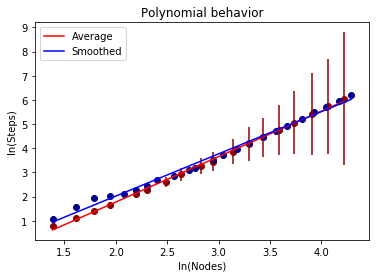

Regression results:

Average complexity
  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    1.880       -1.983      0.999

Smoothed complexity
  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    1.747       -1.471      0.996


In [161]:
PlotTwoRegressionResults(ac_nodes, ac_steps_mean, ac_steps_sd, sc_nodes, sc_smoothed_complexities, True, [2], 'k', 'polynomial', labels)

##### 0 partition + GBF

###### Load results

In [40]:
ac_nodes = CsvToNumpy("./Results/AC_N_0_RG_GBF_serial/nodes")
ac_steps_mean = np.reshape(CsvToNumpy("./Results/AC_N_0_RG_GBF_serial/average_complexities"), (len(ac_nodes), 1))
ac_steps_sd = np.reshape(CsvToNumpy("./Results/AC_N_0_RG_GBF_serial/average_complexities_sd"), (len(ac_nodes), 1))
sc_nodes = CsvToNumpy("./Results/SC_N_0_RG_GBF_serial/nodes")
sc_smoothed_complexities = np.reshape(CsvToNumpy("./Results/SC_N_0_RG_GBF_serial/smoothed_complexities"), (len(sc_nodes), 1))

###### Polynomial behavior

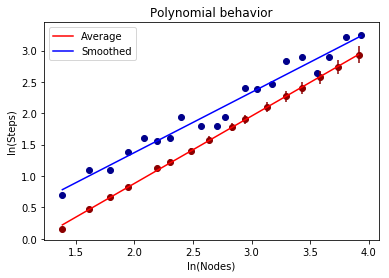

Regression results:

Average complexity
  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    1.075       -1.269      1.000

Smoothed complexity
  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    0.962       -0.550      0.983


In [282]:
PlotTwoRegressionResults(ac_nodes, ac_steps_mean, ac_steps_sd, sc_nodes, sc_smoothed_complexities, True, [2], 'k', 'polynomial', labels)

##### 0 partition + RPF

###### Load results

In [164]:
ac_nodes = CsvToNumpy("./Results/AC_N_0_RG_RPF_serial/nodes")
ac_steps_mean = np.reshape(CsvToNumpy("./Results/AC_N_0_RG_RPF_serial/average_complexities"), (len(ac_nodes), 1))
ac_steps_sd = np.reshape(CsvToNumpy("./Results/AC_N_0_RG_RPF_serial/average_complexities_sd"), (len(ac_nodes), 1))
sc_nodes = CsvToNumpy("./Results/SC_N_0_RG_RPF_serial/nodes")
sc_smoothed_complexities = np.reshape(CsvToNumpy("./Results/SC_N_0_RG_RPF_serial/smoothed_complexities"), (len(sc_nodes), 1))

###### Polynomial behavior

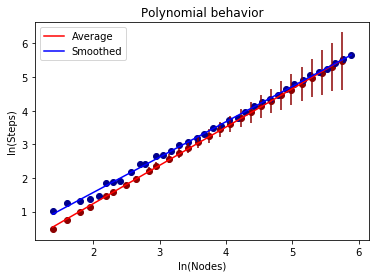

Regression results:

Average complexity
  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    1.139       -1.038      1.000

Smoothed complexity
  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    1.051       -0.532      0.999


In [165]:
PlotTwoRegressionResults(ac_nodes, ac_steps_mean, ac_steps_sd, sc_nodes, sc_smoothed_complexities, True, [2], 'k', 'polynomial', labels)

##### 0 partition + WF

###### Load results

In [166]:
ac_nodes = CsvToNumpy("./Results/AC_N_0_RG_WF_serial/nodes")
ac_steps_mean = np.reshape(CsvToNumpy("./Results/AC_N_0_RG_WF_serial/average_complexities"), (len(ac_nodes), 1))
ac_steps_sd = np.reshape(CsvToNumpy("./Results/AC_N_0_RG_WF_serial/average_complexities_sd"), (len(ac_nodes), 1))
sc_nodes = CsvToNumpy("./Results/SC_N_0_RG_WF_serial/nodes")
sc_smoothed_complexities = np.reshape(CsvToNumpy("./Results/SC_N_0_RG_WF_serial/smoothed_complexities"), (len(sc_nodes), 1))

###### Polynomial behavior

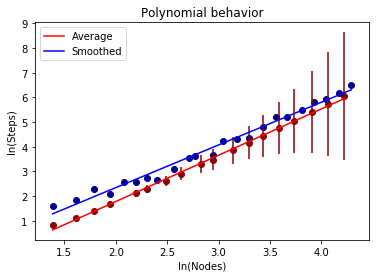

Regression results:

Average complexity
  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    1.876       -1.968      0.999

Smoothed complexity
  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    1.730       -1.114      0.992


In [167]:
PlotTwoRegressionResults(ac_nodes, ac_steps_mean, ac_steps_sd, sc_nodes, sc_smoothed_complexities, [], True, [2], 'k', 'polynomial', labels)

## Extra

### Plots

#### Intercalation plot

Text(0.5, 1.0, 'Intercalation=4')

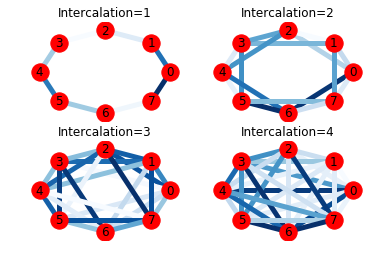

In [369]:
# Number of nodes
n = 8
# Number of partitions (k-cut)
k = 2

# Define min weight and max weight of the graph
min_weight=-1
max_weight=1

# Dropout
dropout = 0

# Initial values
graph_type = "intercalate"
fig, a =  plt.subplots(2,2)
W = InitializeGraph(n, min_weight, max_weight, dropout, None, graph_type, 1)
PlotGraph(W, partition=None, ax=a[0][0])
a[0][0].set_title('Intercalation=1')
W = InitializeGraph(n, min_weight, max_weight, dropout, None, graph_type, 2)
PlotGraph(W, partition=None, ax=a[0][1])
a[0][1].set_title('Intercalation=2')
W = InitializeGraph(n, min_weight, max_weight, dropout, None, graph_type, 3)
PlotGraph(W, partition=None, ax=a[1][0])
a[1][0].set_title('Intercalation=3')
W = InitializeGraph(n, min_weight, max_weight, dropout, None, graph_type, 4)
PlotGraph(W, partition=None, ax=a[1][1])
a[1][1].set_title('Intercalation=4')

#### Dropout plot

Text(0.5, 1.0, 'dropout=0.7')

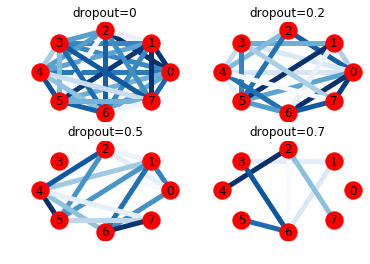

In [373]:
# Number of nodes
n = 8
# Number of partitions (k-cut)
k = 2

# Define min weight and max weight of the graph
min_weight=-1
max_weight=1

# Initial values
graph_type = "complete"
fig, a =  plt.subplots(2,2)
W = InitializeGraph(n, min_weight, max_weight, 0)
PlotGraph(W, partition=None, ax=a[0][0])
a[0][0].set_title('dropout=0')
W = InitializeGraph(n, min_weight, max_weight, 0.2)
PlotGraph(W, partition=None, ax=a[0][1])
a[0][1].set_title('dropout=0.2')
W = InitializeGraph(n, min_weight, max_weight, 0.5)
PlotGraph(W, partition=None, ax=a[1][0])
a[1][0].set_title('dropout=0.5')
W = InitializeGraph(n, min_weight, max_weight, 0.7)
PlotGraph(W, partition=None, ax=a[1][1])
a[1][1].set_title('dropout=0.7')

#### K-cut plot

Text(0.5, 1.0, 'k=3')

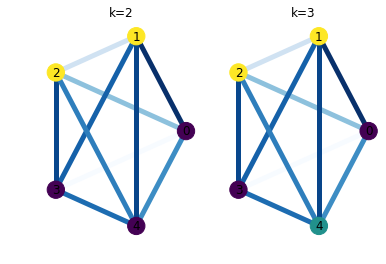

In [384]:
# Number of nodes
n = 5

# Define min weight and max weight of the graph
min_weight=-1
max_weight=1

# Dropout
dropout = 0

# Initial values
graph_type = "complete"
k = 2
W = InitializeGraph(n, min_weight, max_weight, dropout, None, graph_type, 2)
initial_partition = Get0Partition(n)
initial_z = CutCost(W, initial_partition, n, k)
fig, a =  plt.subplots(1, 2)
k = 2
partition, z, elapsed_time, steps = SolveMaxCut(W, n, k, initial_z, initial_partition, "GBF")
PlotGraph(W, partition=partition, ax=a[0])
a[0].set_title('k=2')
k = 3
partition, z, elapsed_time, steps = SolveMaxCut(W, n, k, initial_z, initial_partition, "GBF")
PlotGraph(W, partition=partition, ax=a[1])
a[1].set_title('k=3')

### Individual run

In [272]:
# Test one single point
w_flat = [-1, -1, -1]
w = SymmetricMatrix(w_flat)
n_iters = 1
k = 2
initial_partition_type = "random"
heuristic = "GBF"
complexity = "smoothed"
sigma = 0.01
steps = np.zeros(n_iters)
for it in range(n_iters):
    initial_partition = GetInitialPartition(3, k, initial_partition_type)
    initial_z = CutCost(w, initial_partition, 3, k)
    if complexity == "average":
        _p, _z, _t, steps[it] = SolveMaxCut(w, 3, k, initial_z, initial_partition, heuristic)
    elif complexity == "smoothed":
        # n_iters is also used for n_perturbations
        steps[it] = SmoothedComplexity(w_flat, 3, k, initial_partition_type, 0, n_iters, heuristic, sigma)
print(np.mean(steps))

AttributeError: 'list' object has no attribute 'ndim'